Copyright (c) 2024 Microsoft Corporation.

Licensed under the MIT License

Experimenting with `EuroSAT` dataset under 11 settings:
- Semantic Shift: Leave-one-class-out. Train on 9 class and test on 10 class 
- Covariate Shift: Longitude-wise split. Train on West and test on East 

For each, we perform: 
- activation extraction
- downsample benchmarking
- layer benchmarking
- `g` training and evaluation
- `g_hat` training and evaluation
- `g` and `g_hat` statistical significance test
- `g` benchmark
- clustering benchmark
- num_cluster vs. `g` and `g_hat` performance investigation
- activation space visualization    

In [38]:
import os
import sys

import torch

sys.path.append("..")
from src.tardis.eurosat_xbd_utils import *
from src.tardis.utils import *

print("CUDA available:", torch.cuda.is_available())
print("Number of GPUs:", torch.cuda.device_count())
print("Current GPU:", torch.cuda.current_device())
print("GPU Name:", torch.cuda.get_device_name(0))

%load_ext autoreload
%autoreload 2

fixed_seed = 31
set_seed(fixed_seed)

CUDA available: True
Number of GPUs: 2
Current GPU: 0
GPU Name: NVIDIA A100 80GB PCIe
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [116]:
# Define main directories for checkpoints and configs
ckpt_main_dir = "/data/dataood/exp_data/main_tardis/eurosat_exp_logs"
config_main_dir = "/ws/geospatial-ood-detection/configs"

# Define a function to construct the paths dynamically
def construct_paths(main_dir, sub_dir, filename):
    return os.path.join(main_dir, sub_dir, filename)

# Define subdirectories and filenames for each configuration and checkpoint
paths = {
    "forest": {
        "config": construct_paths(
            config_main_dir, "eurosat", "eurosat_holdout_Forest.yaml"
        ),
        "ckpt": construct_paths(
            ckpt_main_dir, "Holdout_Forest_resnet50_0066", "epoch=21-step=4972.ckpt"
        ),
    },
    "herb_veg": {
        "config": construct_paths(
            config_main_dir, "eurosat", "eurosat_holdout_HerbaceousVegetation.yaml"
        ),
        "ckpt": construct_paths(
            ckpt_main_dir,
            "Holdout_HerbaceousVegetation_resnet50_0066",
            "epoch=27-step=6328.ckpt",
        ),
    },
    "highway": {
        "config": construct_paths(
            config_main_dir, "eurosat", "eurosat_holdout_Highway.yaml"
        ),
        "ckpt": construct_paths(
            ckpt_main_dir, "Holdout_Highway_resnet50_0066", "epoch=28-step=6670.ckpt"
        ),
    },
    "industrial": {
        "config": construct_paths(
            config_main_dir, "eurosat", "eurosat_holdout_Industrial.yaml"
        ),
        "ckpt": construct_paths(
            ckpt_main_dir, "Holdout_Industrial_resnet50_0066", "epoch=32-step=7590.ckpt"
        ),
    },
    "pasture": {
        "config": construct_paths(
            config_main_dir, "eurosat", "eurosat_holdout_Pasture.yaml"
        ),
        "ckpt": construct_paths(
            ckpt_main_dir, "Holdout_Pasture_resnet50_0066", "epoch=34-step=8225.ckpt"
        ),
    },
    "permanentcrop": {
        "config": construct_paths(
            config_main_dir, "eurosat", "eurosat_holdout_PermanentCrop.yaml"
        ),
        "ckpt": construct_paths(
            ckpt_main_dir,
            "Holdout_PermanentCrop_resnet50_0066",
            "epoch=26-step=6210.ckpt",
        ),
    },
    "residential": {
        "config": construct_paths(
            config_main_dir, "eurosat", "eurosat_holdout_Residential.yaml"
        ),
        "ckpt": construct_paths(
            ckpt_main_dir,
            "Holdout_Residential_resnet50_0066",
            "epoch=49-step=11250.ckpt",
        ),
    },
    "river": {
        "config": construct_paths(
            config_main_dir, "eurosat", "eurosat_holdout_River.yaml"
        ),
        "ckpt": construct_paths(
            ckpt_main_dir, "Holdout_River_resnet50_0066", "epoch=31-step=7392.ckpt"
        ),
    },
    "sealake": {
        "config": construct_paths(
            config_main_dir, "eurosat", "eurosat_holdout_SeaLake.yaml"
        ),
        "ckpt": construct_paths(
            ckpt_main_dir, "Holdout_SeaLake_resnet50_0066", "epoch=34-step=7875.ckpt"
        ),
    },
    "annualcrop": {
        "config": construct_paths(
            config_main_dir, "eurosat", "eurosat_holdout_AnnualCrop.yaml"
        ),
        "ckpt": construct_paths(
            ckpt_main_dir, "Holdout_AnnualCrop_resnet50_0066", "epoch=15-step=3616.ckpt"
        ),
    },
    "spatial_split": {
        "config": construct_paths(
            config_main_dir, "eurosat", "eurosat_Spatial.yaml"
        ),
        "ckpt": construct_paths(
            ckpt_main_dir, "eurosat_spatial_0776", "epoch=18-step=4826.ckpt"
        ),
    },
}

# Define other parameters
layer = ["conv1"]
downsample_method = "avg_pool"
getitem_keys = ["image", "label"]
n_batches_to_process = 2 # Set to ´None´ to process all the samples
device = "cuda" if torch.cuda.is_available() else "cpu"

# Downsampling methods and benchmarks
downsample_methods = ["avg_pool", "mean_std", "avg_pool", "max_pool", "nodownsample"]
downsample_benchmark = {}
layer_benchmark = {}

verbose = False
test_size = 0.2
n_estimators = 100
split_seed = 31
fixed_classifier_seed = 31

n_optuna_trials = 20
min_cluster = 2
max_cluster_ratio = 0.3
min_fraction = 0.01
max_fraction = 0.2
fixed_seed = 31

# Print paths to verify
for key, path in paths.items():
    print(f"{key} config path: {path['config']}")
    print(f"{key} ckpt path: {path['ckpt']}")

forest config path: /ws/geospatial-ood-detection/configs/eurosat/eurosat_holdout_Forest.yaml
forest ckpt path: /data/dataood/exp_data/main_tardis/eurosat_exp_logs/Holdout_Forest_resnet50_0066/epoch=21-step=4972.ckpt
herb_veg config path: /ws/geospatial-ood-detection/configs/eurosat/eurosat_holdout_HerbaceousVegetation.yaml
herb_veg ckpt path: /data/dataood/exp_data/main_tardis/eurosat_exp_logs/Holdout_HerbaceousVegetation_resnet50_0066/epoch=27-step=6328.ckpt
highway config path: /ws/geospatial-ood-detection/configs/eurosat/eurosat_holdout_Highway.yaml
highway ckpt path: /data/dataood/exp_data/main_tardis/eurosat_exp_logs/Holdout_Highway_resnet50_0066/epoch=28-step=6670.ckpt
industrial config path: /ws/geospatial-ood-detection/configs/eurosat/eurosat_holdout_Industrial.yaml
industrial ckpt path: /data/dataood/exp_data/main_tardis/eurosat_exp_logs/Holdout_Industrial_resnet50_0066/epoch=32-step=7590.ckpt
pasture config path: /ws/geospatial-ood-detection/configs/eurosat/eurosat_holdout_Pa

# Forest

### Start

In [7]:
collect_aug_input = True

X,y,model,datamodule,train_dataloader,val_dataloader,test_dataloader,cfg_dict = get_X_y_arrays(
    paths["forest"]["config"],
    paths["forest"]["ckpt"],
    layer,
    downsample_method,
    getitem_keys,
    device,
    n_batches_to_process,
    mode="holdout",
    verbose=False,
    collect_aug_input=collect_aug_input,
)

Model and Task are loaded.
download True
Loaded statistics for Forest: MEAN={'B01': 1354.4052734375, 'B02': 1118.243896484375, 'B03': 1042.9302978515625, 'B04': 947.62646484375, 'B05': 1199.472412109375, 'B06': 1999.7911376953125, 'B07': 2369.22314453125, 'B08': 2296.8251953125, 'B8A': 732.083251953125, 'B09': 12.113274574279785, 'B10': 1819.0098876953125, 'B11': 1118.923828125, 'B12': 2594.14208984375}, STD={'B01': 245.71810913085938, 'B02': 333.00836181640625, 'B03': 395.0931396484375, 'B04': 593.751708984375, 'B05': 566.4182739257812, 'B06': 861.1854248046875, 'B07': 1086.6336669921875, 'B08': 1117.9840087890625, 'B8A': 404.9206848144531, 'B09': 4.775852680206299, 'B10': 1002.5895385742188, 'B11': 761.3046264648438, 'B12': 1231.587890625}
self.split_urls {'train': 'https://huggingface.co/datasets/brkekm/EuroSATHoldOutSplits/resolve/main/train_forest.txt', 'val': 'https://huggingface.co/datasets/brkekm/EuroSATHoldOutSplits/resolve/main/val_forest.txt', 'test': 'https://huggingface.co

100%|██████████| 2067725275/2067725275 [00:09<00:00, 215518796.34it/s]


100%|██████████| 285463/285463 [00:00<00:00, 10388430.89it/s]


100%|██████████| 190074/190074 [00:00<00:00, 1940190.46it/s]


100%|██████████| 46893/46893 [00:00<00:00, 7047061.89it/s]


classes and class to idx ['SeaLake', 'Residential', 'PermanentCrop', 'Industrial', 'Pasture', 'AnnualCrop', 'HerbaceousVegetation', 'River', 'Highway'] {'AnnualCrop': 0, 'HerbaceousVegetation': 1, 'Highway': 2, 'Industrial': 3, 'Pasture': 4, 'PermanentCrop': 5, 'Residential': 6, 'River': 7, 'SeaLake': 8}
self.train_dataset.split_urls {'train': 'https://huggingface.co/datasets/brkekm/EuroSATHoldOutSplits/resolve/main/train_forest.txt', 'val': 'https://huggingface.co/datasets/brkekm/EuroSATHoldOutSplits/resolve/main/val_forest.txt', 'test': 'https://huggingface.co/datasets/brkekm/EuroSATHoldOutSplits/resolve/main/test_forest.txt'}
self.split_urls {'train': 'https://huggingface.co/datasets/brkekm/EuroSATHoldOutSplits/resolve/main/train_forest.txt', 'val': 'https://huggingface.co/datasets/brkekm/EuroSATHoldOutSplits/resolve/main/val_forest.txt', 'test': 'https://huggingface.co/datasets/brkekm/EuroSATHoldOutSplits/resolve/main/test_forest.txt'}
self.root /data/dataood/eurosat_holdout_datase

100%|██████████| 2/2 [00:01<00:00,  1.26it/s]


Before downsampling, activations shape for layer conv1 : (128, 64, 32, 32)


100%|██████████| 2/2 [00:00<00:00,  6.32it/s]


Before downsampling, activations shape for layer conv1 : (128, 64, 32, 32)


### Downsample Benchmark

In [14]:
for downsample in downsample_methods:
    print(f"Running experiments for {downsample} downsample method.")
    X, y, test_property_lengths = create_feature_matrix_and_labels(
        model=model,
        dm=datamodule,
        train_dataloader=train_dataloader,
        test_dataloader=test_dataloader,
        layer_names=collect_activations_from_layers,
        device=device,
        getitem_keys=getitem_keys,
        n_batches_to_process=n_batches_to_process,
        downsample_method=downsample,
        verbose=verbose,
    )
    print("Run g experiment for downsample method:", downsample)
    g_benchmark = run_g_experiment(
        X, y, split_seed, test_size, n_estimators, fixed_classifier_seed, clf=None
    )
    dict_key = datamodule.class_name + "_" + downsample
    downsample_benchmark[dict_key] = g_benchmark

Running experiments for avg_pool downsample method.


100%|██████████| 2/2 [00:00<00:00,  6.95it/s]


Before downsampling, activations shape for layer conv1 : (128, 64, 32, 32)


100%|██████████| 2/2 [00:00<00:00,  6.95it/s]


Before downsampling, activations shape for layer conv1 : (128, 64, 32, 32)
Run g experiment for downsample method: avg_pool
Running experiments for mean_std downsample method.


100%|██████████| 2/2 [00:00<00:00,  6.69it/s]


Before downsampling, activations shape for layer conv1 : (128, 64, 32, 32)


100%|██████████| 2/2 [00:00<00:00,  6.43it/s]


Before downsampling, activations shape for layer conv1 : (128, 64, 32, 32)
Run g experiment for downsample method: mean_std
Running experiments for avg_pool downsample method.


100%|██████████| 2/2 [00:00<00:00,  6.94it/s]


Before downsampling, activations shape for layer conv1 : (128, 64, 32, 32)


100%|██████████| 2/2 [00:00<00:00,  7.33it/s]


Before downsampling, activations shape for layer conv1 : (128, 64, 32, 32)
Run g experiment for downsample method: avg_pool
Running experiments for max_pool downsample method.


100%|██████████| 2/2 [00:00<00:00,  6.93it/s]


Before downsampling, activations shape for layer conv1 : (128, 64, 32, 32)


100%|██████████| 2/2 [00:00<00:00,  6.58it/s]


Before downsampling, activations shape for layer conv1 : (128, 64, 32, 32)
Run g experiment for downsample method: max_pool
Running experiments for nodownsample downsample method.


100%|██████████| 2/2 [00:00<00:00,  7.09it/s]


Before downsampling, activations shape for layer conv1 : (128, 64, 32, 32)


100%|██████████| 2/2 [00:00<00:00,  7.00it/s]


Before downsampling, activations shape for layer conv1 : (128, 64, 32, 32)
Run g experiment for downsample method: nodownsample


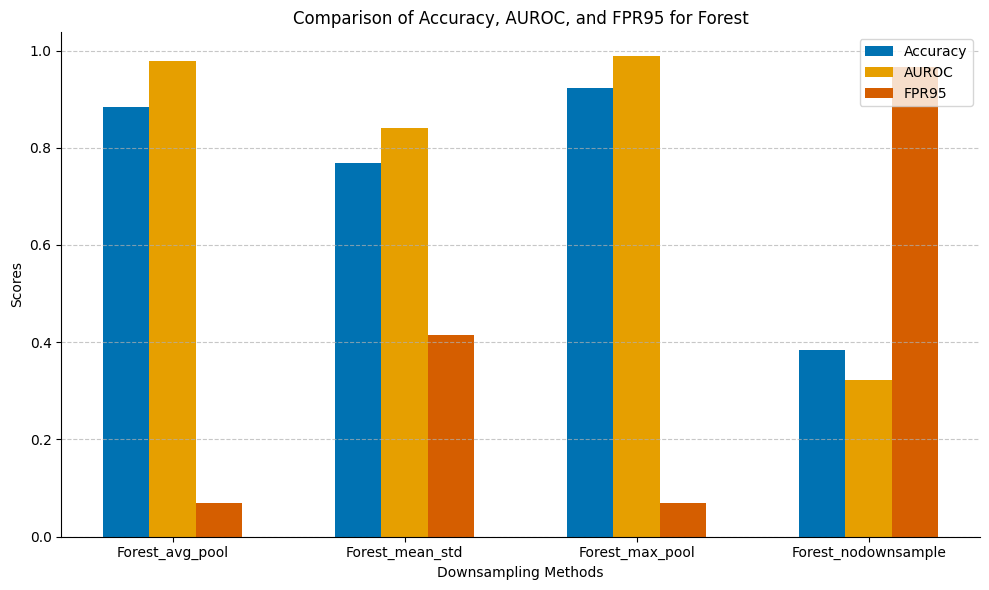

In [15]:
plot_downsample_benchmark(downsample_benchmark, datamodule.class_name)

### Layer Benchmark

In [16]:
all_layer_names = get_all_layer_names(model)

conv_layers = [layer for layer in all_layer_names if "conv" in layer]
selected_layers = pick_random_layers(all_layer_names, 10)
selected_layers = [[layer] for layer in selected_layers]

In [17]:
for lyr in selected_layers:
    print(f"Running experiments for layer {lyr}")
    X, y, test_property_lengths = create_feature_matrix_and_labels(
        model=model,
        dm=datamodule,
        train_dataloader=train_dataloader,
        test_dataloader=test_dataloader,
        layer_names=lyr,
        device=device,
        getitem_keys=getitem_keys,
        n_batches_to_process=n_batches_to_process,
        downsample_method=downsample_method,
        verbose=verbose,
    )

    g_benchmark = run_g_experiment(
        X, y, split_seed, test_size, n_estimators, fixed_classifier_seed, clf=None
    )
    dict_key = datamodule.class_name + "_" + str(lyr)

    layer_benchmark[dict_key] = g_benchmark

Running experiments for layer ['conv1']


100%|██████████| 2/2 [00:00<00:00,  6.98it/s]


Before downsampling, activations shape for layer conv1 : (128, 64, 32, 32)


100%|██████████| 2/2 [00:00<00:00,  7.16it/s]


Before downsampling, activations shape for layer conv1 : (128, 64, 32, 32)
Running experiments for layer ['layer1.0.conv1']


100%|██████████| 2/2 [00:00<00:00,  6.92it/s]


Before downsampling, activations shape for layer layer1.0.conv1 : (128, 64, 16, 16)


100%|██████████| 2/2 [00:00<00:00,  7.32it/s]


Before downsampling, activations shape for layer layer1.0.conv1 : (128, 64, 16, 16)
Running experiments for layer ['layer3.3.conv1']


100%|██████████| 2/2 [00:00<00:00,  6.55it/s]


Before downsampling, activations shape for layer layer3.3.conv1 : (128, 256, 4, 4)


100%|██████████| 2/2 [00:00<00:00,  7.44it/s]


Before downsampling, activations shape for layer layer3.3.conv1 : (128, 256, 4, 4)
Running experiments for layer ['layer1.2.conv2']


100%|██████████| 2/2 [00:00<00:00,  7.10it/s]


Before downsampling, activations shape for layer layer1.2.conv2 : (128, 64, 16, 16)


100%|██████████| 2/2 [00:00<00:00,  6.81it/s]


Before downsampling, activations shape for layer layer1.2.conv2 : (128, 64, 16, 16)
Running experiments for layer ['layer3.1.conv2']


100%|██████████| 2/2 [00:00<00:00,  6.65it/s]


Before downsampling, activations shape for layer layer3.1.conv2 : (128, 256, 4, 4)


100%|██████████| 2/2 [00:00<00:00,  7.15it/s]


Before downsampling, activations shape for layer layer3.1.conv2 : (128, 256, 4, 4)
Running experiments for layer ['layer2.0.conv1']


100%|██████████| 2/2 [00:00<00:00,  7.43it/s]


Before downsampling, activations shape for layer layer2.0.conv1 : (128, 128, 16, 16)


100%|██████████| 2/2 [00:00<00:00,  7.28it/s]


Before downsampling, activations shape for layer layer2.0.conv1 : (128, 128, 16, 16)
Running experiments for layer ['layer1.0.conv3']


100%|██████████| 2/2 [00:00<00:00,  6.99it/s]


Before downsampling, activations shape for layer layer1.0.conv3 : (128, 256, 16, 16)


100%|██████████| 2/2 [00:00<00:00,  6.23it/s]


Before downsampling, activations shape for layer layer1.0.conv3 : (128, 256, 16, 16)
Running experiments for layer ['layer1.2.conv3']


100%|██████████| 2/2 [00:00<00:00,  6.98it/s]


Before downsampling, activations shape for layer layer1.2.conv3 : (128, 256, 16, 16)


100%|██████████| 2/2 [00:00<00:00,  7.08it/s]


Before downsampling, activations shape for layer layer1.2.conv3 : (128, 256, 16, 16)
Running experiments for layer ['layer4.1.conv3']


100%|██████████| 2/2 [00:00<00:00,  7.53it/s]


Before downsampling, activations shape for layer layer4.1.conv3 : (128, 2048, 2, 2)


100%|██████████| 2/2 [00:00<00:00,  7.41it/s]


Before downsampling, activations shape for layer layer4.1.conv3 : (128, 2048, 2, 2)
Running experiments for layer ['layer4.2.conv3']


100%|██████████| 2/2 [00:00<00:00,  7.25it/s]


Before downsampling, activations shape for layer layer4.2.conv3 : (128, 2048, 2, 2)


100%|██████████| 2/2 [00:00<00:00,  7.60it/s]


Before downsampling, activations shape for layer layer4.2.conv3 : (128, 2048, 2, 2)


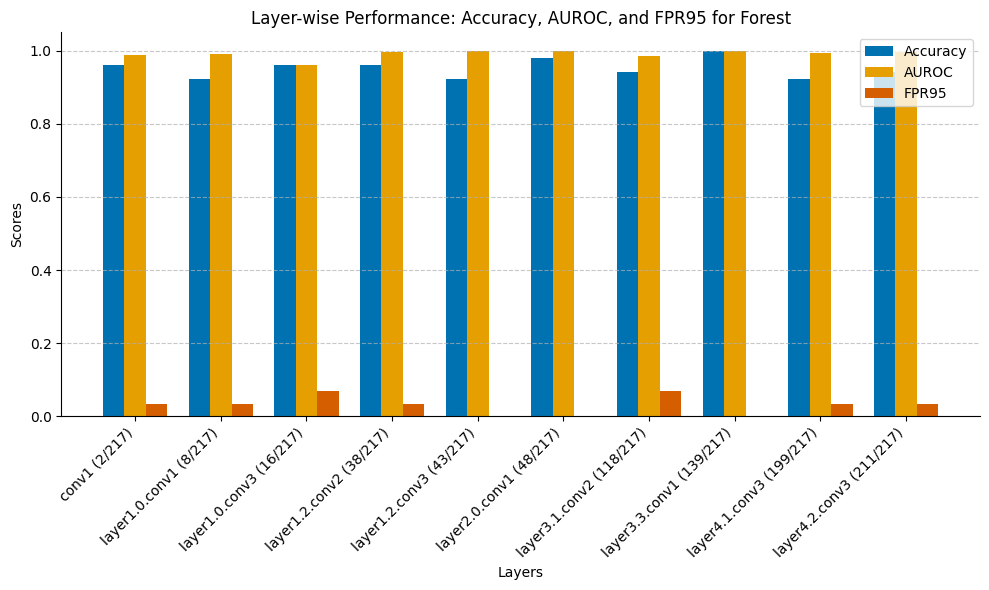

In [18]:
plot_layer_benchmark(layer_benchmark, all_layer_names, datamodule.class_name)

### `g` confidence interval

In [20]:
g_benchmark = run_multiple_experiments_g(
    X, y, test_size, n_estimators, random_seed=True
)

random_state for split_seed: 1392
random_state for split_seed: 878
random_state for split_seed: 3916
random_state for split_seed: 751
random_state for split_seed: 2170
random_state for split_seed: 4239
random_state for split_seed: 2395
random_state for split_seed: 7814
random_state for split_seed: 3302
random_state for split_seed: 9646


In [21]:
columns_of_interest = ["baseline_accuracy", "baseline_fpr95", "baseline_roc_auc"]
confidence_intervals_g = calculate_confidence_intervals(
    g_benchmark, columns_of_interest
)
confidence_intervals_g

{'baseline_accuracy': (0.923076923076923, 0.027513727153397696),
 'baseline_fpr95': (0.11668314255570626, 0.06078055040126602),
 'baseline_roc_auc': (0.9763632457921035, 0.011396123499416077)}

### `g_hat`

In [34]:
results_df_g_hat = run_optuna_study(
    X,
    y,
    n_optuna_trials,
    test_size,
    min_cluster,
    max_cluster_ratio,
    min_fraction,
    max_fraction,
    n_estimators,
    fixed_seed
)

[I 2024-12-22 17:57:49,826] A new study created in memory with name: no-name-9092b488-cc67-4c5e-a80d-1023d3d6c792
[I 2024-12-22 17:57:49,882] Trial 0 finished with value: -0.8783477661126587 and parameters: {'k': 19, 'M': 0.19204005763861}. Best is trial 0 with value: -0.8783477661126587.
[I 2024-12-22 17:57:49,984] Trial 1 finished with value: -0.9034860594573223 and parameters: {'k': 48, 'M': 0.19750530058756796}. Best is trial 1 with value: -0.9034860594573223.
[I 2024-12-22 17:57:50,049] Trial 2 finished with value: -0.8775074616880231 and parameters: {'k': 14, 'M': 0.03601423928032735}. Best is trial 1 with value: -0.9034860594573223.
[I 2024-12-22 17:57:50,169] Trial 3 finished with value: -0.9328834475746444 and parameters: {'k': 56, 'M': 0.023041318415652854}. Best is trial 3 with value: -0.9328834475746444.
[I 2024-12-22 17:57:50,205] Trial 4 finished with value: -0.7066072363527627 and parameters: {'k': 6, 'M': 0.11327159100258942}. Best is trial 3 with value: -0.932883447574

In [35]:
N = 10
results_dict = results_df_g_hat.to_dict(orient="records")
k = int(len(X) * 0.3)
M = results_dict[0]["M"]
print("k, M, len(X), k/len(X)", k, M, len(X), k / len(X))

g_hat_benchmark = run_multiple_experiments_g_hat(X, y, test_size, k, M, N, fixed_seed)

k, M, len(X), k/len(X) 76 0.12942942912679828 256 0.296875
random_state for split_seed in iteration 1: 8373
random_state for split_seed in iteration 2: 3206
random_state for split_seed in iteration 3: 6724
random_state for split_seed in iteration 4: 1050
random_state for split_seed in iteration 5: 6989
random_state for split_seed in iteration 6: 1345
random_state for split_seed in iteration 7: 5685
random_state for split_seed in iteration 8: 6101
random_state for split_seed in iteration 9: 285
random_state for split_seed in iteration 10: 6304


### g g_hat mean std + ttest

In [36]:
t_tests_results = perform_benchmark_analysis(g_benchmark, g_hat_benchmark)
t_tests_results

Baseline Accuracy: Mean = 0.923076923076923, Std Dev = 0.038461538461538464
Baseline ROC AUC: Mean = 0.9763632457921035, Std Dev = 0.015930682158818536
Baseline FPR95: Mean = 0.11668314255570626, Std Dev = 0.0849653507116023
g_hat Accuracy: Mean = 0.8673076923076921, Std Dev = 0.059064869229689454
g_hat ROC AUC: Mean = 0.9376212381273289, Std Dev = 0.029188939672337835
g_hat FPR95: Mean = 0.22901569849995637, Std Dev = 0.1594137340532962
Accuracy: t = 2.502108292162277, p = 0.02221046001321838
ROC AUC: t = 3.6842372882181804, p = 0.0016972034452200713
FPR95: t = -1.966458549652335, p = 0.0648594256985241


{'accuracy': (2.502108292162277, 0.02221046001321838),
 'roc_auc': (3.6842372882181804, 0.0016972034452200713),
 'fpr95': (-1.966458549652335, 0.0648594256985241)}

### Benchmark g

In [45]:
classifier_benchmark_df = benchmark_classifiers(
    X, y, test_size, k, M, classifiers, fixed_seed
)

In [48]:
classifier_benchmark_df

Classifier  Accuracy   ROC_AUC     FPR95  \
0  RandomForestUnblanaced  0.884615  0.980510  0.068966   
1            RandomForest  0.865385  0.982009  0.034483   
2                     SVC  0.942308  0.977511  0.034483   
3              KNeighbors  0.903846  0.970015  0.172414   
4      LogisticRegression  0.884615  0.959520  0.137931   
5            DecisionTree  0.711538  0.709895  1.000000   
6        GradientBoosting  0.826923  0.914543  0.448276   
7                AdaBoost  0.865385  0.970015  0.172414   
8              ExtraTrees  0.903846  0.970765  0.068966   
9              GaussianNB  0.903846  0.945277  0.172414   

   Number of Train Samples  Number of Val Samples  Cluster Fit Time (s)  \
0                      204                     52              0.092413   
1                      204                     52              0.092413   
2                      204                     52              0.092413   
3                      204                     52              0.092413   
4                      204                     52              0.092413   
5                      204                     52              0.092413   
6                      204                     52              0.092413   
7                      204                     52              0.092413   
8                      204                     52              0.092413   
9                      204                     52              0.092413   

   Classifier Fit Time (s)  Classifier Fit Time (s/sample)  \
0                 0.313450                        0.001537   
1                 0.295580                        0.001449   
2                 0.058516                        0.000287   
3                 0.002688                        0.000013   
4                 0.022362                        0.000110   
5                 0.157358                        0.000771   
6                 8.812475                        0.043198   
7                 1.981237                        0.009712   
8                 0.141588                        0.000694   
9                 0.003446                        0.000017   

   Classifier Pred Time (s)  Classifier Pred Time (s/sample)  
0                  0.004343                         0.000084  
1                  0.003926                         0.000076  
2                  0.005557                         0.000107  
3                  0.002618                         0.000050  
4                  0.000474                         0.000009  
5                  0.000473                         0.000009  
6                  0.000823                         0.000016  
7                  0.007177                         0.000138  
8                  0.004021                         0.000077  
9                  0.000898                         0.000017

### Benchmark clustering

In [50]:
# A fixed classifier
classifier = classifiers['RandomForest']

clustering_benchmark_df = benchmark_clustering_methods(
    X, y, test_size, k, M, clustering_methods, classifier
)

clustering_benchmark_df

### Investigate k wrt g-g_hat

confidence_intervals_g {'baseline_accuracy': (0.923076923076923, 0.027513727153397696), 'baseline_fpr95': (0.11668314255570626, 0.06078055040126602), 'baseline_roc_auc': (0.9763632457921035, 0.011396123499416077)}
Max i: 7
k: 1
Skipping k=1 on run 1 due to single class in y_clusters.
Skipping k=1 on run 2 due to single class in y_clusters.
Skipping k=1 on run 3 due to single class in y_clusters.
Skipping k=1 on run 4 due to single class in y_clusters.
Skipping k=1 on run 5 due to single class in y_clusters.
Skipping k=1 on run 6 due to single class in y_clusters.
Skipping k=1 on run 7 due to single class in y_clusters.
Skipping k=1 on run 8 due to single class in y_clusters.
Skipping k=1 on run 9 due to single class in y_clusters.
Skipping k=1 on run 10 due to single class in y_clusters.
k: 2
Skipping k=2 on run 1 due to single class in y_clusters.
Skipping k=2 on run 2 due to single class in y_clusters.
Skipping k=2 on run 3 due to single class in y_clusters.
Skipping k=2 on run 4 due

/ws/geospatial-ood-detection/notebooks/../src/tardis/eurosat_xbd_utils.py:991: RuntimeWarning: Mean of empty slice
  mean = np.nanmean(values)
/ws/geospatial-ood-detection/notebooks/../src/tardis/eurosat_xbd_utils.py:992: SmallSampleWarning: One or more sample arguments is too small; all returned values will be NaN. See documentation for sample size requirements.
  sem = stats.sem(values, nan_policy="omit")
/ws/geospatial-ood-detection/notebooks/../src/tardis/eurosat_xbd_utils.py:991: RuntimeWarning: Mean of empty slice
  mean = np.nanmean(values)
/ws/geospatial-ood-detection/notebooks/../src/tardis/eurosat_xbd_utils.py:992: SmallSampleWarning: One or more sample arguments is too small; all returned values will be NaN. See documentation for sample size requirements.
  sem = stats.sem(values, nan_policy="omit")


Skipping k=4 on run 10 due to single class in y_clusters.
k: 8
k: 16
k: 32
k: 64
k: 128
k: 204


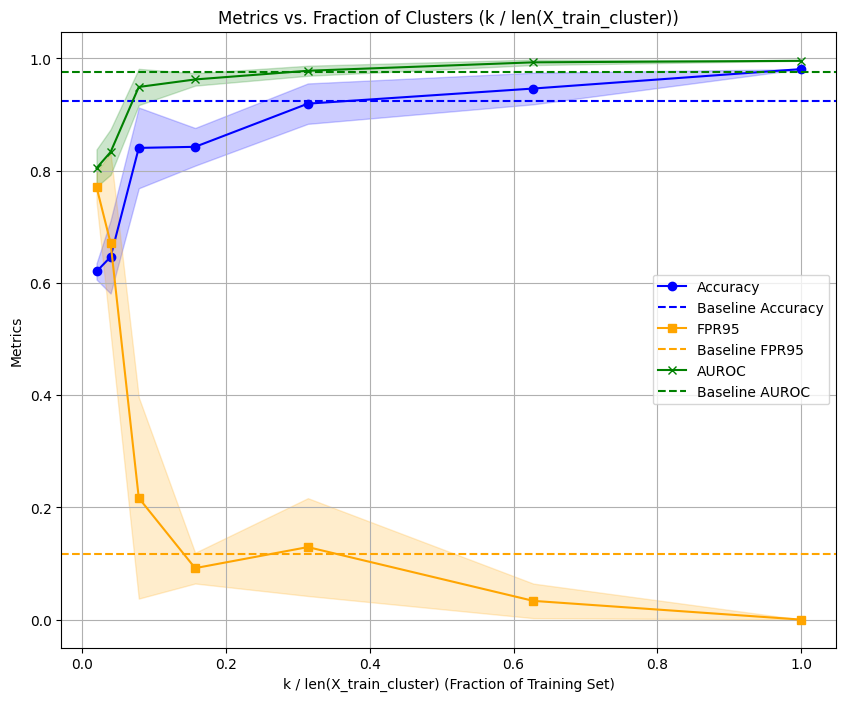

In [51]:
print("confidence_intervals_g", confidence_intervals_g)

df_results = benchmark_kmeans_with_varying_k_condidence_g_hat(
    X,
    y,
    M,
    test_size,
    n_runs=10,
    confidence_level=0.95,
    confidence_intervals_g=confidence_intervals_g,
    clf=None,
    save_plot=True,
    fname=cfg_dict["data"]["class_name"],
)

### Feature Level Visualization: Understand how clustering alters the structure of the feature space

Plotting
Proportion of label changes: 0.10


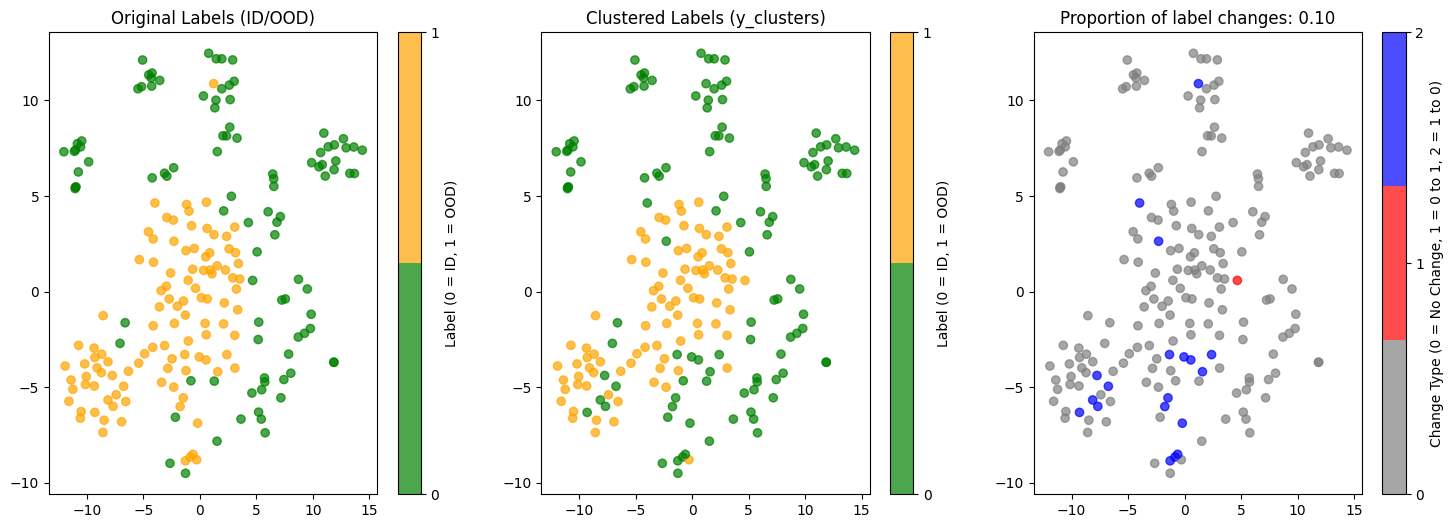

In [54]:
i = 0
_, X_train_cluster, y_train_cluster, y_clusters, *_ = run_g_hat_experiment(
    X, y, test_size, k, M, fixed_seed, fixed_seed, i + 1
)
plot_tsne_with_label_changes(
    X_train_cluster,
    y_train_cluster,
    y_clusters,
    class_name=cfg_dict.data.class_name,
    save_plot=True,
)

# HerbaceousVegetation

### Start

In [61]:
X,y,model,datamodule,train_dataloader,val_dataloader,test_dataloader,cfg_dict = get_X_y_arrays(
        paths["herb_veg"]["config"],
        paths["herb_veg"]["ckpt"],
        layer,
        downsample_method,
        getitem_keys,
        device,
        n_batches_to_process,
        mode="holdout",
        verbose=False,
    )

Model and Task are loaded.
download True
Loaded statistics for HerbaceousVegetation: MEAN={'B01': 1354.405029296875, 'B02': 1118.2440185546875, 'B03': 1042.929443359375, 'B04': 947.6260375976562, 'B05': 1199.472412109375, 'B06': 1999.791259765625, 'B07': 2369.221923828125, 'B08': 2296.826416015625, 'B8A': 732.083251953125, 'B09': 12.11327838897705, 'B10': 1819.0101318359375, 'B11': 1118.9237060546875, 'B12': 2594.14013671875}, STD={'B01': 245.71812438964844, 'B02': 333.00836181640625, 'B03': 395.0932922363281, 'B04': 593.751708984375, 'B05': 566.4181518554688, 'B06': 861.1854858398438, 'B07': 1086.6331787109375, 'B08': 1117.98388671875, 'B8A': 404.9206237792969, 'B09': 4.775853157043457, 'B10': 1002.5894775390625, 'B11': 761.3045654296875, 'B12': 1231.588134765625}
self.split_urls {'train': 'https://huggingface.co/datasets/brkekm/EuroSATHoldOutSplits/resolve/main/train_herbaceousvegetation.txt', 'val': 'https://huggingface.co/datasets/brkekm/EuroSATHoldOutSplits/resolve/main/val_herbac

100%|██████████| 2/2 [00:00<00:00,  6.56it/s]


Before downsampling, activations shape for layer conv1 : (128, 64, 32, 32)


100%|██████████| 2/2 [00:00<00:00,  7.11it/s]


Before downsampling, activations shape for layer conv1 : (128, 64, 32, 32)


### Downsample Benchmark

In [62]:
for downsample in downsample_methods:
    print(f"Running experiments for {downsample} downsample method.")
    X, y, test_property_lengths = create_feature_matrix_and_labels(
        model=model,
        dm=datamodule,
        train_dataloader=train_dataloader,
        test_dataloader=test_dataloader,
        layer_names=collect_activations_from_layers,
        device=device,
        getitem_keys=getitem_keys,
        n_batches_to_process=n_batches_to_process,
        downsample_method=downsample,
        verbose=verbose,
    )
    print("Run g experiment for downsample method:", downsample)
    g_benchmark = run_g_experiment(
        X, y, split_seed, test_size, n_estimators, fixed_classifier_seed, clf=None
    )
    dict_key = datamodule.class_name + "_" + downsample
    downsample_benchmark[dict_key] = g_benchmark

Running experiments for avg_pool downsample method.


100%|██████████| 2/2 [00:00<00:00,  6.80it/s]


Before downsampling, activations shape for layer conv1 : (128, 64, 32, 32)


100%|██████████| 2/2 [00:00<00:00,  6.98it/s]


Before downsampling, activations shape for layer conv1 : (128, 64, 32, 32)
Run g experiment for downsample method: avg_pool
Running experiments for mean_std downsample method.


100%|██████████| 2/2 [00:00<00:00,  6.83it/s]


Before downsampling, activations shape for layer conv1 : (128, 64, 32, 32)


100%|██████████| 2/2 [00:00<00:00,  6.62it/s]


Before downsampling, activations shape for layer conv1 : (128, 64, 32, 32)
Run g experiment for downsample method: mean_std
Running experiments for avg_pool downsample method.


100%|██████████| 2/2 [00:00<00:00,  6.96it/s]


Before downsampling, activations shape for layer conv1 : (128, 64, 32, 32)


100%|██████████| 2/2 [00:00<00:00,  6.92it/s]


Before downsampling, activations shape for layer conv1 : (128, 64, 32, 32)
Run g experiment for downsample method: avg_pool
Running experiments for max_pool downsample method.


100%|██████████| 2/2 [00:00<00:00,  6.84it/s]


Before downsampling, activations shape for layer conv1 : (128, 64, 32, 32)


100%|██████████| 2/2 [00:00<00:00,  6.86it/s]


Before downsampling, activations shape for layer conv1 : (128, 64, 32, 32)
Run g experiment for downsample method: max_pool
Running experiments for nodownsample downsample method.


100%|██████████| 2/2 [00:00<00:00,  7.10it/s]


Before downsampling, activations shape for layer conv1 : (128, 64, 32, 32)


100%|██████████| 2/2 [00:00<00:00,  7.12it/s]


Before downsampling, activations shape for layer conv1 : (128, 64, 32, 32)
Run g experiment for downsample method: nodownsample


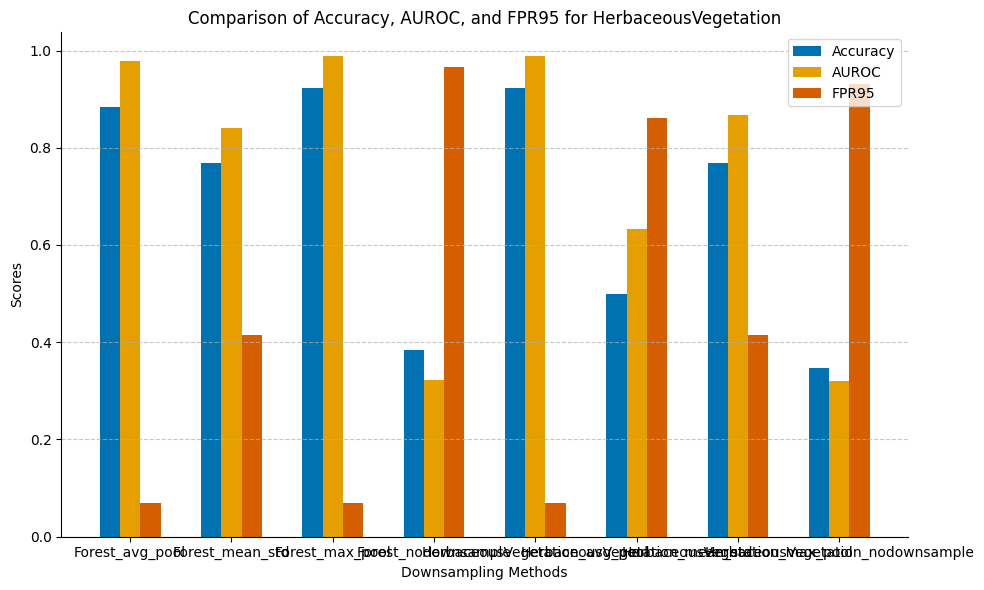

In [63]:
plot_downsample_benchmark(downsample_benchmark, datamodule.class_name)

### Layer Benchmark

In [64]:
for lyr in selected_layers:
    print(f"Running experiments for layer {lyr}")
    X, y, test_property_lengths = create_feature_matrix_and_labels(
        model=model,
        dm=datamodule,
        train_dataloader=train_dataloader,
        test_dataloader=test_dataloader,
        layer_names=lyr,
        device=device,
        getitem_keys=getitem_keys,
        n_batches_to_process=n_batches_to_process,
        downsample_method=downsample_method,
        verbose=verbose,
    )

    g_benchmark = run_g_experiment(
        X, y, split_seed, test_size, n_estimators, fixed_classifier_seed, clf=None
    )
    dict_key = datamodule.class_name + "_" + str(lyr)

    layer_benchmark[dict_key] = g_benchmark

Running experiments for layer ['conv1']


100%|██████████| 2/2 [00:00<00:00,  6.82it/s]


Before downsampling, activations shape for layer conv1 : (128, 64, 32, 32)


100%|██████████| 2/2 [00:00<00:00,  6.76it/s]


Before downsampling, activations shape for layer conv1 : (128, 64, 32, 32)
Running experiments for layer ['layer1.0.conv1']


100%|██████████| 2/2 [00:00<00:00,  7.69it/s]


Before downsampling, activations shape for layer layer1.0.conv1 : (128, 64, 16, 16)


100%|██████████| 2/2 [00:00<00:00,  6.98it/s]


Before downsampling, activations shape for layer layer1.0.conv1 : (128, 64, 16, 16)
Running experiments for layer ['layer3.3.conv1']


100%|██████████| 2/2 [00:00<00:00,  7.15it/s]


Before downsampling, activations shape for layer layer3.3.conv1 : (128, 256, 4, 4)


100%|██████████| 2/2 [00:00<00:00,  7.37it/s]


Before downsampling, activations shape for layer layer3.3.conv1 : (128, 256, 4, 4)
Running experiments for layer ['layer1.2.conv2']


100%|██████████| 2/2 [00:00<00:00,  7.55it/s]


Before downsampling, activations shape for layer layer1.2.conv2 : (128, 64, 16, 16)


100%|██████████| 2/2 [00:00<00:00,  7.34it/s]


Before downsampling, activations shape for layer layer1.2.conv2 : (128, 64, 16, 16)
Running experiments for layer ['layer3.1.conv2']


100%|██████████| 2/2 [00:00<00:00,  7.30it/s]


Before downsampling, activations shape for layer layer3.1.conv2 : (128, 256, 4, 4)


100%|██████████| 2/2 [00:00<00:00,  7.18it/s]


Before downsampling, activations shape for layer layer3.1.conv2 : (128, 256, 4, 4)
Running experiments for layer ['layer2.0.conv1']


100%|██████████| 2/2 [00:00<00:00,  6.95it/s]


Before downsampling, activations shape for layer layer2.0.conv1 : (128, 128, 16, 16)


100%|██████████| 2/2 [00:00<00:00,  7.17it/s]


Before downsampling, activations shape for layer layer2.0.conv1 : (128, 128, 16, 16)
Running experiments for layer ['layer1.0.conv3']


100%|██████████| 2/2 [00:00<00:00,  6.88it/s]


Before downsampling, activations shape for layer layer1.0.conv3 : (128, 256, 16, 16)


100%|██████████| 2/2 [00:00<00:00,  6.49it/s]


Before downsampling, activations shape for layer layer1.0.conv3 : (128, 256, 16, 16)
Running experiments for layer ['layer1.2.conv3']


100%|██████████| 2/2 [00:00<00:00,  6.81it/s]


Before downsampling, activations shape for layer layer1.2.conv3 : (128, 256, 16, 16)


100%|██████████| 2/2 [00:00<00:00,  7.28it/s]


Before downsampling, activations shape for layer layer1.2.conv3 : (128, 256, 16, 16)
Running experiments for layer ['layer4.1.conv3']


100%|██████████| 2/2 [00:00<00:00,  7.13it/s]


Before downsampling, activations shape for layer layer4.1.conv3 : (128, 2048, 2, 2)


100%|██████████| 2/2 [00:00<00:00,  6.87it/s]


Before downsampling, activations shape for layer layer4.1.conv3 : (128, 2048, 2, 2)
Running experiments for layer ['layer4.2.conv3']


100%|██████████| 2/2 [00:00<00:00,  7.17it/s]


Before downsampling, activations shape for layer layer4.2.conv3 : (128, 2048, 2, 2)


100%|██████████| 2/2 [00:00<00:00,  7.79it/s]


Before downsampling, activations shape for layer layer4.2.conv3 : (128, 2048, 2, 2)


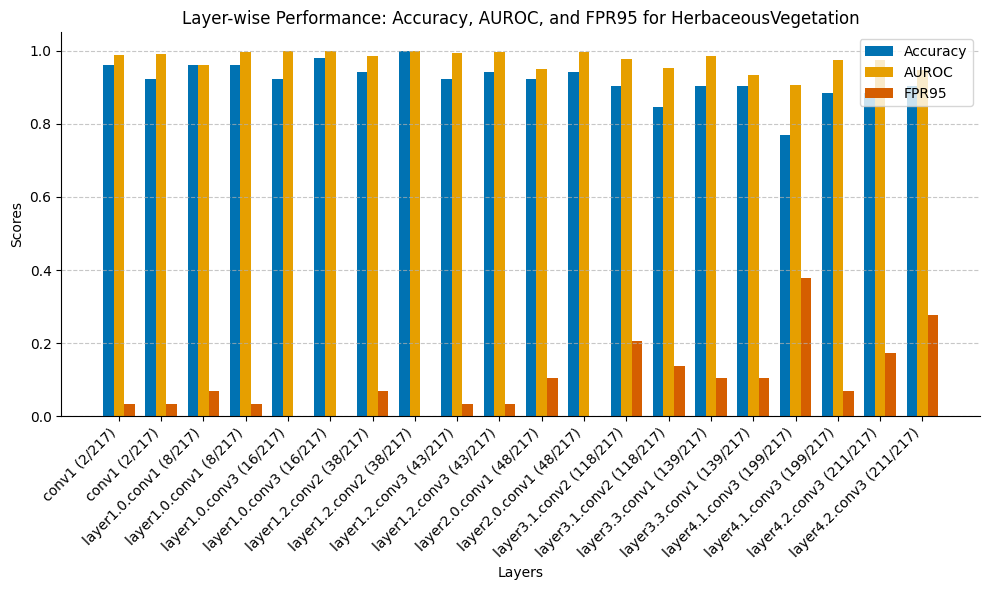

In [65]:
plot_layer_benchmark(layer_benchmark, all_layer_names, datamodule.class_name)

### g confidence interval

In [66]:
g_benchmark = run_multiple_experiments_g(
    X, y, test_size, n_estimators, random_seed=True
)

random_state for split_seed: 7250
random_state for split_seed: 1392
random_state for split_seed: 878
random_state for split_seed: 3916
random_state for split_seed: 751
random_state for split_seed: 2170
random_state for split_seed: 4239
random_state for split_seed: 2395
random_state for split_seed: 7814
random_state for split_seed: 3302


In [67]:
columns_of_interest = ["baseline_accuracy", "baseline_fpr95", "baseline_roc_auc"]
confidence_intervals_g = calculate_confidence_intervals(
    g_benchmark, columns_of_interest
)
confidence_intervals_g

{'baseline_accuracy': (0.8576923076923079, 0.022651297753886086),
 'baseline_fpr95': (0.2230326704779478, 0.07528602319583548),
 'baseline_roc_auc': (0.9270181170861456, 0.019890793142798027)}

### g_hat

In [68]:
results_df_g_hat = run_optuna_study(
    X,
    y,
    n_optuna_trials,
    test_size,
    min_cluster,
    max_cluster_ratio,
    min_fraction,
    max_fraction,
    n_estimators,
    fixed_seed,
)

[I 2024-12-22 18:14:58,656] A new study created in memory with name: no-name-1bbe420f-f9d9-422e-8444-68b5745c0602
[I 2024-12-22 18:14:58,778] Trial 0 finished with value: -0.7310854891661573 and parameters: {'k': 19, 'M': 0.19204005763861}. Best is trial 0 with value: -0.7310854891661573.
[I 2024-12-22 18:14:58,906] Trial 1 finished with value: -0.8821589158437229 and parameters: {'k': 48, 'M': 0.19750530058756796}. Best is trial 1 with value: -0.8821589158437229.
[I 2024-12-22 18:14:58,930] Trial 2 finished with value: inf and parameters: {'k': 14, 'M': 0.03601423928032735}. Best is trial 1 with value: -0.8821589158437229.
[I 2024-12-22 18:14:59,046] Trial 3 finished with value: -0.8463288626953708 and parameters: {'k': 56, 'M': 0.023041318415652854}. Best is trial 1 with value: -0.8821589158437229.
[I 2024-12-22 18:14:59,058] Trial 4 finished with value: inf and parameters: {'k': 6, 'M': 0.11327159100258942}. Best is trial 1 with value: -0.8821589158437229.
[I 2024-12-22 18:14:59,073

In [69]:
N = 10
results_dict = results_df_g_hat.to_dict(orient="records")
k = int(len(X) * 0.3)
M = results_dict[0]["M"]
print("k, M, len(X), k/len(X)", k, M, len(X), k / len(X))

g_hat_benchmark = run_multiple_experiments_g_hat(X, y, test_size, k, M, N, fixed_seed)

k, M, len(X), k/len(X) 76 0.15791334303625124 256 0.296875
random_state for split_seed in iteration 1: 9646
random_state for split_seed in iteration 2: 8373
random_state for split_seed in iteration 3: 3206
random_state for split_seed in iteration 4: 6724
random_state for split_seed in iteration 5: 1050
random_state for split_seed in iteration 6: 6989
random_state for split_seed in iteration 7: 1345
random_state for split_seed in iteration 8: 5685
random_state for split_seed in iteration 9: 6101
random_state for split_seed in iteration 10: 285


### g g_hat mean std + ttest

In [70]:
t_tests_results = perform_benchmark_analysis(g_benchmark, g_hat_benchmark)
t_tests_results

Baseline Accuracy: Mean = 0.8576923076923079, Std Dev = 0.03166433085956018
Baseline ROC AUC: Mean = 0.9270181170861456, Std Dev = 0.027805411503390498
Baseline FPR95: Mean = 0.2230326704779478, Std Dev = 0.10524260346913127
g_hat Accuracy: Mean = 0.7211538461538461, Std Dev = 0.05679501649573511
g_hat ROC AUC: Mean = 0.8420171570059125, Std Dev = 0.05100480890708568
g_hat FPR95: Mean = 0.5460698222317413, Std Dev = 0.16766025973321622
Accuracy: t = 6.640058660038062, p = 3.121455051715552e-06
ROC AUC: t = 4.627118872824943, p = 0.000209390355769351
FPR95: t = -5.160445325710142, p = 6.568939226838008e-05


{'accuracy': (6.640058660038062, 3.121455051715552e-06),
 'roc_auc': (4.627118872824943, 0.000209390355769351),
 'fpr95': (-5.160445325710142, 6.568939226838008e-05)}

### Benchmark g

In [72]:
classifier_benchmark_df = benchmark_classifiers(
    X, y, test_size, k, M, classifiers, fixed_seed
)

### Benchmark clustering

In [75]:
# A fixed classifier
classifier = classifiers['RandomForest']

clustering_benchmark_df = benchmark_clustering_methods(
    X, y, test_size, k, M, clustering_methods, classifier
)

clustering_benchmark_df

Clustering  Accuracy  ROC_AUC  FPR95  Clustering Time (s)  \
0          KMeans  0.461538      0.5    1.0             0.006140   
1  DBSCAN_eps_0.1  0.538462      0.5    1.0             0.005748   
2  DBSCAN_eps_0.2  0.538462      0.5    1.0             0.005298   
3  DBSCAN_eps_0.5  0.538462      0.5    1.0             0.005413   

   Classifier Training Time (s)  Number of Samples  
0                      0.091678                204  
1                      0.090292                204  
2                      0.093649                204  
3                      0.090832                204

### Investigate k wrt g-g_hat

confidence_intervals_g:  {'baseline_accuracy': (0.8576923076923079, 0.022651297753886086), 'baseline_fpr95': (0.2230326704779478, 0.07528602319583548), 'baseline_roc_auc': (0.9270181170861456, 0.019890793142798027)}
Max i: 7
k: 1
Skipping k=1 on run 1 due to single class in y_clusters.
Skipping k=1 on run 2 due to single class in y_clusters.
Skipping k=1 on run 3 due to single class in y_clusters.
Skipping k=1 on run 4 due to single class in y_clusters.
Skipping k=1 on run 5 due to single class in y_clusters.
Skipping k=1 on run 6 due to single class in y_clusters.
Skipping k=1 on run 7 due to single class in y_clusters.
Skipping k=1 on run 8 due to single class in y_clusters.
Skipping k=1 on run 9 due to single class in y_clusters.
Skipping k=1 on run 10 due to single class in y_clusters.
k: 2
Skipping k=2 on run 1 due to single class in y_clusters.
Skipping k=2 on run 2 due to single class in y_clusters.
Skipping k=2 on run 3 due to single class in y_clusters.
Skipping k=2 on run 4 d

/ws/geospatial-ood-detection/notebooks/../src/tardis/eurosat_xbd_utils.py:989: RuntimeWarning: Mean of empty slice
  mean = np.nanmean(values)
/ws/geospatial-ood-detection/notebooks/../src/tardis/eurosat_xbd_utils.py:990: SmallSampleWarning: One or more sample arguments is too small; all returned values will be NaN. See documentation for sample size requirements.
  sem = stats.sem(values, nan_policy="omit")
/ws/geospatial-ood-detection/notebooks/../src/tardis/eurosat_xbd_utils.py:989: RuntimeWarning: Mean of empty slice
  mean = np.nanmean(values)
/ws/geospatial-ood-detection/notebooks/../src/tardis/eurosat_xbd_utils.py:990: SmallSampleWarning: One or more sample arguments is too small; all returned values will be NaN. See documentation for sample size requirements.
  sem = stats.sem(values, nan_policy="omit")
/ws/geospatial-ood-detection/notebooks/../src/tardis/eurosat_xbd_utils.py:989: RuntimeWarning: Mean of empty slice
  mean = np.nanmean(values)
/ws/geospatial-ood-detection/notebo

Skipping k=8 on run 4 due to single class in y_clusters.
Skipping k=8 on run 8 due to single class in y_clusters.
Skipping k=8 on run 9 due to single class in y_clusters.
k: 16
k: 32
k: 64
k: 128
k: 204


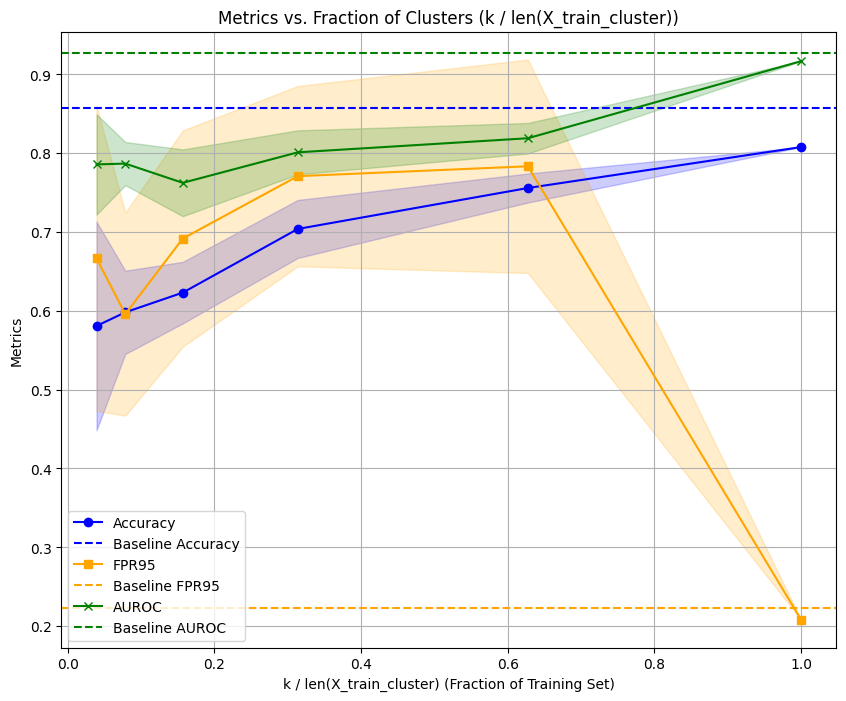

In [76]:
print("confidence_intervals_g: ", confidence_intervals_g)

df_results = benchmark_kmeans_with_varying_k_condidence_g_hat(
    X,
    y,
    M,
    test_size,
    n_runs=10,
    confidence_level=0.95,
    confidence_intervals_g=confidence_intervals_g,
    clf=None,
    save_plot=True,
    fname=cfg_dict["data"]["class_name"],
)

### Feature Level Visualization: Understand how clustering alters the structure of the feature space

Plotting
Proportion of label changes: 0.14


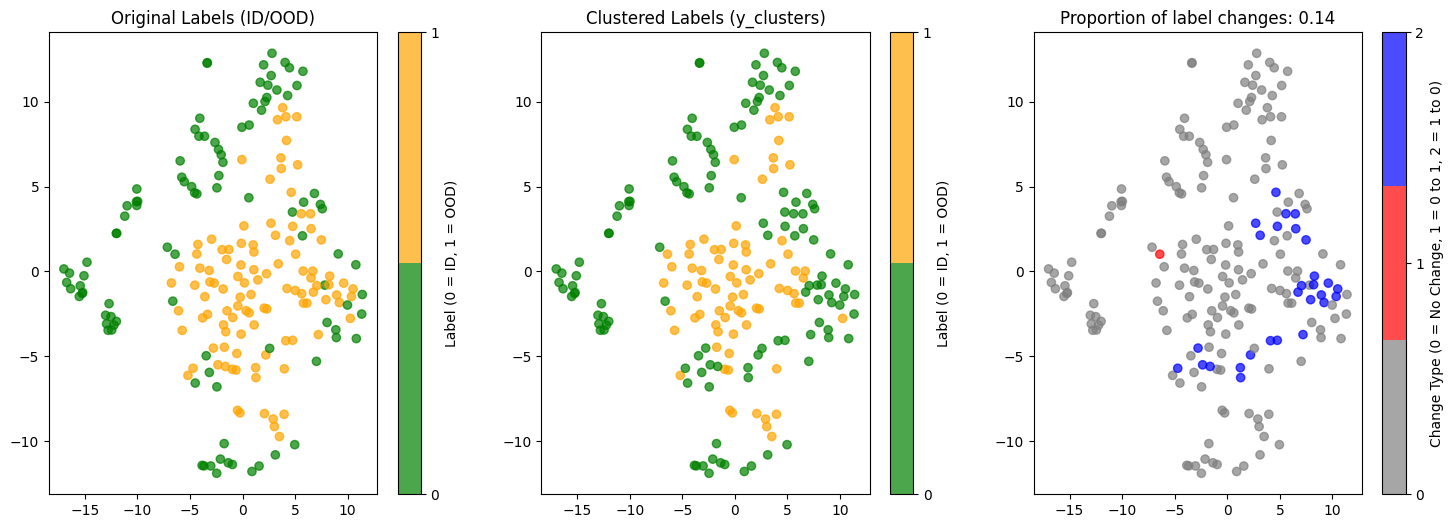

In [78]:
i = 0
_, X_train_cluster, y_train_cluster, y_clusters, *_ = run_g_hat_experiment(
    X, y, test_size, k, M, fixed_seed, fixed_seed, i + 1
)
plot_tsne_with_label_changes(
    X_train_cluster,
    y_train_cluster,
    y_clusters,
    class_name=cfg_dict.data.class_name,
    save_plot=True,
)

# Highway

### Start

In [84]:
X,y,model,datamodule,train_dataloader,val_dataloader,test_dataloader,cfg_dict = get_X_y_arrays(
        paths["highway"]["config"],
        paths["highway"]["ckpt"],
        layer,
        downsample_method,
        getitem_keys,
        device,
        n_batches_to_process,
        mode="holdout",
        verbose=False,
    )

Model and Task are loaded.
download True
Loaded statistics for Highway: MEAN={'B01': 1354.4053955078125, 'B02': 1118.2437744140625, 'B03': 1042.9300537109375, 'B04': 947.6260375976562, 'B05': 1199.4730224609375, 'B06': 1999.790771484375, 'B07': 2369.223388671875, 'B08': 2296.82568359375, 'B8A': 732.0834350585938, 'B09': 12.113272666931152, 'B10': 1819.0107421875, 'B11': 1118.923828125, 'B12': 2594.140380859375}, STD={'B01': 245.7180633544922, 'B02': 333.00836181640625, 'B03': 395.09320068359375, 'B04': 593.7514038085938, 'B05': 566.418212890625, 'B06': 861.1856079101562, 'B07': 1086.6331787109375, 'B08': 1117.983642578125, 'B8A': 404.9205627441406, 'B09': 4.775855541229248, 'B10': 1002.5894165039062, 'B11': 761.3047485351562, 'B12': 1231.58837890625}
self.split_urls {'train': 'https://huggingface.co/datasets/brkekm/EuroSATHoldOutSplits/resolve/main/train_highway.txt', 'val': 'https://huggingface.co/datasets/brkekm/EuroSATHoldOutSplits/resolve/main/val_highway.txt', 'test': 'https://hug

100%|██████████| 2067725275/2067725275 [00:09<00:00, 228474621.65it/s]


100%|██████████| 288291/288291 [00:00<00:00, 8862422.73it/s]


100%|██████████| 192746/192746 [00:00<00:00, 7304390.38it/s]


100%|██████████| 41393/41393 [00:00<00:00, 5104516.80it/s]


classes and class to idx ['SeaLake', 'Residential', 'PermanentCrop', 'Industrial', 'Pasture', 'Forest', 'AnnualCrop', 'HerbaceousVegetation', 'River'] {'AnnualCrop': 0, 'Forest': 1, 'HerbaceousVegetation': 2, 'Industrial': 3, 'Pasture': 4, 'PermanentCrop': 5, 'Residential': 6, 'River': 7, 'SeaLake': 8}
self.train_dataset.split_urls {'train': 'https://huggingface.co/datasets/brkekm/EuroSATHoldOutSplits/resolve/main/train_highway.txt', 'val': 'https://huggingface.co/datasets/brkekm/EuroSATHoldOutSplits/resolve/main/val_highway.txt', 'test': 'https://huggingface.co/datasets/brkekm/EuroSATHoldOutSplits/resolve/main/test_highway.txt'}
self.split_urls {'train': 'https://huggingface.co/datasets/brkekm/EuroSATHoldOutSplits/resolve/main/train_highway.txt', 'val': 'https://huggingface.co/datasets/brkekm/EuroSATHoldOutSplits/resolve/main/val_highway.txt', 'test': 'https://huggingface.co/datasets/brkekm/EuroSATHoldOutSplits/resolve/main/test_highway.txt'}
self.root /data/dataood/eurosat_holdout_da

100%|██████████| 2/2 [00:00<00:00,  6.83it/s]


Before downsampling, activations shape for layer conv1 : (128, 64, 32, 32)


100%|██████████| 2/2 [00:00<00:00,  7.02it/s]


Before downsampling, activations shape for layer conv1 : (128, 64, 32, 32)


### Downsample Benchmark

In [85]:
for downsample in downsample_methods:
    print(f"Running experiments for {downsample} downsample method.")
    X, y, test_property_lengths = create_feature_matrix_and_labels(
        model=model,
        dm=datamodule,
        train_dataloader=train_dataloader,
        test_dataloader=test_dataloader,
        layer_names=collect_activations_from_layers,
        device=device,
        getitem_keys=getitem_keys,
        n_batches_to_process=n_batches_to_process,
        downsample_method=downsample,
        verbose=verbose,
    )
    print("Run g experiment for downsample method:", downsample)
    g_benchmark = run_g_experiment(
        X, y, split_seed, test_size, n_estimators, fixed_classifier_seed, clf=None
    )
    dict_key = datamodule.class_name + "_" + downsample
    downsample_benchmark[dict_key] = g_benchmark

Running experiments for avg_pool downsample method.


100%|██████████| 2/2 [00:00<00:00,  7.03it/s]


Before downsampling, activations shape for layer conv1 : (128, 64, 32, 32)


100%|██████████| 2/2 [00:00<00:00,  7.06it/s]


Before downsampling, activations shape for layer conv1 : (128, 64, 32, 32)
Run g experiment for downsample method: avg_pool
Running experiments for mean_std downsample method.


100%|██████████| 2/2 [00:00<00:00,  6.61it/s]


Before downsampling, activations shape for layer conv1 : (128, 64, 32, 32)


100%|██████████| 2/2 [00:00<00:00,  6.71it/s]


Before downsampling, activations shape for layer conv1 : (128, 64, 32, 32)
Run g experiment for downsample method: mean_std
Running experiments for avg_pool downsample method.


100%|██████████| 2/2 [00:00<00:00,  6.74it/s]


Before downsampling, activations shape for layer conv1 : (128, 64, 32, 32)


100%|██████████| 2/2 [00:00<00:00,  6.91it/s]


Before downsampling, activations shape for layer conv1 : (128, 64, 32, 32)
Run g experiment for downsample method: avg_pool
Running experiments for max_pool downsample method.


100%|██████████| 2/2 [00:00<00:00,  6.77it/s]


Before downsampling, activations shape for layer conv1 : (128, 64, 32, 32)


100%|██████████| 2/2 [00:00<00:00,  7.06it/s]


Before downsampling, activations shape for layer conv1 : (128, 64, 32, 32)
Run g experiment for downsample method: max_pool
Running experiments for nodownsample downsample method.


100%|██████████| 2/2 [00:00<00:00,  7.03it/s]


Before downsampling, activations shape for layer conv1 : (128, 64, 32, 32)


100%|██████████| 2/2 [00:00<00:00,  6.93it/s]


Before downsampling, activations shape for layer conv1 : (128, 64, 32, 32)
Run g experiment for downsample method: nodownsample


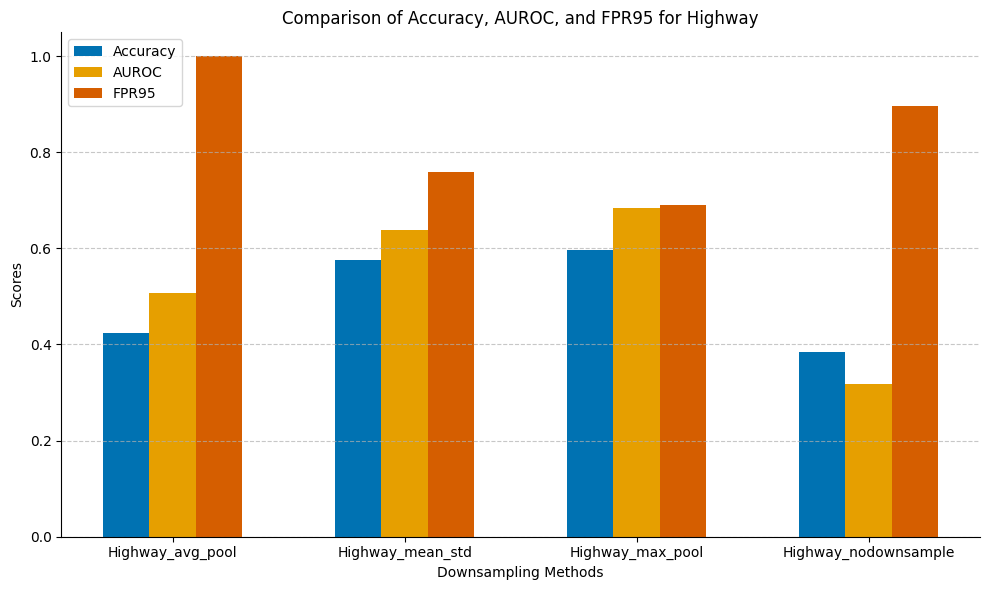

In [86]:
plot_downsample_benchmark(downsample_benchmark, datamodule.class_name)

### Layer Benchmark

In [87]:
for lyr in selected_layers:
    print(f"Running experiments for layer {lyr}")
    X, y, test_property_lengths = create_feature_matrix_and_labels(
        model=model,
        dm=datamodule,
        train_dataloader=train_dataloader,
        test_dataloader=test_dataloader,
        layer_names=lyr,
        device=device,
        getitem_keys=getitem_keys,
        n_batches_to_process=n_batches_to_process,
        downsample_method=downsample_method,
        verbose=verbose,
    )

    g_benchmark = run_g_experiment(
        X, y, split_seed, test_size, n_estimators, fixed_classifier_seed, clf=None
    )
    dict_key = datamodule.class_name + "_" + str(lyr)

    layer_benchmark[dict_key] = g_benchmark

Running experiments for layer ['conv1']


100%|██████████| 2/2 [00:00<00:00,  6.80it/s]


Before downsampling, activations shape for layer conv1 : (128, 64, 32, 32)


100%|██████████| 2/2 [00:00<00:00,  6.75it/s]


Before downsampling, activations shape for layer conv1 : (128, 64, 32, 32)
Running experiments for layer ['layer1.0.conv1']


100%|██████████| 2/2 [00:00<00:00,  7.22it/s]


Before downsampling, activations shape for layer layer1.0.conv1 : (128, 64, 16, 16)


100%|██████████| 2/2 [00:00<00:00,  7.08it/s]


Before downsampling, activations shape for layer layer1.0.conv1 : (128, 64, 16, 16)
Running experiments for layer ['layer3.3.conv1']


100%|██████████| 2/2 [00:00<00:00,  7.35it/s]


Before downsampling, activations shape for layer layer3.3.conv1 : (128, 256, 4, 4)


100%|██████████| 2/2 [00:00<00:00,  7.33it/s]


Before downsampling, activations shape for layer layer3.3.conv1 : (128, 256, 4, 4)
Running experiments for layer ['layer1.2.conv2']


100%|██████████| 2/2 [00:00<00:00,  6.72it/s]


Before downsampling, activations shape for layer layer1.2.conv2 : (128, 64, 16, 16)


100%|██████████| 2/2 [00:00<00:00,  7.43it/s]


Before downsampling, activations shape for layer layer1.2.conv2 : (128, 64, 16, 16)
Running experiments for layer ['layer3.1.conv2']


100%|██████████| 2/2 [00:00<00:00,  7.53it/s]


Before downsampling, activations shape for layer layer3.1.conv2 : (128, 256, 4, 4)


100%|██████████| 2/2 [00:00<00:00,  6.80it/s]


Before downsampling, activations shape for layer layer3.1.conv2 : (128, 256, 4, 4)
Running experiments for layer ['layer2.0.conv1']


100%|██████████| 2/2 [00:00<00:00,  6.69it/s]


Before downsampling, activations shape for layer layer2.0.conv1 : (128, 128, 16, 16)


100%|██████████| 2/2 [00:00<00:00,  7.18it/s]


Before downsampling, activations shape for layer layer2.0.conv1 : (128, 128, 16, 16)
Running experiments for layer ['layer1.0.conv3']


100%|██████████| 2/2 [00:00<00:00,  7.10it/s]


Before downsampling, activations shape for layer layer1.0.conv3 : (128, 256, 16, 16)


100%|██████████| 2/2 [00:00<00:00,  6.93it/s]


Before downsampling, activations shape for layer layer1.0.conv3 : (128, 256, 16, 16)
Running experiments for layer ['layer1.2.conv3']


100%|██████████| 2/2 [00:00<00:00,  6.90it/s]


Before downsampling, activations shape for layer layer1.2.conv3 : (128, 256, 16, 16)


100%|██████████| 2/2 [00:00<00:00,  6.67it/s]


Before downsampling, activations shape for layer layer1.2.conv3 : (128, 256, 16, 16)
Running experiments for layer ['layer4.1.conv3']


100%|██████████| 2/2 [00:00<00:00,  7.08it/s]


Before downsampling, activations shape for layer layer4.1.conv3 : (128, 2048, 2, 2)


100%|██████████| 2/2 [00:00<00:00,  7.11it/s]


Before downsampling, activations shape for layer layer4.1.conv3 : (128, 2048, 2, 2)
Running experiments for layer ['layer4.2.conv3']


100%|██████████| 2/2 [00:00<00:00,  6.94it/s]


Before downsampling, activations shape for layer layer4.2.conv3 : (128, 2048, 2, 2)


100%|██████████| 2/2 [00:00<00:00,  6.81it/s]


Before downsampling, activations shape for layer layer4.2.conv3 : (128, 2048, 2, 2)


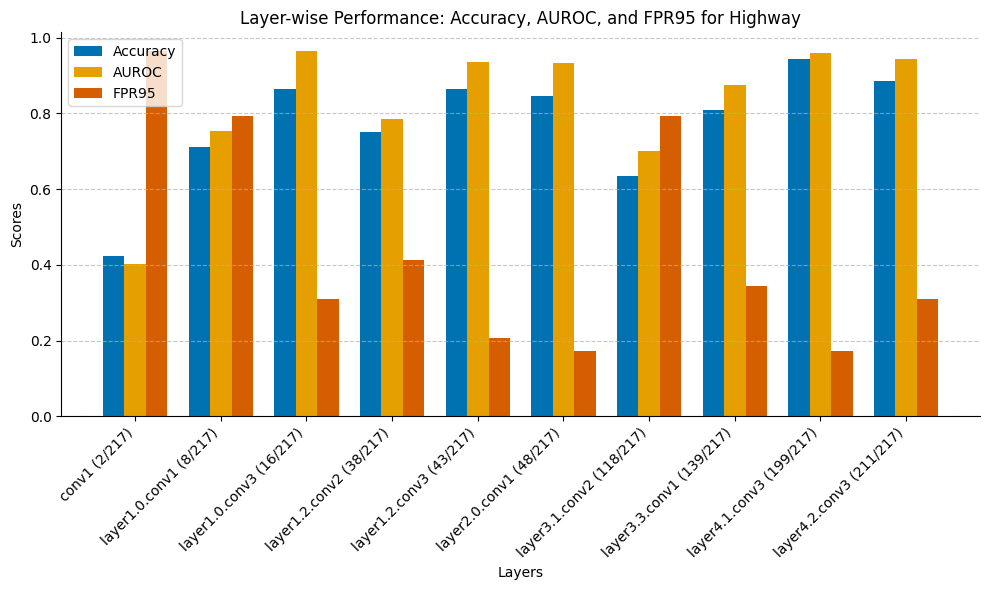

In [88]:
plot_layer_benchmark(layer_benchmark, all_layer_names, datamodule.class_name)

### g confidence interval

In [89]:
g_benchmark = run_multiple_experiments_g(
    X, y, test_size, n_estimators, random_seed=True
)

random_state for split_seed: 6618
random_state for split_seed: 1403
random_state for split_seed: 5503
random_state for split_seed: 4794
random_state for split_seed: 3221
random_state for split_seed: 7587
random_state for split_seed: 2019
random_state for split_seed: 5123
random_state for split_seed: 1475
random_state for split_seed: 1858


In [ ]:
columns_of_interest = ["baseline_accuracy", "baseline_fpr95", "baseline_roc_auc"]
confidence_intervals_g = calculate_confidence_intervals(
    g_benchmark, columns_of_interest
)
confidence_intervals_g

### g_hat

In [90]:
results_df_g_hat = run_optuna_study(
    X,
    y,
    n_optuna_trials,
    test_size,
    min_cluster,
    max_cluster_ratio,
    min_fraction,
    max_fraction,
    n_estimators,
    fixed_seed,
)

[I 2024-12-22 18:31:06,414] A new study created in memory with name: no-name-29099eef-0df9-44f0-a073-e2918d923350
[I 2024-12-22 18:31:06,483] Trial 0 finished with value: -0.7429746283593224 and parameters: {'k': 19, 'M': 0.19204005763861}. Best is trial 0 with value: -0.7429746283593224.
[I 2024-12-22 18:31:06,670] Trial 1 finished with value: -0.8512329499027291 and parameters: {'k': 48, 'M': 0.19750530058756796}. Best is trial 1 with value: -0.8512329499027291.
[I 2024-12-22 18:31:06,734] Trial 2 finished with value: -0.6704806121020467 and parameters: {'k': 14, 'M': 0.03601423928032735}. Best is trial 1 with value: -0.8512329499027291.
[I 2024-12-22 18:31:06,860] Trial 3 finished with value: -0.8966919222459457 and parameters: {'k': 56, 'M': 0.023041318415652854}. Best is trial 3 with value: -0.8966919222459457.
[I 2024-12-22 18:31:06,874] Trial 4 finished with value: inf and parameters: {'k': 6, 'M': 0.11327159100258942}. Best is trial 3 with value: -0.8966919222459457.
[I 2024-12

In [91]:
N = 10
results_dict = results_df_g_hat.to_dict(orient="records")
k = int(len(X) * 0.3)
M = results_dict[0]["M"]
print("k, M, len(X), k/len(X)", k, M, len(X), k / len(X))

g_hat_benchmark = run_multiple_experiments_g_hat(X, y, test_size, k, M, N, fixed_seed)

k, M, len(X), k/len(X) 76 0.14224922508301596 256 0.296875
random_state for split_seed in iteration 1: 7454
random_state for split_seed in iteration 2: 8533
random_state for split_seed in iteration 3: 8084
random_state for split_seed in iteration 4: 1714
random_state for split_seed in iteration 5: 1364
random_state for split_seed in iteration 6: 1663
random_state for split_seed in iteration 7: 9980
random_state for split_seed in iteration 8: 7797
random_state for split_seed in iteration 9: 8977
random_state for split_seed in iteration 10: 1832


### g g_hat mean std + ttest

In [92]:
t_tests_results = perform_benchmark_analysis(g_benchmark, g_hat_benchmark)
t_tests_results

Baseline Accuracy: Mean = 0.8903846153846153, Std Dev = 0.02873911765571784
Baseline ROC AUC: Mean = 0.9667827326181466, Std Dev = 0.015804857448259862
Baseline FPR95: Mean = 0.14566588073484626, Std Dev = 0.08481514755636003
g_hat Accuracy: Mean = 0.8076923076923077, Std Dev = 0.07475579352365769
g_hat ROC AUC: Mean = 0.915336898469441, Std Dev = 0.054261568423807284
g_hat FPR95: Mean = 0.35506500626145543, Std Dev = 0.18289197831643617
Accuracy: t = 3.2650381399139685, p = 0.0043005041402455965
ROC AUC: t = 2.878559354907352, p = 0.009997436865390655
FPR95: t = -3.284592758004399, p = 0.004118996787048112


{'accuracy': (3.2650381399139685, 0.0043005041402455965),
 'roc_auc': (2.878559354907352, 0.009997436865390655),
 'fpr95': (-3.284592758004399, 0.004118996787048112)}

### Benchmark g

In [93]:
classifier_benchmark_df = benchmark_classifiers(
    X, y, test_size, k, M, classifiers, fixed_seed
)

classifier_benchmark_df

### Benchmark clustering

In [94]:
# A fixed classifier
classifier = classifiers['RandomForest']

clustering_benchmark_df = benchmark_clustering_methods(
    X, y, test_size, k, M, clustering_methods, classifier
)

clustering_benchmark_df

Clustering  Accuracy  ROC_AUC  FPR95  Clustering Time (s)  \
0          KMeans  0.461538      0.5    1.0             0.007013   
1  DBSCAN_eps_0.1  0.538462      0.5    1.0             0.005826   
2  DBSCAN_eps_0.2  0.538462      0.5    1.0             0.005240   
3  DBSCAN_eps_0.5  0.538462      0.5    1.0             0.005222   

   Classifier Training Time (s)  Number of Samples  
0                      0.094565                204  
1                      0.092291                204  
2                      0.091350                204  
3                      0.091974                204

### Investigate k wrt g-g_hat

confidence_intervals_g:  {'baseline_accuracy': (0.8576923076923079, 0.022651297753886086), 'baseline_fpr95': (0.2230326704779478, 0.07528602319583548), 'baseline_roc_auc': (0.9270181170861456, 0.019890793142798027)}
Max i: 7
k: 1
Skipping k=1 on run 1 due to single class in y_clusters.
Skipping k=1 on run 2 due to single class in y_clusters.
Skipping k=1 on run 3 due to single class in y_clusters.
Skipping k=1 on run 4 due to single class in y_clusters.
Skipping k=1 on run 5 due to single class in y_clusters.
Skipping k=1 on run 6 due to single class in y_clusters.
Skipping k=1 on run 7 due to single class in y_clusters.
Skipping k=1 on run 8 due to single class in y_clusters.
Skipping k=1 on run 9 due to single class in y_clusters.
Skipping k=1 on run 10 due to single class in y_clusters.
k: 2
Skipping k=2 on run 1 due to single class in y_clusters.
Skipping k=2 on run 2 due to single class in y_clusters.
Skipping k=2 on run 3 due to single class in y_clusters.
Skipping k=2 on run 4 d

/ws/geospatial-ood-detection/notebooks/../src/tardis/eurosat_xbd_utils.py:989: RuntimeWarning: Mean of empty slice
  mean = np.nanmean(values)
/ws/geospatial-ood-detection/notebooks/../src/tardis/eurosat_xbd_utils.py:990: SmallSampleWarning: One or more sample arguments is too small; all returned values will be NaN. See documentation for sample size requirements.
  sem = stats.sem(values, nan_policy="omit")
/ws/geospatial-ood-detection/notebooks/../src/tardis/eurosat_xbd_utils.py:989: RuntimeWarning: Mean of empty slice
  mean = np.nanmean(values)
/ws/geospatial-ood-detection/notebooks/../src/tardis/eurosat_xbd_utils.py:990: SmallSampleWarning: One or more sample arguments is too small; all returned values will be NaN. See documentation for sample size requirements.
  sem = stats.sem(values, nan_policy="omit")
/ws/geospatial-ood-detection/notebooks/../src/tardis/eurosat_xbd_utils.py:989: RuntimeWarning: Mean of empty slice
  mean = np.nanmean(values)
/ws/geospatial-ood-detection/notebo

Skipping k=8 on run 4 due to single class in y_clusters.
Skipping k=8 on run 5 due to single class in y_clusters.
Skipping k=8 on run 7 due to single class in y_clusters.
Skipping k=8 on run 9 due to single class in y_clusters.
Skipping k=8 on run 10 due to single class in y_clusters.
k: 16
k: 32
k: 64
k: 128
k: 204


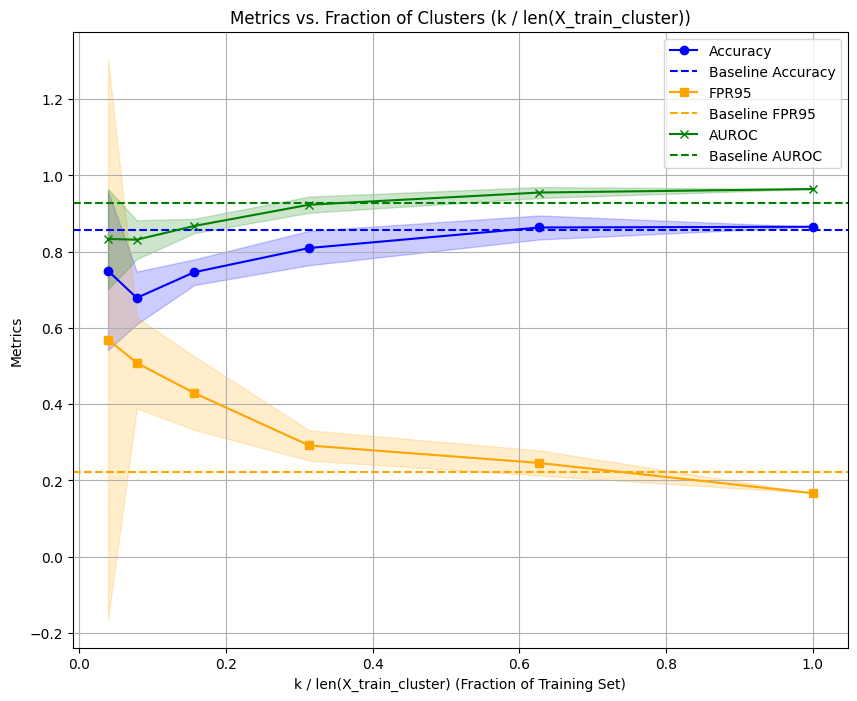

In [95]:
print("confidence_intervals_g: ", confidence_intervals_g)

df_results = benchmark_kmeans_with_varying_k_condidence_g_hat(
    X,
    y,
    M,
    test_size,
    n_runs=10,
    confidence_level=0.95,
    confidence_intervals_g=confidence_intervals_g,
    clf=None,
    save_plot=True,
    fname=cfg_dict["data"]["class_name"],
)

### Feature Level Visualization: Understand how clustering alters the structure of the feature space

Proportion of label changes: 0.07


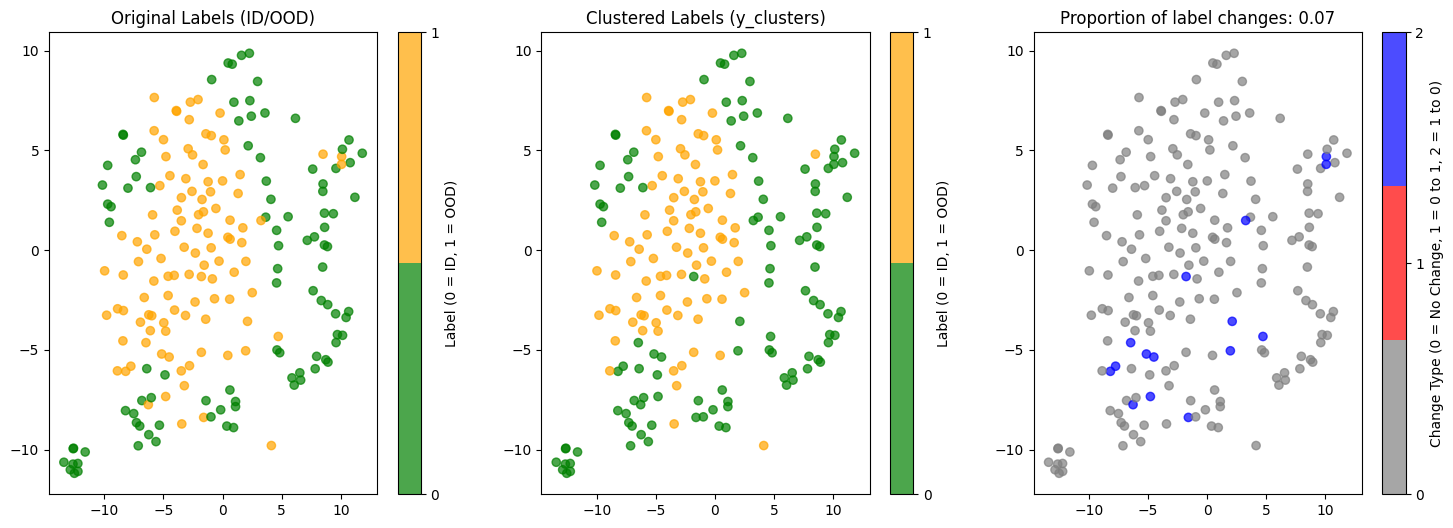

In [96]:
i = 0
_, X_train_cluster, y_train_cluster, y_clusters, *_ = run_g_hat_experiment(
    X, y, test_size, k, M, fixed_seed, fixed_seed, i + 1
)
plot_tsne_with_label_changes(
    X_train_cluster,
    y_train_cluster,
    y_clusters,
    class_name=cfg_dict.data.class_name,
    save_plot=True,
)

# Industrial

### Start

In [100]:
X,y,model,datamodule,train_dataloader,val_dataloader,test_dataloader,cfg_dict = get_X_y_arrays(
        paths["industrial"]["config"],
        paths["industrial"]["ckpt"],
        layer,
        downsample_method,
        getitem_keys,
        device,
        n_batches_to_process,
        mode="holdout",
        verbose=False,
    )

Model and Task are loaded.
download True
Loaded statistics for Industrial: MEAN={'B01': 1354.4063720703125, 'B02': 1118.2437744140625, 'B03': 1042.9295654296875, 'B04': 947.6263427734375, 'B05': 1199.47265625, 'B06': 1999.791015625, 'B07': 2369.22265625, 'B08': 2296.825927734375, 'B8A': 732.083740234375, 'B09': 12.113276481628418, 'B10': 1819.010986328125, 'B11': 1118.9239501953125, 'B12': 2594.14013671875}, STD={'B01': 245.71812438964844, 'B02': 333.00848388671875, 'B03': 395.09332275390625, 'B04': 593.7515258789062, 'B05': 566.4180297851562, 'B06': 861.1857299804688, 'B07': 1086.6336669921875, 'B08': 1117.9835205078125, 'B8A': 404.9205017089844, 'B09': 4.775853633880615, 'B10': 1002.5897216796875, 'B11': 761.304443359375, 'B12': 1231.5877685546875}
self.split_urls {'train': 'https://huggingface.co/datasets/brkekm/EuroSATHoldOutSplits/resolve/main/train_industrial.txt', 'val': 'https://huggingface.co/datasets/brkekm/EuroSATHoldOutSplits/resolve/main/val_industrial.txt', 'test': 'https

100%|██████████| 2067725275/2067725275 [00:09<00:00, 222362497.18it/s]


100%|██████████| 283787/283787 [00:00<00:00, 8847955.80it/s]


100%|██████████| 189750/189750 [00:00<00:00, 8872961.83it/s]


100%|██████████| 48893/48893 [00:00<00:00, 7366095.74it/s]


classes and class to idx ['SeaLake', 'Residential', 'PermanentCrop', 'Pasture', 'Forest', 'AnnualCrop', 'HerbaceousVegetation', 'River', 'Highway'] {'AnnualCrop': 0, 'Forest': 1, 'HerbaceousVegetation': 2, 'Highway': 3, 'Pasture': 4, 'PermanentCrop': 5, 'Residential': 6, 'River': 7, 'SeaLake': 8}
self.train_dataset.split_urls {'train': 'https://huggingface.co/datasets/brkekm/EuroSATHoldOutSplits/resolve/main/train_industrial.txt', 'val': 'https://huggingface.co/datasets/brkekm/EuroSATHoldOutSplits/resolve/main/val_industrial.txt', 'test': 'https://huggingface.co/datasets/brkekm/EuroSATHoldOutSplits/resolve/main/test_industrial.txt'}
self.split_urls {'train': 'https://huggingface.co/datasets/brkekm/EuroSATHoldOutSplits/resolve/main/train_industrial.txt', 'val': 'https://huggingface.co/datasets/brkekm/EuroSATHoldOutSplits/resolve/main/val_industrial.txt', 'test': 'https://huggingface.co/datasets/brkekm/EuroSATHoldOutSplits/resolve/main/test_industrial.txt'}
self.root /data/dataood/eurosa

100%|██████████| 2/2 [00:00<00:00,  6.79it/s]


Before downsampling, activations shape for layer conv1 : (128, 64, 32, 32)


100%|██████████| 2/2 [00:00<00:00,  6.43it/s]


Before downsampling, activations shape for layer conv1 : (128, 64, 32, 32)


### Downsample Benchmark

In [101]:
for downsample in downsample_methods:
    print(f"Running experiments for {downsample} downsample method.")
    X, y, test_property_lengths = create_feature_matrix_and_labels(
        model=model,
        dm=datamodule,
        train_dataloader=train_dataloader,
        test_dataloader=test_dataloader,
        layer_names=collect_activations_from_layers,
        device=device,
        getitem_keys=getitem_keys,
        n_batches_to_process=n_batches_to_process,
        downsample_method=downsample,
        verbose=verbose,
    )
    print("Run g experiment for downsample method:", downsample)
    g_benchmark = run_g_experiment(
        X, y, split_seed, test_size, n_estimators, fixed_classifier_seed, clf=None
    )
    dict_key = datamodule.class_name + "_" + downsample
    downsample_benchmark[dict_key] = g_benchmark

Running experiments for avg_pool downsample method.


100%|██████████| 2/2 [00:00<00:00,  6.89it/s]


Before downsampling, activations shape for layer conv1 : (128, 64, 32, 32)


100%|██████████| 2/2 [00:00<00:00,  6.48it/s]


Before downsampling, activations shape for layer conv1 : (128, 64, 32, 32)
Run g experiment for downsample method: avg_pool
Running experiments for mean_std downsample method.


100%|██████████| 2/2 [00:00<00:00,  6.93it/s]


Before downsampling, activations shape for layer conv1 : (128, 64, 32, 32)


100%|██████████| 2/2 [00:00<00:00,  6.54it/s]


Before downsampling, activations shape for layer conv1 : (128, 64, 32, 32)
Run g experiment for downsample method: mean_std
Running experiments for avg_pool downsample method.


100%|██████████| 2/2 [00:00<00:00,  6.74it/s]


Before downsampling, activations shape for layer conv1 : (128, 64, 32, 32)


100%|██████████| 2/2 [00:00<00:00,  6.64it/s]


Before downsampling, activations shape for layer conv1 : (128, 64, 32, 32)
Run g experiment for downsample method: avg_pool
Running experiments for max_pool downsample method.


100%|██████████| 2/2 [00:00<00:00,  6.96it/s]


Before downsampling, activations shape for layer conv1 : (128, 64, 32, 32)


100%|██████████| 2/2 [00:00<00:00,  6.95it/s]


Before downsampling, activations shape for layer conv1 : (128, 64, 32, 32)
Run g experiment for downsample method: max_pool
Running experiments for nodownsample downsample method.


100%|██████████| 2/2 [00:00<00:00,  6.67it/s]


Before downsampling, activations shape for layer conv1 : (128, 64, 32, 32)


100%|██████████| 2/2 [00:00<00:00,  6.92it/s]


Before downsampling, activations shape for layer conv1 : (128, 64, 32, 32)
Run g experiment for downsample method: nodownsample


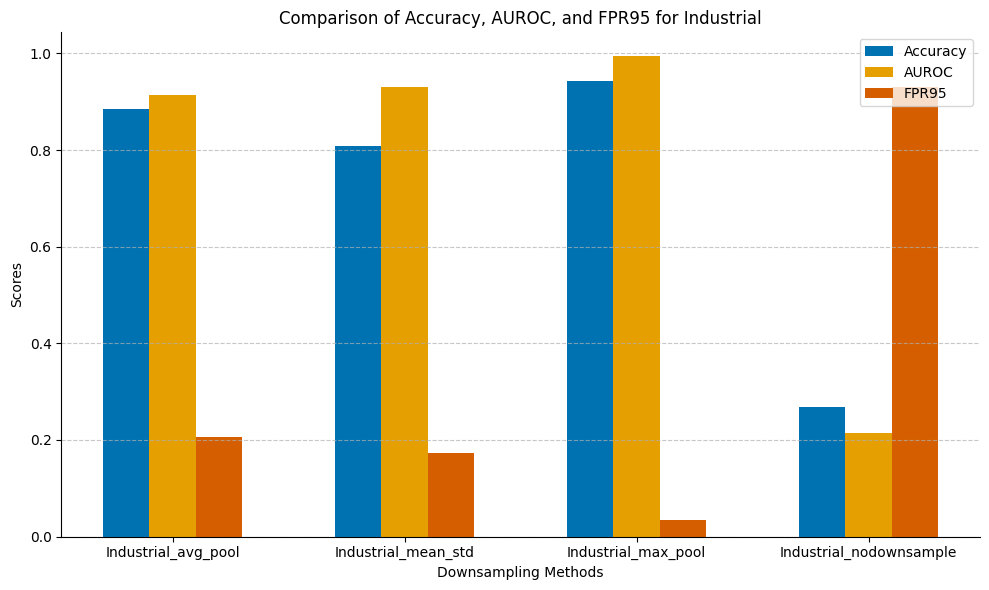

In [102]:
plot_downsample_benchmark(downsample_benchmark, datamodule.class_name)

### Layer Benchmark

In [103]:
for lyr in selected_layers:
    print(f"Running experiments for layer {lyr}")
    X, y, test_property_lengths = create_feature_matrix_and_labels(
        model=model,
        dm=datamodule,
        train_dataloader=train_dataloader,
        test_dataloader=test_dataloader,
        layer_names=lyr,
        device=device,
        getitem_keys=getitem_keys,
        n_batches_to_process=n_batches_to_process,
        downsample_method=downsample_method,
        verbose=verbose,
    )

    g_benchmark = run_g_experiment(
        X, y, split_seed, test_size, n_estimators, fixed_classifier_seed, clf=None
    )
    dict_key = datamodule.class_name + "_" + str(lyr)

    layer_benchmark[dict_key] = g_benchmark

Running experiments for layer ['conv1']


100%|██████████| 2/2 [00:00<00:00,  6.89it/s]


Before downsampling, activations shape for layer conv1 : (128, 64, 32, 32)


100%|██████████| 2/2 [00:00<00:00,  6.74it/s]


Before downsampling, activations shape for layer conv1 : (128, 64, 32, 32)
Running experiments for layer ['layer1.0.conv1']


100%|██████████| 2/2 [00:00<00:00,  6.77it/s]


Before downsampling, activations shape for layer layer1.0.conv1 : (128, 64, 16, 16)


100%|██████████| 2/2 [00:00<00:00,  7.40it/s]


Before downsampling, activations shape for layer layer1.0.conv1 : (128, 64, 16, 16)
Running experiments for layer ['layer3.3.conv1']


100%|██████████| 2/2 [00:00<00:00,  6.87it/s]


Before downsampling, activations shape for layer layer3.3.conv1 : (128, 256, 4, 4)


100%|██████████| 2/2 [00:00<00:00,  7.50it/s]


Before downsampling, activations shape for layer layer3.3.conv1 : (128, 256, 4, 4)
Running experiments for layer ['layer1.2.conv2']


100%|██████████| 2/2 [00:00<00:00,  7.01it/s]


Before downsampling, activations shape for layer layer1.2.conv2 : (128, 64, 16, 16)


100%|██████████| 2/2 [00:00<00:00,  7.17it/s]


Before downsampling, activations shape for layer layer1.2.conv2 : (128, 64, 16, 16)
Running experiments for layer ['layer3.1.conv2']


100%|██████████| 2/2 [00:00<00:00,  7.41it/s]


Before downsampling, activations shape for layer layer3.1.conv2 : (128, 256, 4, 4)


100%|██████████| 2/2 [00:00<00:00,  7.18it/s]


Before downsampling, activations shape for layer layer3.1.conv2 : (128, 256, 4, 4)
Running experiments for layer ['layer2.0.conv1']


100%|██████████| 2/2 [00:00<00:00,  6.76it/s]


Before downsampling, activations shape for layer layer2.0.conv1 : (128, 128, 16, 16)


100%|██████████| 2/2 [00:00<00:00,  6.80it/s]


Before downsampling, activations shape for layer layer2.0.conv1 : (128, 128, 16, 16)
Running experiments for layer ['layer1.0.conv3']


100%|██████████| 2/2 [00:00<00:00,  6.60it/s]


Before downsampling, activations shape for layer layer1.0.conv3 : (128, 256, 16, 16)


100%|██████████| 2/2 [00:00<00:00,  7.14it/s]


Before downsampling, activations shape for layer layer1.0.conv3 : (128, 256, 16, 16)
Running experiments for layer ['layer1.2.conv3']


100%|██████████| 2/2 [00:00<00:00,  6.41it/s]


Before downsampling, activations shape for layer layer1.2.conv3 : (128, 256, 16, 16)


100%|██████████| 2/2 [00:00<00:00,  6.78it/s]


Before downsampling, activations shape for layer layer1.2.conv3 : (128, 256, 16, 16)
Running experiments for layer ['layer4.1.conv3']


100%|██████████| 2/2 [00:00<00:00,  7.25it/s]


Before downsampling, activations shape for layer layer4.1.conv3 : (128, 2048, 2, 2)


100%|██████████| 2/2 [00:00<00:00,  7.43it/s]


Before downsampling, activations shape for layer layer4.1.conv3 : (128, 2048, 2, 2)
Running experiments for layer ['layer4.2.conv3']


100%|██████████| 2/2 [00:00<00:00,  7.44it/s]


Before downsampling, activations shape for layer layer4.2.conv3 : (128, 2048, 2, 2)


100%|██████████| 2/2 [00:00<00:00,  7.25it/s]


Before downsampling, activations shape for layer layer4.2.conv3 : (128, 2048, 2, 2)


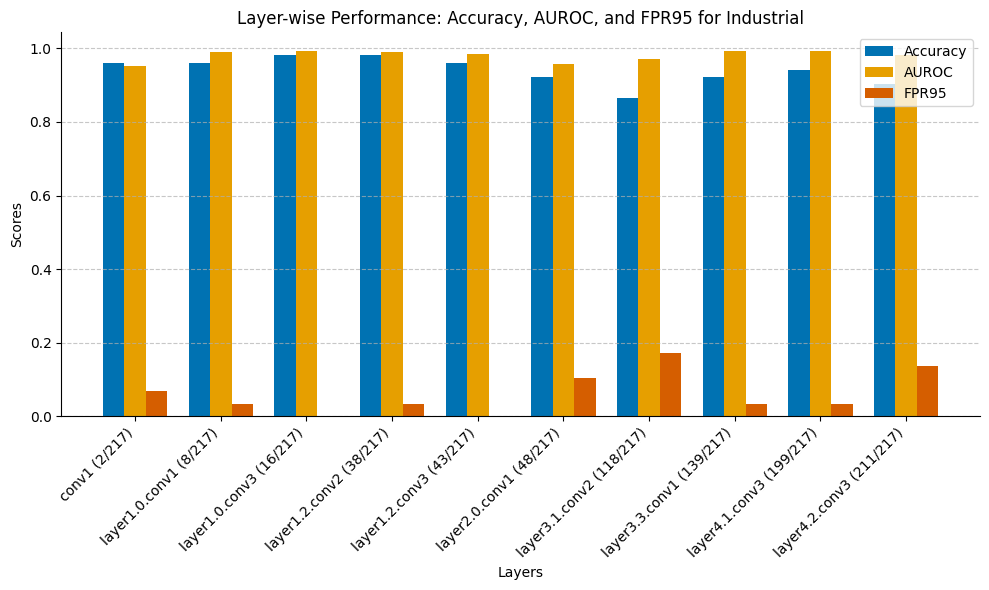

In [104]:
plot_layer_benchmark(layer_benchmark, all_layer_names, datamodule.class_name)

### g confidence interval

In [105]:
g_benchmark = run_multiple_experiments_g(
    X, y, test_size, n_estimators, random_seed=True
)

random_state for split_seed: 7113
random_state for split_seed: 4886
random_state for split_seed: 6699
random_state for split_seed: 2670
random_state for split_seed: 6717
random_state for split_seed: 9439
random_state for split_seed: 4639
random_state for split_seed: 6
random_state for split_seed: 2901
random_state for split_seed: 4963


In [106]:
columns_of_interest = ["baseline_accuracy", "baseline_fpr95", "baseline_roc_auc"]
confidence_intervals_g = calculate_confidence_intervals(
    g_benchmark, columns_of_interest
)
confidence_intervals_g

{'baseline_accuracy': (0.9384615384615383, 0.02320161192670869),
 'baseline_fpr95': (0.04698148148148148, 0.04356630984583421),
 'baseline_roc_auc': (0.9891634996170083, 0.007200084716722362)}

### g_hat

In [107]:
results_df_g_hat = run_optuna_study(
    X,
    y,
    n_optuna_trials,
    test_size,
    min_cluster,
    max_cluster_ratio,
    min_fraction,
    max_fraction,
    n_estimators,
    fixed_seed,
)

[I 2024-12-22 18:34:01,153] A new study created in memory with name: no-name-75f81f62-6a14-4845-958a-9127ce7bfa22
[I 2024-12-22 18:34:01,231] Trial 0 finished with value: -0.7898083816960432 and parameters: {'k': 19, 'M': 0.19204005763861}. Best is trial 0 with value: -0.7898083816960432.
[I 2024-12-22 18:34:01,411] Trial 1 finished with value: -0.8983095243154937 and parameters: {'k': 48, 'M': 0.19750530058756796}. Best is trial 1 with value: -0.8983095243154937.
[I 2024-12-22 18:34:01,468] Trial 2 finished with value: -0.802540362083384 and parameters: {'k': 14, 'M': 0.03601423928032735}. Best is trial 1 with value: -0.8983095243154937.
[I 2024-12-22 18:34:01,589] Trial 3 finished with value: -0.8995342072154351 and parameters: {'k': 56, 'M': 0.023041318415652854}. Best is trial 3 with value: -0.8995342072154351.
[I 2024-12-22 18:34:01,602] Trial 4 finished with value: inf and parameters: {'k': 6, 'M': 0.11327159100258942}. Best is trial 3 with value: -0.8995342072154351.
[I 2024-12-

In [108]:
N = 10
results_dict = results_df_g_hat.to_dict(orient="records")
k = int(len(X) * 0.3)
M = results_dict[0]["M"]
print("k, M, len(X), k/len(X)", k, M, len(X), k / len(X))

g_hat_benchmark = run_multiple_experiments_g_hat(X, y, test_size, k, M, N, fixed_seed)

k, M, len(X), k/len(X) 76 0.12942942912679828 256 0.296875
random_state for split_seed in iteration 1: 8188
random_state for split_seed in iteration 2: 7789
random_state for split_seed in iteration 3: 6947
random_state for split_seed in iteration 4: 8879
random_state for split_seed in iteration 5: 256
random_state for split_seed in iteration 6: 6906
random_state for split_seed in iteration 7: 6862
random_state for split_seed in iteration 8: 2078
random_state for split_seed in iteration 9: 2702
random_state for split_seed in iteration 10: 9638


### g g_hat mean std + ttest

In [109]:
t_tests_results = perform_benchmark_analysis(g_benchmark, g_hat_benchmark)
t_tests_results

Baseline Accuracy: Mean = 0.9384615384615383, Std Dev = 0.03243361702736797
Baseline ROC AUC: Mean = 0.9891634996170083, Std Dev = 0.010065024404530904
Baseline FPR95: Mean = 0.04698148148148148, Std Dev = 0.06090150172750876
g_hat Accuracy: Mean = 0.8115384615384615, Std Dev = 0.04948784375799687
g_hat ROC AUC: Mean = 0.9064322031245109, Std Dev = 0.05412382322606348
g_hat FPR95: Mean = 0.4018954008954009, Std Dev = 0.2331063032581026
Accuracy: t = 6.783368227292558, p = 2.3593332352145293e-06
ROC AUC: t = 4.752245415727501, p = 0.00015916669954361626
FPR95: t = -4.6583392866789515, p = 0.0001955189338929859


{'accuracy': (6.783368227292558, 2.3593332352145293e-06),
 'roc_auc': (4.752245415727501, 0.00015916669954361626),
 'fpr95': (-4.6583392866789515, 0.0001955189338929859)}

### Benchmark g

In [110]:
classifier_benchmark_df = benchmark_classifiers(
    X, y, test_size, k, M, classifiers, fixed_seed
)

classifier_benchmark_df

Classifier  Accuracy   ROC_AUC     FPR95  \
0  RandomForestUnblanaced  0.826923  0.916792  0.379310   
1            RandomForest  0.807692  0.937781  0.310345   
2                     SVC  0.884615  0.913043  0.275862   
3              KNeighbors  0.807692  0.852324  1.000000   
4      LogisticRegression  0.884615  0.950525  0.275862   
5            DecisionTree  0.769231  0.748126  1.000000   
6        GradientBoosting  0.788462  0.877061  0.517241   
7                AdaBoost  0.788462  0.905547  0.482759   
8              ExtraTrees  0.807692  0.918291  0.517241   
9              GaussianNB  0.884615  0.941529  0.068966   

   Number of Train Samples  Number of Val Samples  Cluster Fit Time (s)  \
0                      204                     52              0.100935   
1                      204                     52              0.100935   
2                      204                     52              0.100935   
3                      204                     52              0.100935   
4                      204                     52              0.100935   
5                      204                     52              0.100935   
6                      204                     52              0.100935   
7                      204                     52              0.100935   
8                      204                     52              0.100935   
9                      204                     52              0.100935   

   Classifier Fit Time (s)  Classifier Fit Time (s/sample)  \
0                 0.320050                        0.001569   
1                 0.307007                        0.001505   
2                 0.072820                        0.000357   
3                 0.002639                        0.000013   
4                 0.025026                        0.000123   
5                 0.184760                        0.000906   
6                 8.884452                        0.043551   
7                 1.987045                        0.009740   
8                 0.145106                        0.000711   
9                 0.003825                        0.000019   

   Classifier Pred Time (s)  Classifier Pred Time (s/sample)  
0                  0.004337                         0.000083  
1                  0.003994                         0.000077  
2                  0.006468                         0.000124  
3                  0.002862                         0.000055  
4                  0.000494                         0.000009  
5                  0.000504                         0.000010  
6                  0.000848                         0.000016  
7                  0.007108                         0.000137  
8                  0.004029                         0.000077  
9                  0.000900                         0.000017

### Benchmark clustering

In [111]:
# A fixed classifier
classifier = classifiers['RandomForest']

clustering_benchmark_df = benchmark_clustering_methods(
    X, y, test_size, k, M, clustering_methods, classifier
)

clustering_benchmark_df

Clustering  Accuracy  ROC_AUC  FPR95  Clustering Time (s)  \
0          KMeans  0.461538      0.5    1.0             0.008748   
1  DBSCAN_eps_0.1  0.538462      0.5    1.0             0.005803   
2  DBSCAN_eps_0.2  0.538462      0.5    1.0             0.005304   
3  DBSCAN_eps_0.5  0.538462      0.5    1.0             0.005226   

   Classifier Training Time (s)  Number of Samples  
0                      0.093854                204  
1                      0.090098                204  
2                      0.090627                204  
3                      0.090526                204

### Investigate k wrt g-g_hat

confidence_intervals_g:  {'baseline_accuracy': (0.9384615384615383, 0.02320161192670869), 'baseline_fpr95': (0.04698148148148148, 0.04356630984583421), 'baseline_roc_auc': (0.9891634996170083, 0.007200084716722362)}
Max i: 7
k: 1
Skipping k=1 on run 1 due to single class in y_clusters.
Skipping k=1 on run 2 due to single class in y_clusters.
Skipping k=1 on run 3 due to single class in y_clusters.
Skipping k=1 on run 4 due to single class in y_clusters.
Skipping k=1 on run 5 due to single class in y_clusters.
Skipping k=1 on run 6 due to single class in y_clusters.
Skipping k=1 on run 7 due to single class in y_clusters.
Skipping k=1 on run 8 due to single class in y_clusters.
Skipping k=1 on run 9 due to single class in y_clusters.
Skipping k=1 on run 10 due to single class in y_clusters.
k: 2
Skipping k=2 on run 1 due to single class in y_clusters.
Skipping k=2 on run 2 due to single class in y_clusters.
Skipping k=2 on run 3 due to single class in y_clusters.
Skipping k=2 on run 4 d

/ws/geospatial-ood-detection/notebooks/../src/tardis/eurosat_xbd_utils.py:989: RuntimeWarning: Mean of empty slice
  mean = np.nanmean(values)
/ws/geospatial-ood-detection/notebooks/../src/tardis/eurosat_xbd_utils.py:990: SmallSampleWarning: One or more sample arguments is too small; all returned values will be NaN. See documentation for sample size requirements.
  sem = stats.sem(values, nan_policy="omit")
/ws/geospatial-ood-detection/notebooks/../src/tardis/eurosat_xbd_utils.py:989: RuntimeWarning: Mean of empty slice
  mean = np.nanmean(values)
/ws/geospatial-ood-detection/notebooks/../src/tardis/eurosat_xbd_utils.py:990: SmallSampleWarning: One or more sample arguments is too small; all returned values will be NaN. See documentation for sample size requirements.
  sem = stats.sem(values, nan_policy="omit")
/ws/geospatial-ood-detection/notebooks/../src/tardis/eurosat_xbd_utils.py:990: SmallSampleWarning: One or more sample arguments is too small; all returned values will be NaN. See

Skipping k=8 on run 5 due to single class in y_clusters.
Skipping k=8 on run 6 due to single class in y_clusters.
Skipping k=8 on run 8 due to single class in y_clusters.
k: 16
k: 32
k: 64
k: 128
k: 204


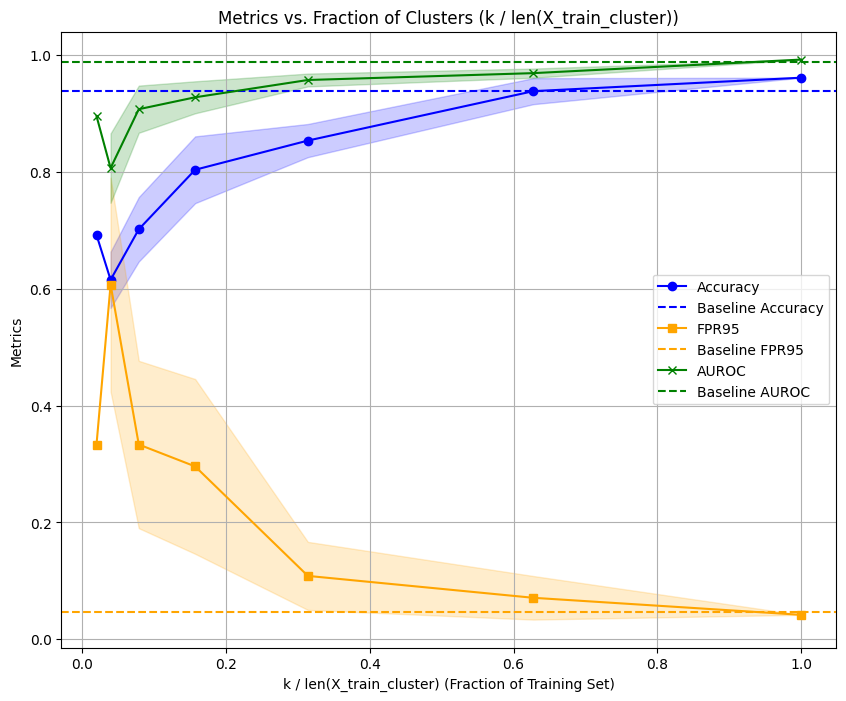

In [112]:
print("confidence_intervals_g: ", confidence_intervals_g)

df_results = benchmark_kmeans_with_varying_k_condidence_g_hat(
    X,
    y,
    M,
    test_size,
    n_runs=10,
    confidence_level=0.95,
    confidence_intervals_g=confidence_intervals_g,
    clf=None,
    save_plot=True,
    fname=cfg_dict["data"]["class_name"],
)

### Feature Level Visualization: Understand how clustering alters the structure of the feature space

Proportion of label changes: 0.13


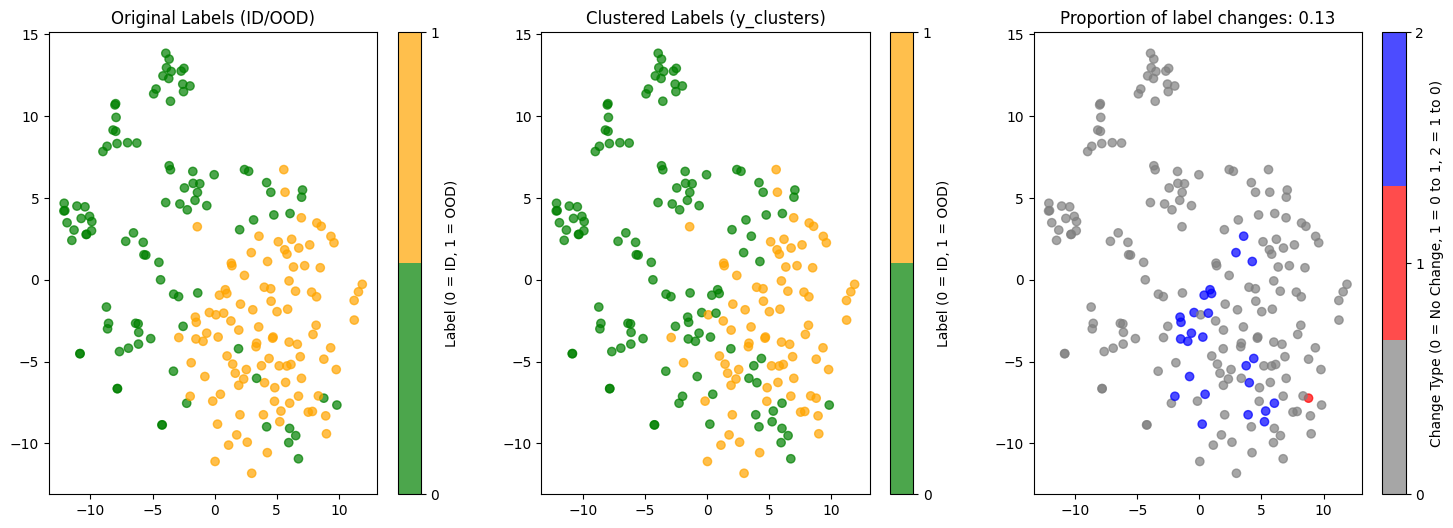

In [113]:
i = 0
_, X_train_cluster, y_train_cluster, y_clusters, *_ = run_g_hat_experiment(
    X, y, test_size, k, M, fixed_seed, fixed_seed, i + 1
)
plot_tsne_with_label_changes(
    X_train_cluster,
    y_train_cluster,
    y_clusters,
    class_name=cfg_dict.data.class_name,
    save_plot=True,
)

# Pasture

### Start

In [117]:
X,y,model,datamodule,train_dataloader,val_dataloader,test_dataloader,cfg_dict = get_X_y_arrays(
        paths["pasture"]["config"],
        paths["pasture"]["ckpt"],
        layer,
        downsample_method,
        getitem_keys,
        device,
        n_batches_to_process,
        mode="holdout",
        verbose=False,
    )

Model and Task are loaded.
download True
Loaded statistics for Pasture: MEAN={'B01': 1354.4051513671875, 'B02': 1118.243896484375, 'B03': 1042.9288330078125, 'B04': 947.6263427734375, 'B05': 1199.472412109375, 'B06': 1999.79052734375, 'B07': 2369.22412109375, 'B08': 2296.82568359375, 'B8A': 732.0833740234375, 'B09': 12.113280296325684, 'B10': 1819.010498046875, 'B11': 1118.9237060546875, 'B12': 2594.14306640625}, STD={'B01': 245.7181396484375, 'B02': 333.0084533691406, 'B03': 395.0932922363281, 'B04': 593.7515869140625, 'B05': 566.4180297851562, 'B06': 861.185302734375, 'B07': 1086.6337890625, 'B08': 1117.9842529296875, 'B8A': 404.92047119140625, 'B09': 4.775853157043457, 'B10': 1002.5896606445312, 'B11': 761.3042602539062, 'B12': 1231.587890625}
self.split_urls {'train': 'https://huggingface.co/datasets/brkekm/EuroSATHoldOutSplits/resolve/main/train_pasture.txt', 'val': 'https://huggingface.co/datasets/brkekm/EuroSATHoldOutSplits/resolve/main/val_pasture.txt', 'test': 'https://hugging

100%|██████████| 2067725275/2067725275 [00:09<00:00, 216001035.88it/s]


100%|██████████| 293074/293074 [00:00<00:00, 10264121.46it/s]


100%|██████████| 196463/196463 [00:00<00:00, 2220847.69it/s]


100%|██████████| 32893/32893 [00:00<00:00, 18922403.16it/s]


classes and class to idx ['SeaLake', 'Residential', 'PermanentCrop', 'Industrial', 'Forest', 'AnnualCrop', 'HerbaceousVegetation', 'River', 'Highway'] {'AnnualCrop': 0, 'Forest': 1, 'HerbaceousVegetation': 2, 'Highway': 3, 'Industrial': 4, 'PermanentCrop': 5, 'Residential': 6, 'River': 7, 'SeaLake': 8}
self.train_dataset.split_urls {'train': 'https://huggingface.co/datasets/brkekm/EuroSATHoldOutSplits/resolve/main/train_pasture.txt', 'val': 'https://huggingface.co/datasets/brkekm/EuroSATHoldOutSplits/resolve/main/val_pasture.txt', 'test': 'https://huggingface.co/datasets/brkekm/EuroSATHoldOutSplits/resolve/main/test_pasture.txt'}
self.split_urls {'train': 'https://huggingface.co/datasets/brkekm/EuroSATHoldOutSplits/resolve/main/train_pasture.txt', 'val': 'https://huggingface.co/datasets/brkekm/EuroSATHoldOutSplits/resolve/main/val_pasture.txt', 'test': 'https://huggingface.co/datasets/brkekm/EuroSATHoldOutSplits/resolve/main/test_pasture.txt'}
self.root /data/dataood/eurosat_holdout_da

100%|██████████| 2/2 [00:00<00:00,  6.96it/s]


Before downsampling, activations shape for layer conv1 : (128, 64, 32, 32)


100%|██████████| 2/2 [00:00<00:00,  6.49it/s]


Before downsampling, activations shape for layer conv1 : (128, 64, 32, 32)


### Downsample Benchmark

In [118]:
for downsample in downsample_methods:
    print(f"Running experiments for {downsample} downsample method.")
    X, y, test_property_lengths = create_feature_matrix_and_labels(
        model=model,
        dm=datamodule,
        train_dataloader=train_dataloader,
        test_dataloader=test_dataloader,
        layer_names=collect_activations_from_layers,
        device=device,
        getitem_keys=getitem_keys,
        n_batches_to_process=n_batches_to_process,
        downsample_method=downsample,
        verbose=verbose,
    )
    print("Run g experiment for downsample method:", downsample)
    g_benchmark = run_g_experiment(
        X, y, split_seed, test_size, n_estimators, fixed_classifier_seed, clf=None
    )
    dict_key = datamodule.class_name + "_" + downsample
    downsample_benchmark[dict_key] = g_benchmark

Running experiments for avg_pool downsample method.


100%|██████████| 2/2 [00:00<00:00,  7.09it/s]


Before downsampling, activations shape for layer conv1 : (128, 64, 32, 32)


100%|██████████| 2/2 [00:00<00:00,  6.71it/s]


Before downsampling, activations shape for layer conv1 : (128, 64, 32, 32)
Run g experiment for downsample method: avg_pool
Running experiments for mean_std downsample method.


100%|██████████| 2/2 [00:00<00:00,  6.49it/s]


Before downsampling, activations shape for layer conv1 : (128, 64, 32, 32)


100%|██████████| 2/2 [00:00<00:00,  6.46it/s]


Before downsampling, activations shape for layer conv1 : (128, 64, 32, 32)
Run g experiment for downsample method: mean_std
Running experiments for avg_pool downsample method.


100%|██████████| 2/2 [00:00<00:00,  6.98it/s]


Before downsampling, activations shape for layer conv1 : (128, 64, 32, 32)


100%|██████████| 2/2 [00:00<00:00,  6.76it/s]


Before downsampling, activations shape for layer conv1 : (128, 64, 32, 32)
Run g experiment for downsample method: avg_pool
Running experiments for max_pool downsample method.


100%|██████████| 2/2 [00:00<00:00,  6.94it/s]


Before downsampling, activations shape for layer conv1 : (128, 64, 32, 32)


100%|██████████| 2/2 [00:00<00:00,  6.76it/s]


Before downsampling, activations shape for layer conv1 : (128, 64, 32, 32)
Run g experiment for downsample method: max_pool
Running experiments for nodownsample downsample method.


100%|██████████| 2/2 [00:00<00:00,  6.90it/s]


Before downsampling, activations shape for layer conv1 : (128, 64, 32, 32)


100%|██████████| 2/2 [00:00<00:00,  7.06it/s]


Before downsampling, activations shape for layer conv1 : (128, 64, 32, 32)
Run g experiment for downsample method: nodownsample


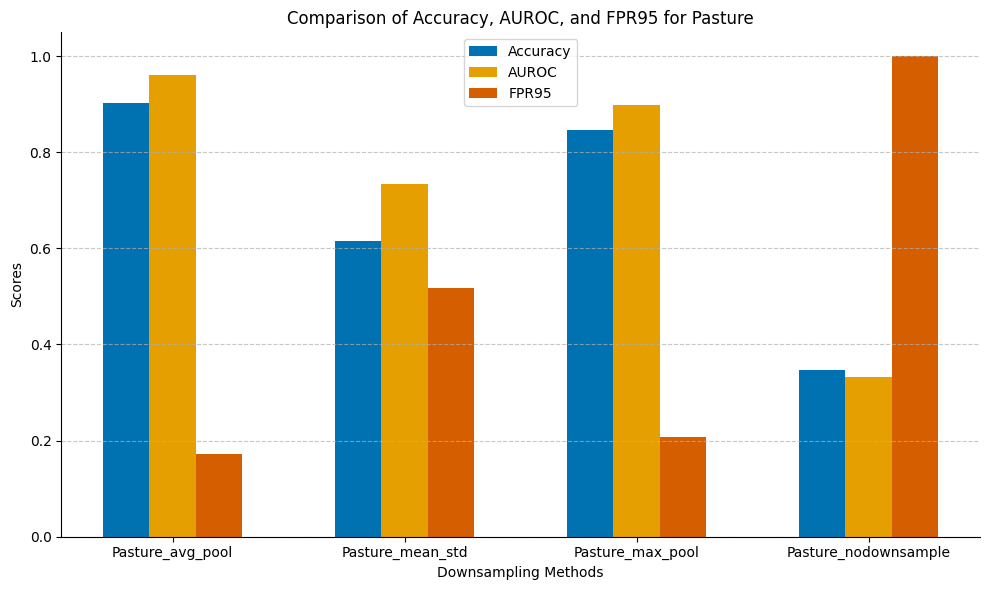

In [119]:
plot_downsample_benchmark(downsample_benchmark, datamodule.class_name)

### Layer Benchmark

In [120]:
for lyr in selected_layers:
    print(f"Running experiments for layer {lyr}")
    X, y, test_property_lengths = create_feature_matrix_and_labels(
        model=model,
        dm=datamodule,
        train_dataloader=train_dataloader,
        test_dataloader=test_dataloader,
        layer_names=lyr,
        device=device,
        getitem_keys=getitem_keys,
        n_batches_to_process=n_batches_to_process,
        downsample_method=downsample_method,
        verbose=verbose,
    )

    g_benchmark = run_g_experiment(
        X, y, split_seed, test_size, n_estimators, fixed_classifier_seed, clf=None
    )
    dict_key = datamodule.class_name + "_" + str(lyr)

    layer_benchmark[dict_key] = g_benchmark

Running experiments for layer ['conv1']


100%|██████████| 2/2 [00:00<00:00,  6.31it/s]


Before downsampling, activations shape for layer conv1 : (128, 64, 32, 32)


100%|██████████| 2/2 [00:00<00:00,  6.89it/s]


Before downsampling, activations shape for layer conv1 : (128, 64, 32, 32)
Running experiments for layer ['layer1.0.conv1']


100%|██████████| 2/2 [00:00<00:00,  7.17it/s]


Before downsampling, activations shape for layer layer1.0.conv1 : (128, 64, 16, 16)


100%|██████████| 2/2 [00:00<00:00,  7.10it/s]


Before downsampling, activations shape for layer layer1.0.conv1 : (128, 64, 16, 16)
Running experiments for layer ['layer3.3.conv1']


100%|██████████| 2/2 [00:00<00:00,  7.69it/s]


Before downsampling, activations shape for layer layer3.3.conv1 : (128, 256, 4, 4)


100%|██████████| 2/2 [00:00<00:00,  7.35it/s]


Before downsampling, activations shape for layer layer3.3.conv1 : (128, 256, 4, 4)
Running experiments for layer ['layer1.2.conv2']


100%|██████████| 2/2 [00:00<00:00,  6.94it/s]


Before downsampling, activations shape for layer layer1.2.conv2 : (128, 64, 16, 16)


100%|██████████| 2/2 [00:00<00:00,  6.97it/s]


Before downsampling, activations shape for layer layer1.2.conv2 : (128, 64, 16, 16)
Running experiments for layer ['layer3.1.conv2']


100%|██████████| 2/2 [00:00<00:00,  7.46it/s]


Before downsampling, activations shape for layer layer3.1.conv2 : (128, 256, 4, 4)


100%|██████████| 2/2 [00:00<00:00,  7.23it/s]


Before downsampling, activations shape for layer layer3.1.conv2 : (128, 256, 4, 4)
Running experiments for layer ['layer2.0.conv1']


100%|██████████| 2/2 [00:00<00:00,  7.04it/s]


Before downsampling, activations shape for layer layer2.0.conv1 : (128, 128, 16, 16)


100%|██████████| 2/2 [00:00<00:00,  7.11it/s]


Before downsampling, activations shape for layer layer2.0.conv1 : (128, 128, 16, 16)
Running experiments for layer ['layer1.0.conv3']


100%|██████████| 2/2 [00:00<00:00,  6.87it/s]


Before downsampling, activations shape for layer layer1.0.conv3 : (128, 256, 16, 16)


100%|██████████| 2/2 [00:00<00:00,  6.98it/s]


Before downsampling, activations shape for layer layer1.0.conv3 : (128, 256, 16, 16)
Running experiments for layer ['layer1.2.conv3']


100%|██████████| 2/2 [00:00<00:00,  6.85it/s]


Before downsampling, activations shape for layer layer1.2.conv3 : (128, 256, 16, 16)


100%|██████████| 2/2 [00:00<00:00,  6.37it/s]


Before downsampling, activations shape for layer layer1.2.conv3 : (128, 256, 16, 16)
Running experiments for layer ['layer4.1.conv3']


100%|██████████| 2/2 [00:00<00:00,  7.38it/s]


Before downsampling, activations shape for layer layer4.1.conv3 : (128, 2048, 2, 2)


100%|██████████| 2/2 [00:00<00:00,  7.05it/s]


Before downsampling, activations shape for layer layer4.1.conv3 : (128, 2048, 2, 2)
Running experiments for layer ['layer4.2.conv3']


100%|██████████| 2/2 [00:00<00:00,  7.17it/s]


Before downsampling, activations shape for layer layer4.2.conv3 : (128, 2048, 2, 2)


100%|██████████| 2/2 [00:00<00:00,  7.25it/s]


Before downsampling, activations shape for layer layer4.2.conv3 : (128, 2048, 2, 2)


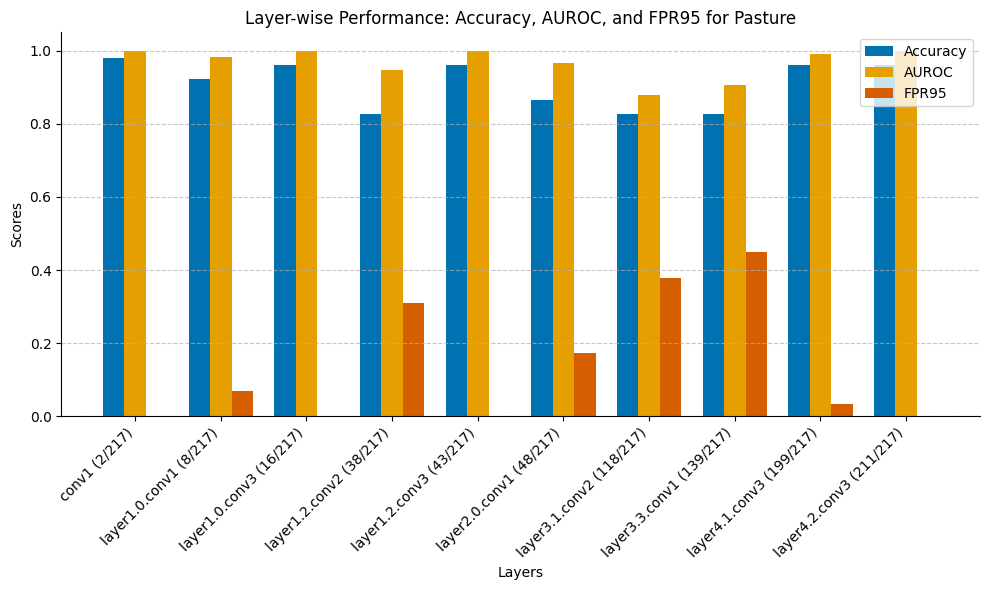

In [121]:
plot_layer_benchmark(layer_benchmark, all_layer_names, datamodule.class_name)

### g confidence interval

In [122]:
g_benchmark = run_multiple_experiments_g(
    X, y, test_size, n_estimators, random_seed=True
)

random_state for split_seed: 3497
random_state for split_seed: 6852
random_state for split_seed: 8366
random_state for split_seed: 4206
random_state for split_seed: 7450
random_state for split_seed: 4258
random_state for split_seed: 95
random_state for split_seed: 1784
random_state for split_seed: 2159
random_state for split_seed: 7376


In [123]:
columns_of_interest = ["baseline_accuracy", "baseline_fpr95", "baseline_roc_auc"]
confidence_intervals_g = calculate_confidence_intervals(
    g_benchmark, columns_of_interest
)
confidence_intervals_g

{'baseline_accuracy': (0.9326923076923077, 0.020762282996637096),
 'baseline_fpr95': (0.08554054848914634, 0.05088072832763486),
 'baseline_roc_auc': (0.9855959225818645, 0.004933918002334621)}

### g_hat

In [124]:
results_df_g_hat = run_optuna_study(
    X,
    y,
    n_optuna_trials,
    test_size,
    min_cluster,
    max_cluster_ratio,
    min_fraction,
    max_fraction,
    n_estimators,
    fixed_seed,
)

[I 2024-12-22 18:37:57,681] A new study created in memory with name: no-name-ca1b7baf-7127-4a89-a360-0a8c6a6a78ad
[I 2024-12-22 18:37:57,743] Trial 0 finished with value: -0.8552593000215645 and parameters: {'k': 19, 'M': 0.19204005763861}. Best is trial 0 with value: -0.8552593000215645.
[I 2024-12-22 18:37:57,930] Trial 1 finished with value: -0.9211287807044418 and parameters: {'k': 48, 'M': 0.19750530058756796}. Best is trial 1 with value: -0.9211287807044418.
[I 2024-12-22 18:37:57,984] Trial 2 finished with value: -0.7462761611615147 and parameters: {'k': 14, 'M': 0.03601423928032735}. Best is trial 1 with value: -0.9211287807044418.
[I 2024-12-22 18:37:58,114] Trial 3 finished with value: -0.9239806358454506 and parameters: {'k': 56, 'M': 0.023041318415652854}. Best is trial 3 with value: -0.9239806358454506.
[I 2024-12-22 18:37:58,126] Trial 4 finished with value: inf and parameters: {'k': 6, 'M': 0.11327159100258942}. Best is trial 3 with value: -0.9239806358454506.
[I 2024-12

In [125]:
N = 10
results_dict = results_df_g_hat.to_dict(orient="records")
k = int(len(X) * 0.3)
M = results_dict[0]["M"]
print("k, M, len(X), k/len(X)", k, M, len(X), k / len(X))

g_hat_benchmark = run_multiple_experiments_g_hat(X, y, test_size, k, M, N, fixed_seed)

k, M, len(X), k/len(X) 76 0.11293716100189416 256 0.296875
random_state for split_seed in iteration 1: 3067
random_state for split_seed in iteration 2: 222
random_state for split_seed in iteration 3: 6966
random_state for split_seed in iteration 4: 3220
random_state for split_seed in iteration 5: 9240
random_state for split_seed in iteration 6: 9317
random_state for split_seed in iteration 7: 4112
random_state for split_seed in iteration 8: 2425
random_state for split_seed in iteration 9: 1907
random_state for split_seed in iteration 10: 6628


### g g_hat mean std + ttest

In [126]:
t_tests_results = perform_benchmark_analysis(g_benchmark, g_hat_benchmark)
t_tests_results

Baseline Accuracy: Mean = 0.9326923076923077, Std Dev = 0.029023670314542976
Baseline ROC AUC: Mean = 0.9855959225818645, Std Dev = 0.006897141777806562
Baseline FPR95: Mean = 0.08554054848914634, Std Dev = 0.07112635371477659
g_hat Accuracy: Mean = 0.8653846153846153, Std Dev = 0.05944627240702375
g_hat ROC AUC: Mean = 0.9469181421717572, Std Dev = 0.036605780166197664
g_hat FPR95: Mean = 0.25636666515227235, Std Dev = 0.19994645293135746
Accuracy: t = 3.2174699184384563, p = 0.004775451692525945
ROC AUC: t = 3.283497141180539, p = 0.004128964296213559
FPR95: t = -2.54546381159014, p = 0.02029125530630541


{'accuracy': (3.2174699184384563, 0.004775451692525945),
 'roc_auc': (3.283497141180539, 0.004128964296213559),
 'fpr95': (-2.54546381159014, 0.02029125530630541)}

### Benchmark g

In [127]:
classifiers = {
    "RandomForestUnblanaced": RandomForestClassifier(n_estimators=100, random_state=42),
    "RandomForest": RandomForestClassifier(
        n_estimators=100, class_weight="balanced", random_state=42
    ),
    "SVC": SVC(probability=True, class_weight="balanced", random_state=42),
    "KNeighbors": KNeighborsClassifier(),
    "LogisticRegression": LogisticRegression(
        class_weight="balanced", max_iter=500, random_state=42
    ),
    "DecisionTree": DecisionTreeClassifier(class_weight="balanced", random_state=42),
    "GradientBoosting": GradientBoostingClassifier(random_state=42),
    "AdaBoost": AdaBoostClassifier(random_state=42),
    "ExtraTrees": ExtraTreesClassifier(
        n_estimators=100, class_weight="balanced", random_state=42
    ),
    "GaussianNB": GaussianNB(),
}

classifier_benchmark_df = benchmark_classifiers(
    X, y, test_size, k, M, classifiers, fixed_seed
)

### Benchmark clustering

In [128]:
clustering_methods = {
    "KMeans": KMeans(n_clusters=3, init="k-means++", random_state=42),
    "DBSCAN_eps_0.1": DBSCAN(eps=0.1, min_samples=5),
    "DBSCAN_eps_0.2": DBSCAN(eps=0.2, min_samples=5),
    "DBSCAN_eps_0.5": DBSCAN(eps=0.5, min_samples=5),
}

# A fixed classifier
classifier = RandomForestClassifier(
    n_estimators=100, class_weight="balanced", random_state=42
)

clustering_benchmark_df = benchmark_clustering_methods(
    X, y, test_size, k, M, clustering_methods, classifier
)

### Investigate k wrt g-g_hat

confidence_intervals_g {'baseline_accuracy': (0.9326923076923077, 0.020762282996637096), 'baseline_fpr95': (0.08554054848914634, 0.05088072832763486), 'baseline_roc_auc': (0.9855959225818645, 0.004933918002334621)}
Max i: 7
k: 1
Skipping k=1 on run 1 due to single class in y_clusters.
Skipping k=1 on run 2 due to single class in y_clusters.
Skipping k=1 on run 3 due to single class in y_clusters.
Skipping k=1 on run 4 due to single class in y_clusters.
Skipping k=1 on run 5 due to single class in y_clusters.
Skipping k=1 on run 6 due to single class in y_clusters.
Skipping k=1 on run 7 due to single class in y_clusters.
Skipping k=1 on run 8 due to single class in y_clusters.
Skipping k=1 on run 9 due to single class in y_clusters.
Skipping k=1 on run 10 due to single class in y_clusters.
k: 2
Skipping k=2 on run 1 due to single class in y_clusters.
Skipping k=2 on run 2 due to single class in y_clusters.
Skipping k=2 on run 3 due to single class in y_clusters.
Skipping k=2 on run 4 du

/ws/geospatial-ood-detection/notebooks/../src/tardis/eurosat_xbd_utils.py:989: RuntimeWarning: Mean of empty slice
  mean = np.nanmean(values)
/ws/geospatial-ood-detection/notebooks/../src/tardis/eurosat_xbd_utils.py:990: SmallSampleWarning: One or more sample arguments is too small; all returned values will be NaN. See documentation for sample size requirements.
  sem = stats.sem(values, nan_policy="omit")
/ws/geospatial-ood-detection/notebooks/../src/tardis/eurosat_xbd_utils.py:989: RuntimeWarning: Mean of empty slice
  mean = np.nanmean(values)
/ws/geospatial-ood-detection/notebooks/../src/tardis/eurosat_xbd_utils.py:990: SmallSampleWarning: One or more sample arguments is too small; all returned values will be NaN. See documentation for sample size requirements.
  sem = stats.sem(values, nan_policy="omit")
/ws/geospatial-ood-detection/notebooks/../src/tardis/eurosat_xbd_utils.py:989: RuntimeWarning: Mean of empty slice
  mean = np.nanmean(values)
/ws/geospatial-ood-detection/notebo

Skipping k=8 on run 2 due to single class in y_clusters.
Skipping k=8 on run 3 due to single class in y_clusters.
Skipping k=8 on run 4 due to single class in y_clusters.
Skipping k=8 on run 6 due to single class in y_clusters.
Skipping k=8 on run 8 due to single class in y_clusters.
Skipping k=8 on run 9 due to single class in y_clusters.
Skipping k=8 on run 10 due to single class in y_clusters.
k: 16
k: 32
k: 64
k: 128
k: 204


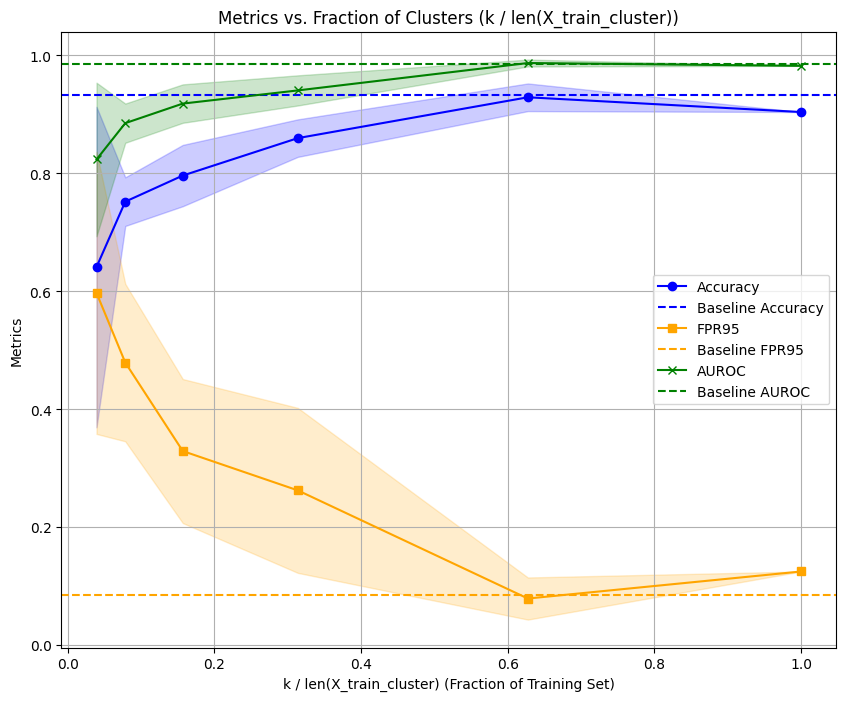

In [129]:
print("confidence_intervals_g", confidence_intervals_g)

df_results = benchmark_kmeans_with_varying_k_condidence_g_hat(
    X,
    y,
    M,
    test_size,
    n_runs=10,
    confidence_level=0.95,
    confidence_intervals_g=confidence_intervals_g,
    clf=None,
    save_plot=True,
    fname=cfg_dict["data"]["class_name"],
)

### Feature Level Visualization: Understand how clustering alters the structure of the feature space

Proportion of label changes: 0.07


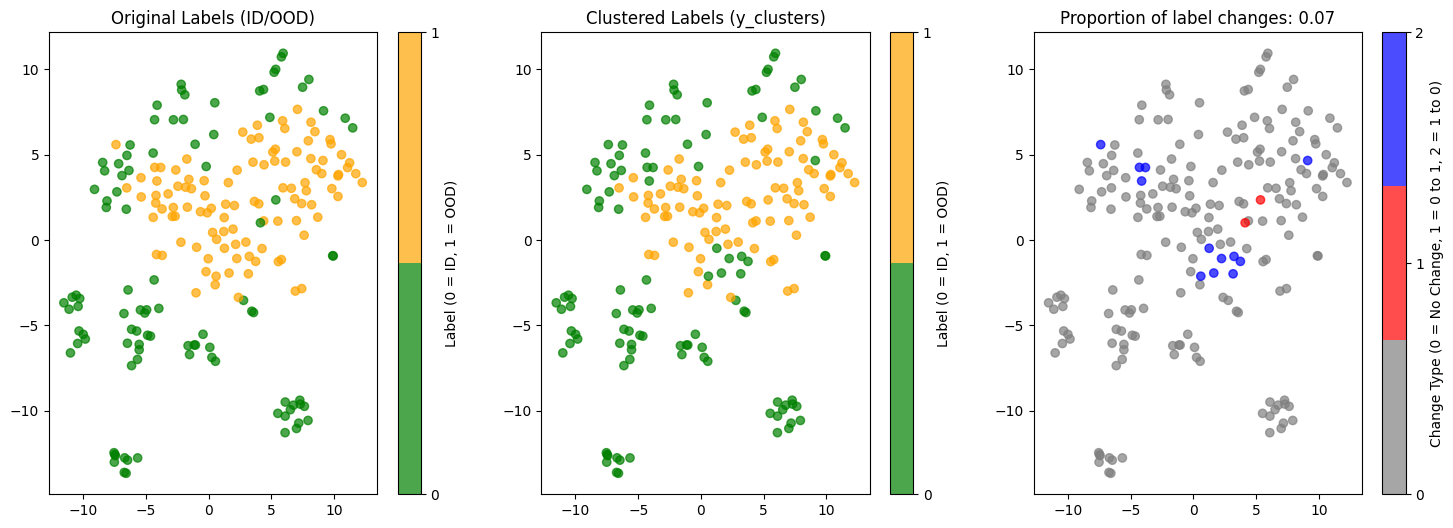

In [130]:
i = 0
_, X_train_cluster, y_train_cluster, y_clusters, *_ = run_g_hat_experiment(
    X, y, test_size, k, M, fixed_seed, fixed_seed, i + 1
)
plot_tsne_with_label_changes(
    X_train_cluster,
    y_train_cluster,
    y_clusters,
    class_name=cfg_dict.data.class_name,
    save_plot=True,
)

# Permanent Crop

### Start

In [132]:
X,y,model,datamodule,train_dataloader,val_dataloader,test_dataloader,cfg_dict = get_X_y_arrays(
        paths["permanentcrop"]["config"],
        paths["permanentcrop"]["ckpt"],
        layer,
        downsample_method,
        getitem_keys,
        device,
        n_batches_to_process,
        mode="holdout",
        verbose=False,
    )

Model and Task are loaded.
download True
Loaded statistics for PermanentCrop: MEAN={'B01': 1354.405029296875, 'B02': 1118.243408203125, 'B03': 1042.929931640625, 'B04': 947.6260986328125, 'B05': 1199.4725341796875, 'B06': 1999.7908935546875, 'B07': 2369.223876953125, 'B08': 2296.826171875, 'B8A': 732.0835571289062, 'B09': 12.113273620605469, 'B10': 1819.0098876953125, 'B11': 1118.9232177734375, 'B12': 2594.141845703125}, STD={'B01': 245.7180938720703, 'B02': 333.0083923339844, 'B03': 395.09332275390625, 'B04': 593.7516479492188, 'B05': 566.418212890625, 'B06': 861.1856689453125, 'B07': 1086.6336669921875, 'B08': 1117.984130859375, 'B8A': 404.9205017089844, 'B09': 4.775854587554932, 'B10': 1002.5896606445312, 'B11': 761.3045654296875, 'B12': 1231.58837890625}
self.split_urls {'train': 'https://huggingface.co/datasets/brkekm/EuroSATHoldOutSplits/resolve/main/train_permanentcrop.txt', 'val': 'https://huggingface.co/datasets/brkekm/EuroSATHoldOutSplits/resolve/main/val_permanentcrop.txt', 

100%|██████████| 2067725275/2067725275 [00:09<00:00, 220532102.34it/s]


100%|██████████| 279318/279318 [00:00<00:00, 1538241.34it/s]


100%|██████████| 186719/186719 [00:00<00:00, 9087869.58it/s]


100%|██████████| 56393/56393 [00:00<00:00, 4744917.36it/s]


classes and class to idx ['SeaLake', 'Residential', 'Industrial', 'Pasture', 'Forest', 'AnnualCrop', 'HerbaceousVegetation', 'River', 'Highway'] {'AnnualCrop': 0, 'Forest': 1, 'HerbaceousVegetation': 2, 'Highway': 3, 'Industrial': 4, 'Pasture': 5, 'Residential': 6, 'River': 7, 'SeaLake': 8}
self.train_dataset.split_urls {'train': 'https://huggingface.co/datasets/brkekm/EuroSATHoldOutSplits/resolve/main/train_permanentcrop.txt', 'val': 'https://huggingface.co/datasets/brkekm/EuroSATHoldOutSplits/resolve/main/val_permanentcrop.txt', 'test': 'https://huggingface.co/datasets/brkekm/EuroSATHoldOutSplits/resolve/main/test_permanentcrop.txt'}
self.split_urls {'train': 'https://huggingface.co/datasets/brkekm/EuroSATHoldOutSplits/resolve/main/train_permanentcrop.txt', 'val': 'https://huggingface.co/datasets/brkekm/EuroSATHoldOutSplits/resolve/main/val_permanentcrop.txt', 'test': 'https://huggingface.co/datasets/brkekm/EuroSATHoldOutSplits/resolve/main/test_permanentcrop.txt'}
self.root /data/da

100%|██████████| 2/2 [00:00<00:00,  6.84it/s]


Before downsampling, activations shape for layer conv1 : (128, 64, 32, 32)


100%|██████████| 2/2 [00:00<00:00,  7.16it/s]


Before downsampling, activations shape for layer conv1 : (128, 64, 32, 32)


### Downsample Benchmark

In [133]:
for downsample in downsample_methods:
    print(f"Running experiments for {downsample} downsample method.")
    X, y, test_property_lengths = create_feature_matrix_and_labels(
        model=model,
        dm=datamodule,
        train_dataloader=train_dataloader,
        test_dataloader=test_dataloader,
        layer_names=collect_activations_from_layers,
        device=device,
        getitem_keys=getitem_keys,
        n_batches_to_process=n_batches_to_process,
        downsample_method=downsample,
        verbose=verbose,
    )
    print("Run g experiment for downsample method:", downsample)
    g_benchmark = run_g_experiment(
        X, y, split_seed, test_size, n_estimators, fixed_classifier_seed, clf=None
    )
    dict_key = datamodule.class_name + "_" + downsample
    downsample_benchmark[dict_key] = g_benchmark

Running experiments for avg_pool downsample method.


100%|██████████| 2/2 [00:00<00:00,  7.25it/s]


Before downsampling, activations shape for layer conv1 : (128, 64, 32, 32)


100%|██████████| 2/2 [00:00<00:00,  6.92it/s]


Before downsampling, activations shape for layer conv1 : (128, 64, 32, 32)
Run g experiment for downsample method: avg_pool
Running experiments for mean_std downsample method.


100%|██████████| 2/2 [00:00<00:00,  6.62it/s]


Before downsampling, activations shape for layer conv1 : (128, 64, 32, 32)


100%|██████████| 2/2 [00:00<00:00,  7.05it/s]


Before downsampling, activations shape for layer conv1 : (128, 64, 32, 32)
Run g experiment for downsample method: mean_std
Running experiments for avg_pool downsample method.


100%|██████████| 2/2 [00:00<00:00,  7.01it/s]


Before downsampling, activations shape for layer conv1 : (128, 64, 32, 32)


100%|██████████| 2/2 [00:00<00:00,  6.70it/s]


Before downsampling, activations shape for layer conv1 : (128, 64, 32, 32)
Run g experiment for downsample method: avg_pool
Running experiments for max_pool downsample method.


100%|██████████| 2/2 [00:00<00:00,  6.89it/s]


Before downsampling, activations shape for layer conv1 : (128, 64, 32, 32)


100%|██████████| 2/2 [00:00<00:00,  6.65it/s]


Before downsampling, activations shape for layer conv1 : (128, 64, 32, 32)
Run g experiment for downsample method: max_pool
Running experiments for nodownsample downsample method.


100%|██████████| 2/2 [00:00<00:00,  6.77it/s]


Before downsampling, activations shape for layer conv1 : (128, 64, 32, 32)


100%|██████████| 2/2 [00:00<00:00,  7.24it/s]


Before downsampling, activations shape for layer conv1 : (128, 64, 32, 32)
Run g experiment for downsample method: nodownsample


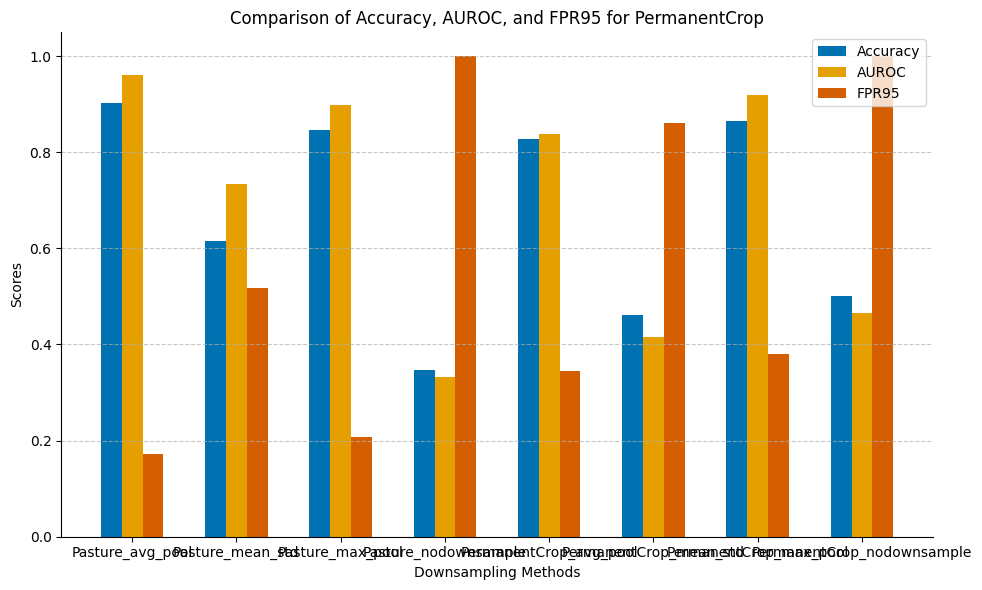

In [134]:
plot_downsample_benchmark(downsample_benchmark, datamodule.class_name)

### Layer Benchmark

In [135]:
for lyr in selected_layers:
    print(f"Running experiments for layer {lyr}")
    X, y, test_property_lengths = create_feature_matrix_and_labels(
        model=model,
        dm=datamodule,
        train_dataloader=train_dataloader,
        test_dataloader=test_dataloader,
        layer_names=lyr,
        device=device,
        getitem_keys=getitem_keys,
        n_batches_to_process=n_batches_to_process,
        downsample_method=downsample_method,
        verbose=verbose,
    )

    g_benchmark = run_g_experiment(
        X, y, split_seed, test_size, n_estimators, fixed_classifier_seed, clf=None
    )
    dict_key = datamodule.class_name + "_" + str(lyr)

    layer_benchmark[dict_key] = g_benchmark

Running experiments for layer ['conv1']


100%|██████████| 2/2 [00:00<00:00,  6.90it/s]


Before downsampling, activations shape for layer conv1 : (128, 64, 32, 32)


100%|██████████| 2/2 [00:00<00:00,  6.91it/s]


Before downsampling, activations shape for layer conv1 : (128, 64, 32, 32)
Running experiments for layer ['layer1.0.conv1']


100%|██████████| 2/2 [00:00<00:00,  7.32it/s]


Before downsampling, activations shape for layer layer1.0.conv1 : (128, 64, 16, 16)


100%|██████████| 2/2 [00:00<00:00,  7.03it/s]


Before downsampling, activations shape for layer layer1.0.conv1 : (128, 64, 16, 16)
Running experiments for layer ['layer3.3.conv1']


100%|██████████| 2/2 [00:00<00:00,  7.53it/s]


Before downsampling, activations shape for layer layer3.3.conv1 : (128, 256, 4, 4)


100%|██████████| 2/2 [00:00<00:00,  7.17it/s]


Before downsampling, activations shape for layer layer3.3.conv1 : (128, 256, 4, 4)
Running experiments for layer ['layer1.2.conv2']


100%|██████████| 2/2 [00:00<00:00,  6.67it/s]


Before downsampling, activations shape for layer layer1.2.conv2 : (128, 64, 16, 16)


100%|██████████| 2/2 [00:00<00:00,  7.09it/s]


Before downsampling, activations shape for layer layer1.2.conv2 : (128, 64, 16, 16)
Running experiments for layer ['layer3.1.conv2']


100%|██████████| 2/2 [00:00<00:00,  7.62it/s]


Before downsampling, activations shape for layer layer3.1.conv2 : (128, 256, 4, 4)


100%|██████████| 2/2 [00:00<00:00,  7.35it/s]


Before downsampling, activations shape for layer layer3.1.conv2 : (128, 256, 4, 4)
Running experiments for layer ['layer2.0.conv1']


100%|██████████| 2/2 [00:00<00:00,  6.77it/s]


Before downsampling, activations shape for layer layer2.0.conv1 : (128, 128, 16, 16)


100%|██████████| 2/2 [00:00<00:00,  7.04it/s]


Before downsampling, activations shape for layer layer2.0.conv1 : (128, 128, 16, 16)
Running experiments for layer ['layer1.0.conv3']


100%|██████████| 2/2 [00:00<00:00,  6.66it/s]


Before downsampling, activations shape for layer layer1.0.conv3 : (128, 256, 16, 16)


100%|██████████| 2/2 [00:00<00:00,  7.01it/s]


Before downsampling, activations shape for layer layer1.0.conv3 : (128, 256, 16, 16)
Running experiments for layer ['layer1.2.conv3']


100%|██████████| 2/2 [00:00<00:00,  6.72it/s]


Before downsampling, activations shape for layer layer1.2.conv3 : (128, 256, 16, 16)


100%|██████████| 2/2 [00:00<00:00,  6.55it/s]


Before downsampling, activations shape for layer layer1.2.conv3 : (128, 256, 16, 16)
Running experiments for layer ['layer4.1.conv3']


100%|██████████| 2/2 [00:00<00:00,  7.38it/s]


Before downsampling, activations shape for layer layer4.1.conv3 : (128, 2048, 2, 2)


100%|██████████| 2/2 [00:00<00:00,  7.37it/s]


Before downsampling, activations shape for layer layer4.1.conv3 : (128, 2048, 2, 2)
Running experiments for layer ['layer4.2.conv3']


100%|██████████| 2/2 [00:00<00:00,  7.34it/s]


Before downsampling, activations shape for layer layer4.2.conv3 : (128, 2048, 2, 2)


100%|██████████| 2/2 [00:00<00:00,  6.35it/s]


Before downsampling, activations shape for layer layer4.2.conv3 : (128, 2048, 2, 2)


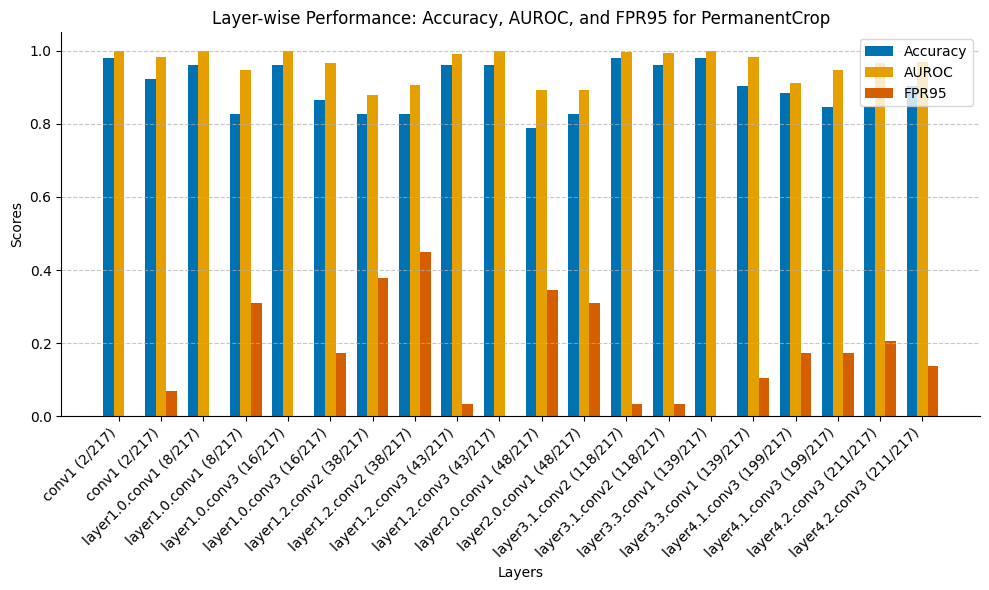

In [136]:
plot_layer_benchmark(layer_benchmark, all_layer_names, datamodule.class_name)

### g confidence interval

In [137]:
g_benchmark = run_multiple_experiments_g(
    X, y, test_size, n_estimators, random_seed=True
)

random_state for split_seed: 3274
random_state for split_seed: 3929
random_state for split_seed: 1225
random_state for split_seed: 2221
random_state for split_seed: 3268
random_state for split_seed: 4360
random_state for split_seed: 9093
random_state for split_seed: 790
random_state for split_seed: 583
random_state for split_seed: 8185


In [138]:
columns_of_interest = ["baseline_accuracy", "baseline_fpr95", "baseline_roc_auc"]
confidence_intervals_g = calculate_confidence_intervals(
    g_benchmark, columns_of_interest
)
confidence_intervals_g

{'baseline_accuracy': (0.9115384615384615, 0.02841605521525442),
 'baseline_fpr95': (0.17970518213115663, 0.09679222130825725),
 'baseline_roc_auc': (0.9717464419620999, 0.009703254496692166)}

### g_hat

In [139]:
results_df_g_hat = run_optuna_study(
    X,
    y,
    n_optuna_trials,
    test_size,
    min_cluster,
    max_cluster_ratio,
    min_fraction,
    max_fraction,
    n_estimators,
    fixed_seed,
)

[I 2024-12-22 18:40:30,629] A new study created in memory with name: no-name-5b7ebdf6-ab98-43bd-bad1-a020094e6769
[I 2024-12-22 18:40:30,693] Trial 0 finished with value: -0.8277580324776055 and parameters: {'k': 19, 'M': 0.19204005763861}. Best is trial 0 with value: -0.8277580324776055.
[I 2024-12-22 18:40:30,883] Trial 1 finished with value: -0.8747018267745168 and parameters: {'k': 48, 'M': 0.19750530058756796}. Best is trial 1 with value: -0.8747018267745168.
[I 2024-12-22 18:40:30,907] Trial 2 finished with value: inf and parameters: {'k': 14, 'M': 0.03601423928032735}. Best is trial 1 with value: -0.8747018267745168.
[I 2024-12-22 18:40:31,036] Trial 3 finished with value: -0.8994627774003087 and parameters: {'k': 56, 'M': 0.023041318415652854}. Best is trial 3 with value: -0.8994627774003087.
[I 2024-12-22 18:40:31,049] Trial 4 finished with value: inf and parameters: {'k': 6, 'M': 0.11327159100258942}. Best is trial 3 with value: -0.8994627774003087.
[I 2024-12-22 18:40:31,068

In [140]:
N = 10
results_dict = results_df_g_hat.to_dict(orient="records")
k = int(len(X) * 0.3)
M = results_dict[0]["M"]
print("k, M, len(X), k/len(X)", k, M, len(X), k / len(X))

g_hat_benchmark = run_multiple_experiments_g_hat(X, y, test_size, k, M, N, fixed_seed)

k, M, len(X), k/len(X) 76 0.14224922508301596 256 0.296875
random_state for split_seed in iteration 1: 8742
random_state for split_seed in iteration 2: 1580
random_state for split_seed in iteration 3: 7890
random_state for split_seed in iteration 4: 3188
random_state for split_seed in iteration 5: 2203
random_state for split_seed in iteration 6: 1680
random_state for split_seed in iteration 7: 5860
random_state for split_seed in iteration 8: 5501
random_state for split_seed in iteration 9: 1630
random_state for split_seed in iteration 10: 8136


### g g_hat mean std + ttest

In [141]:
t_tests_results = perform_benchmark_analysis(g_benchmark, g_hat_benchmark)
t_tests_results

Baseline Accuracy: Mean = 0.9115384615384615, Std Dev = 0.03972290611494787
Baseline ROC AUC: Mean = 0.9717464419620999, Std Dev = 0.013564214471776309
Baseline FPR95: Mean = 0.17970518213115663, Std Dev = 0.135306195408191
g_hat Accuracy: Mean = 0.8019230769230768, Std Dev = 0.08976648059710411
g_hat ROC AUC: Mean = 0.9008602591885662, Std Dev = 0.07069731800507947
g_hat FPR95: Mean = 0.34925240133429786, Std Dev = 0.1907696869905346
Accuracy: t = 3.5312192787878156, p = 0.002385447657307454
ROC AUC: t = 3.113929318372144, p = 0.005993812334680174
FPR95: t = -2.292417279931439, p = 0.03414790954648704


{'accuracy': (3.5312192787878156, 0.002385447657307454),
 'roc_auc': (3.113929318372144, 0.005993812334680174),
 'fpr95': (-2.292417279931439, 0.03414790954648704)}

### Benchmark g

In [142]:
classifier_benchmark_df = benchmark_classifiers(
    X, y, test_size, k, M, classifiers, fixed_seed
)

### Benchmark clustering

In [143]:
# A fixed classifier
classifier = classifiers['RandomForest']

clustering_benchmark_df = benchmark_clustering_methods(
    X, y, test_size, k, M, clustering_methods, classifier
)

clustering_benchmark_df

Clustering  Accuracy  ROC_AUC  FPR95  Clustering Time (s)  \
0          KMeans  0.461538      0.5    1.0             0.008036   
1  DBSCAN_eps_0.1  0.538462      0.5    1.0             0.006032   
2  DBSCAN_eps_0.2  0.538462      0.5    1.0             0.005246   
3  DBSCAN_eps_0.5  0.538462      0.5    1.0             0.005235   

   Classifier Training Time (s)  Number of Samples  
0                      0.092283                204  
1                      0.090362                204  
2                      0.090621                204  
3                      0.089984                204

### Investigate k wrt g-g_hat

confidence_intervals_g {'baseline_accuracy': (0.9115384615384615, 0.02841605521525442), 'baseline_fpr95': (0.17970518213115663, 0.09679222130825725), 'baseline_roc_auc': (0.9717464419620999, 0.009703254496692166)}
Max i: 7
k: 1
Skipping k=1 on run 1 due to single class in y_clusters.
Skipping k=1 on run 2 due to single class in y_clusters.
Skipping k=1 on run 3 due to single class in y_clusters.
Skipping k=1 on run 4 due to single class in y_clusters.
Skipping k=1 on run 5 due to single class in y_clusters.
Skipping k=1 on run 6 due to single class in y_clusters.
Skipping k=1 on run 7 due to single class in y_clusters.
Skipping k=1 on run 8 due to single class in y_clusters.
Skipping k=1 on run 9 due to single class in y_clusters.
Skipping k=1 on run 10 due to single class in y_clusters.
k: 2
Skipping k=2 on run 1 due to single class in y_clusters.
Skipping k=2 on run 2 due to single class in y_clusters.
Skipping k=2 on run 3 due to single class in y_clusters.
Skipping k=2 on run 4 due

/ws/geospatial-ood-detection/notebooks/../src/tardis/eurosat_xbd_utils.py:989: RuntimeWarning: Mean of empty slice
  mean = np.nanmean(values)
/ws/geospatial-ood-detection/notebooks/../src/tardis/eurosat_xbd_utils.py:990: SmallSampleWarning: One or more sample arguments is too small; all returned values will be NaN. See documentation for sample size requirements.
  sem = stats.sem(values, nan_policy="omit")
/ws/geospatial-ood-detection/notebooks/../src/tardis/eurosat_xbd_utils.py:989: RuntimeWarning: Mean of empty slice
  mean = np.nanmean(values)
/ws/geospatial-ood-detection/notebooks/../src/tardis/eurosat_xbd_utils.py:990: SmallSampleWarning: One or more sample arguments is too small; all returned values will be NaN. See documentation for sample size requirements.
  sem = stats.sem(values, nan_policy="omit")
/ws/geospatial-ood-detection/notebooks/../src/tardis/eurosat_xbd_utils.py:989: RuntimeWarning: Mean of empty slice
  mean = np.nanmean(values)
/ws/geospatial-ood-detection/notebo

Skipping k=8 on run 2 due to single class in y_clusters.
Skipping k=8 on run 3 due to single class in y_clusters.
Skipping k=8 on run 4 due to single class in y_clusters.
Skipping k=8 on run 6 due to single class in y_clusters.
Skipping k=8 on run 7 due to single class in y_clusters.
Skipping k=8 on run 8 due to single class in y_clusters.
Skipping k=8 on run 9 due to single class in y_clusters.
k: 16
k: 32
k: 64
k: 128
k: 204


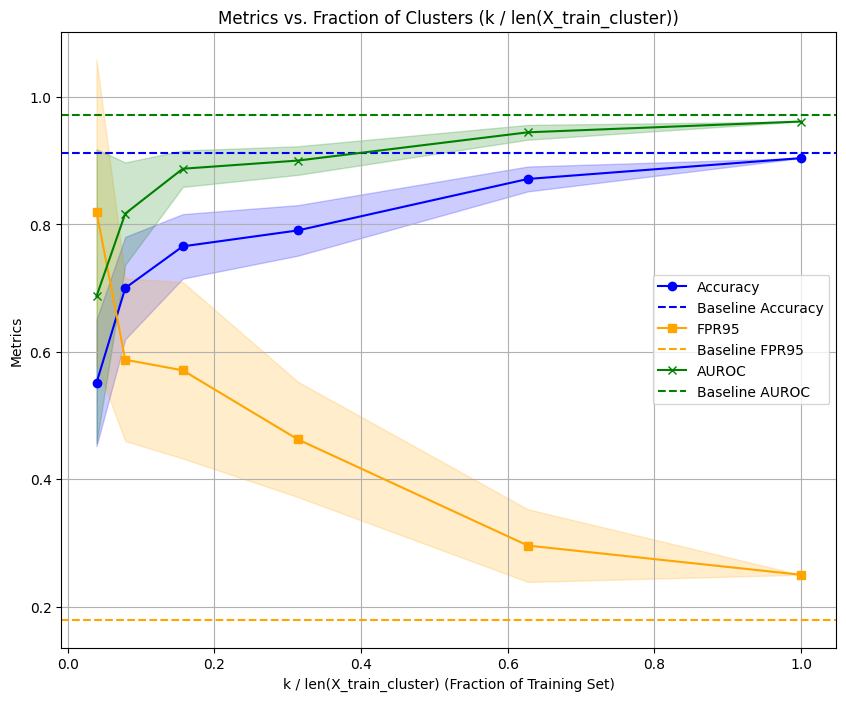

In [146]:
print("confidence_intervals_g", confidence_intervals_g)

df_results = benchmark_kmeans_with_varying_k_condidence_g_hat(
    X,
    y,
    M,
    test_size,
    n_runs=10,
    confidence_level=0.95,
    confidence_intervals_g=confidence_intervals_g,
    clf=None,
    save_plot=True,
    fname=cfg_dict["data"]["class_name"],
)

### Feature Level Visualization: Understand how clustering alters the structure of the feature space

Proportion of label changes: 0.09


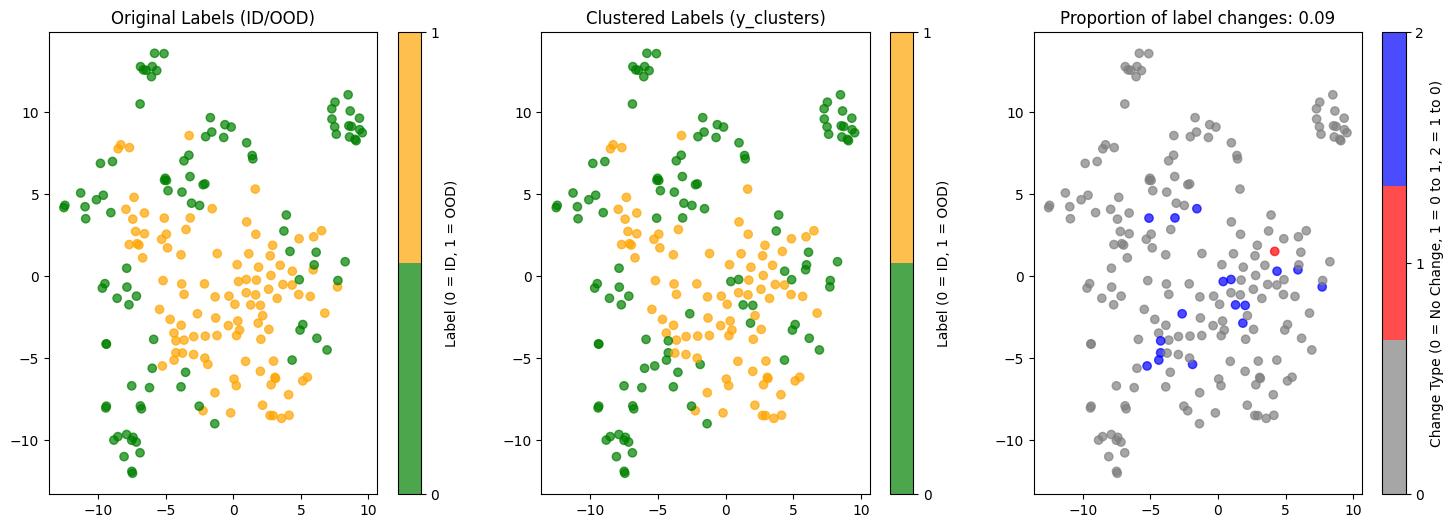

In [147]:
i = 0
_, X_train_cluster, y_train_cluster, y_clusters, *_ = run_g_hat_experiment(
    X, y, test_size, k, M, fixed_seed, fixed_seed, i + 1
)
plot_tsne_with_label_changes(
    X_train_cluster,
    y_train_cluster,
    y_clusters,
    class_name=cfg_dict.data.class_name,
    save_plot=True,
)

# Residential

### Start

In [148]:
X,y,model,datamodule,train_dataloader,val_dataloader,test_dataloader,cfg_dict = get_X_y_arrays(
        paths["residential"]["config"],
        paths["residential"]["ckpt"],
        layer,
        downsample_method,
        getitem_keys,
        device,
        n_batches_to_process,
        mode="holdout",
        verbose=False,
    )

Model and Task are loaded.
download True
Loaded statistics for Residential: MEAN={'B01': 1354.406005859375, 'B02': 1118.2435302734375, 'B03': 1042.9298095703125, 'B04': 947.6261596679688, 'B05': 1199.4730224609375, 'B06': 1999.7913818359375, 'B07': 2369.221923828125, 'B08': 2296.826416015625, 'B8A': 732.0836181640625, 'B09': 12.113276481628418, 'B10': 1819.0101318359375, 'B11': 1118.92333984375, 'B12': 2594.140380859375}, STD={'B01': 245.71804809570312, 'B02': 333.0084228515625, 'B03': 395.0933532714844, 'B04': 593.7516479492188, 'B05': 566.4181518554688, 'B06': 861.1856079101562, 'B07': 1086.633544921875, 'B08': 1117.9835205078125, 'B8A': 404.9204406738281, 'B09': 4.775853157043457, 'B10': 1002.5896606445312, 'B11': 761.3046264648438, 'B12': 1231.588134765625}
self.split_urls {'train': 'https://huggingface.co/datasets/brkekm/EuroSATHoldOutSplits/resolve/main/train_residential.txt', 'val': 'https://huggingface.co/datasets/brkekm/EuroSATHoldOutSplits/resolve/main/val_residential.txt', '

100%|██████████| 2067725275/2067725275 [00:09<00:00, 221161454.21it/s]


100%|██████████| 275716/275716 [00:00<00:00, 3042389.85it/s]


100%|██████████| 184821/184821 [00:00<00:00, 9383683.28it/s]


100%|██████████| 61893/61893 [00:00<00:00, 8588283.90it/s]


classes and class to idx ['SeaLake', 'PermanentCrop', 'Industrial', 'Pasture', 'Forest', 'AnnualCrop', 'HerbaceousVegetation', 'River', 'Highway'] {'AnnualCrop': 0, 'Forest': 1, 'HerbaceousVegetation': 2, 'Highway': 3, 'Industrial': 4, 'Pasture': 5, 'PermanentCrop': 6, 'River': 7, 'SeaLake': 8}
self.train_dataset.split_urls {'train': 'https://huggingface.co/datasets/brkekm/EuroSATHoldOutSplits/resolve/main/train_residential.txt', 'val': 'https://huggingface.co/datasets/brkekm/EuroSATHoldOutSplits/resolve/main/val_residential.txt', 'test': 'https://huggingface.co/datasets/brkekm/EuroSATHoldOutSplits/resolve/main/test_residential.txt'}
self.split_urls {'train': 'https://huggingface.co/datasets/brkekm/EuroSATHoldOutSplits/resolve/main/train_residential.txt', 'val': 'https://huggingface.co/datasets/brkekm/EuroSATHoldOutSplits/resolve/main/val_residential.txt', 'test': 'https://huggingface.co/datasets/brkekm/EuroSATHoldOutSplits/resolve/main/test_residential.txt'}
self.root /data/dataood/eu

100%|██████████| 2/2 [00:00<00:00,  6.95it/s]


Before downsampling, activations shape for layer conv1 : (128, 64, 32, 32)


100%|██████████| 2/2 [00:00<00:00,  6.72it/s]


Before downsampling, activations shape for layer conv1 : (128, 64, 32, 32)


### Downsample Benchmark

In [149]:
for downsample in downsample_methods:
    print(f"Running experiments for {downsample} downsample method.")
    X, y, test_property_lengths = create_feature_matrix_and_labels(
        model=model,
        dm=datamodule,
        train_dataloader=train_dataloader,
        test_dataloader=test_dataloader,
        layer_names=collect_activations_from_layers,
        device=device,
        getitem_keys=getitem_keys,
        n_batches_to_process=n_batches_to_process,
        downsample_method=downsample,
        verbose=verbose,
    )
    print("Run g experiment for downsample method:", downsample)
    g_benchmark = run_g_experiment(
        X, y, split_seed, test_size, n_estimators, fixed_classifier_seed, clf=None
    )
    dict_key = datamodule.class_name + "_" + downsample
    downsample_benchmark[dict_key] = g_benchmark

Running experiments for avg_pool downsample method.


100%|██████████| 2/2 [00:00<00:00,  7.16it/s]


Before downsampling, activations shape for layer conv1 : (128, 64, 32, 32)


100%|██████████| 2/2 [00:00<00:00,  6.41it/s]


Before downsampling, activations shape for layer conv1 : (128, 64, 32, 32)
Run g experiment for downsample method: avg_pool
Running experiments for mean_std downsample method.


100%|██████████| 2/2 [00:00<00:00,  6.49it/s]


Before downsampling, activations shape for layer conv1 : (128, 64, 32, 32)


100%|██████████| 2/2 [00:00<00:00,  5.34it/s]


Before downsampling, activations shape for layer conv1 : (128, 64, 32, 32)
Run g experiment for downsample method: mean_std
Running experiments for avg_pool downsample method.


100%|██████████| 2/2 [00:00<00:00,  6.83it/s]


Before downsampling, activations shape for layer conv1 : (128, 64, 32, 32)


100%|██████████| 2/2 [00:00<00:00,  6.74it/s]


Before downsampling, activations shape for layer conv1 : (128, 64, 32, 32)
Run g experiment for downsample method: avg_pool
Running experiments for max_pool downsample method.


100%|██████████| 2/2 [00:00<00:00,  6.88it/s]


Before downsampling, activations shape for layer conv1 : (128, 64, 32, 32)


100%|██████████| 2/2 [00:00<00:00,  6.81it/s]


Before downsampling, activations shape for layer conv1 : (128, 64, 32, 32)
Run g experiment for downsample method: max_pool
Running experiments for nodownsample downsample method.


100%|██████████| 2/2 [00:00<00:00,  6.65it/s]


Before downsampling, activations shape for layer conv1 : (128, 64, 32, 32)


100%|██████████| 2/2 [00:00<00:00,  7.01it/s]


Before downsampling, activations shape for layer conv1 : (128, 64, 32, 32)
Run g experiment for downsample method: nodownsample


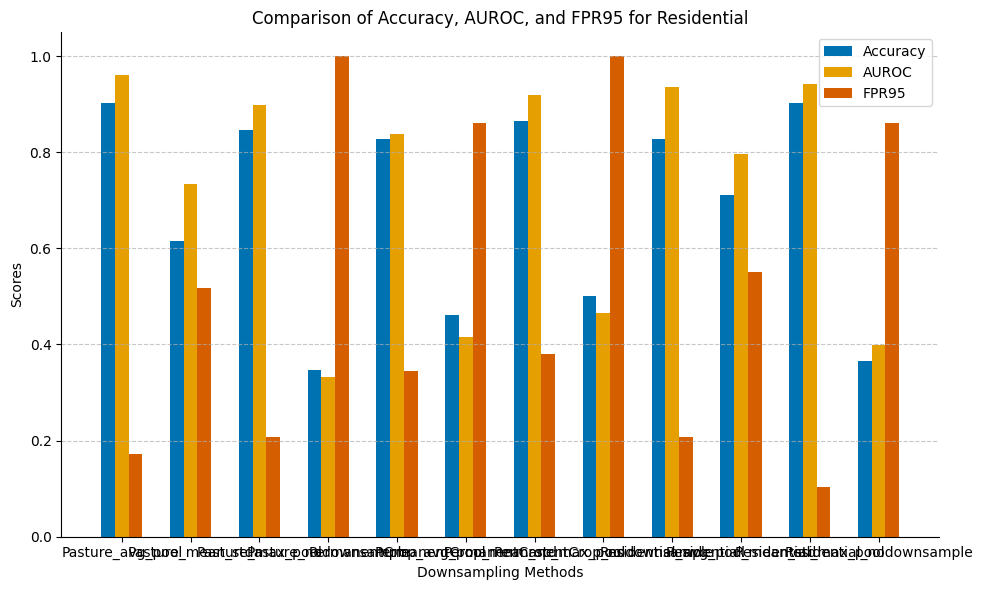

In [150]:
plot_downsample_benchmark(downsample_benchmark, datamodule.class_name)

### Layer Benchmark

In [151]:
for lyr in selected_layers:
    print(f"Running experiments for layer {lyr}")
    X, y, test_property_lengths = create_feature_matrix_and_labels(
        model=model,
        dm=datamodule,
        train_dataloader=train_dataloader,
        test_dataloader=test_dataloader,
        layer_names=lyr,
        device=device,
        getitem_keys=getitem_keys,
        n_batches_to_process=n_batches_to_process,
        downsample_method=downsample_method,
        verbose=verbose,
    )

    g_benchmark = run_g_experiment(
        X, y, split_seed, test_size, n_estimators, fixed_classifier_seed, clf=None
    )
    dict_key = datamodule.class_name + "_" + str(lyr)

    layer_benchmark[dict_key] = g_benchmark

Running experiments for layer ['conv1']


100%|██████████| 2/2 [00:00<00:00,  6.98it/s]


Before downsampling, activations shape for layer conv1 : (128, 64, 32, 32)


100%|██████████| 2/2 [00:00<00:00,  6.50it/s]


Before downsampling, activations shape for layer conv1 : (128, 64, 32, 32)
Running experiments for layer ['layer1.0.conv1']


100%|██████████| 2/2 [00:00<00:00,  6.95it/s]


Before downsampling, activations shape for layer layer1.0.conv1 : (128, 64, 16, 16)


100%|██████████| 2/2 [00:00<00:00,  7.06it/s]


Before downsampling, activations shape for layer layer1.0.conv1 : (128, 64, 16, 16)
Running experiments for layer ['layer3.3.conv1']


100%|██████████| 2/2 [00:00<00:00,  7.48it/s]


Before downsampling, activations shape for layer layer3.3.conv1 : (128, 256, 4, 4)


100%|██████████| 2/2 [00:00<00:00,  7.15it/s]


Before downsampling, activations shape for layer layer3.3.conv1 : (128, 256, 4, 4)
Running experiments for layer ['layer1.2.conv2']


100%|██████████| 2/2 [00:00<00:00,  7.15it/s]


Before downsampling, activations shape for layer layer1.2.conv2 : (128, 64, 16, 16)


100%|██████████| 2/2 [00:00<00:00,  7.25it/s]


Before downsampling, activations shape for layer layer1.2.conv2 : (128, 64, 16, 16)
Running experiments for layer ['layer3.1.conv2']


100%|██████████| 2/2 [00:00<00:00,  7.18it/s]


Before downsampling, activations shape for layer layer3.1.conv2 : (128, 256, 4, 4)


100%|██████████| 2/2 [00:00<00:00,  7.27it/s]


Before downsampling, activations shape for layer layer3.1.conv2 : (128, 256, 4, 4)
Running experiments for layer ['layer2.0.conv1']


100%|██████████| 2/2 [00:00<00:00,  7.05it/s]


Before downsampling, activations shape for layer layer2.0.conv1 : (128, 128, 16, 16)


100%|██████████| 2/2 [00:00<00:00,  6.56it/s]


Before downsampling, activations shape for layer layer2.0.conv1 : (128, 128, 16, 16)
Running experiments for layer ['layer1.0.conv3']


100%|██████████| 2/2 [00:00<00:00,  7.13it/s]


Before downsampling, activations shape for layer layer1.0.conv3 : (128, 256, 16, 16)


100%|██████████| 2/2 [00:00<00:00,  6.98it/s]


Before downsampling, activations shape for layer layer1.0.conv3 : (128, 256, 16, 16)
Running experiments for layer ['layer1.2.conv3']


100%|██████████| 2/2 [00:00<00:00,  6.80it/s]


Before downsampling, activations shape for layer layer1.2.conv3 : (128, 256, 16, 16)


100%|██████████| 2/2 [00:00<00:00,  6.46it/s]


Before downsampling, activations shape for layer layer1.2.conv3 : (128, 256, 16, 16)
Running experiments for layer ['layer4.1.conv3']


100%|██████████| 2/2 [00:00<00:00,  6.82it/s]


Before downsampling, activations shape for layer layer4.1.conv3 : (128, 2048, 2, 2)


100%|██████████| 2/2 [00:00<00:00,  7.04it/s]


Before downsampling, activations shape for layer layer4.1.conv3 : (128, 2048, 2, 2)
Running experiments for layer ['layer4.2.conv3']


100%|██████████| 2/2 [00:00<00:00,  7.33it/s]


Before downsampling, activations shape for layer layer4.2.conv3 : (128, 2048, 2, 2)


100%|██████████| 2/2 [00:00<00:00,  6.95it/s]


Before downsampling, activations shape for layer layer4.2.conv3 : (128, 2048, 2, 2)


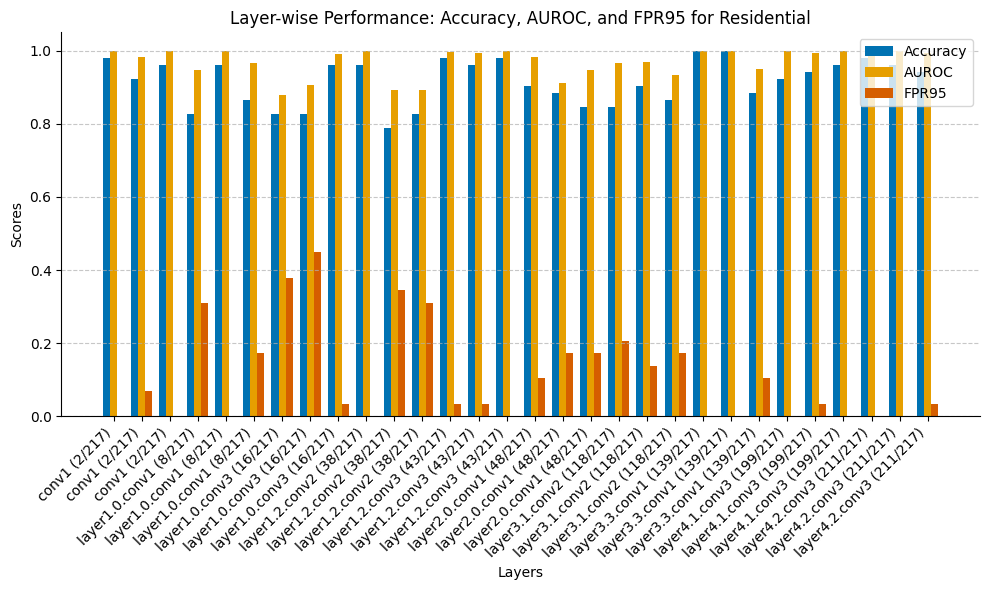

In [152]:
plot_layer_benchmark(layer_benchmark, all_layer_names, datamodule.class_name)

### g confidence interval

In [153]:
g_benchmark = run_multiple_experiments_g(
    X, y, test_size, n_estimators, random_seed=True
)

random_state for split_seed: 7219
random_state for split_seed: 3456
random_state for split_seed: 7364
random_state for split_seed: 3348
random_state for split_seed: 4099
random_state for split_seed: 535
random_state for split_seed: 9190
random_state for split_seed: 9080
random_state for split_seed: 8751
random_state for split_seed: 7844


In [154]:
columns_of_interest = ["baseline_accuracy", "baseline_fpr95", "baseline_roc_auc"]
confidence_intervals_g = calculate_confidence_intervals(
    g_benchmark, columns_of_interest
)
confidence_intervals_g

{'baseline_accuracy': (0.9346153846153846, 0.019670123528419153),
 'baseline_fpr95': (0.0855968290968291, 0.03589826933502709),
 'baseline_roc_auc': (0.9794153069153069, 0.008203491020881956)}

### g_hat

In [155]:
results_df_g_hat = run_optuna_study(
    X,
    y,
    n_optuna_trials,
    test_size,
    min_cluster,
    max_cluster_ratio,
    min_fraction,
    max_fraction,
    n_estimators,
    fixed_seed,
)

[I 2024-12-22 18:43:36,992] A new study created in memory with name: no-name-35c02db0-1caa-4170-9924-cc3937281336
[I 2024-12-22 18:43:37,060] Trial 0 finished with value: -0.7686604318599823 and parameters: {'k': 19, 'M': 0.19204005763861}. Best is trial 0 with value: -0.7686604318599823.
[I 2024-12-22 18:43:37,254] Trial 1 finished with value: -0.8711183368148488 and parameters: {'k': 48, 'M': 0.19750530058756796}. Best is trial 1 with value: -0.8711183368148488.
[I 2024-12-22 18:43:37,277] Trial 2 finished with value: inf and parameters: {'k': 14, 'M': 0.03601423928032735}. Best is trial 1 with value: -0.8711183368148488.
[I 2024-12-22 18:43:37,405] Trial 3 finished with value: -0.9029321533448658 and parameters: {'k': 56, 'M': 0.023041318415652854}. Best is trial 3 with value: -0.9029321533448658.
[I 2024-12-22 18:43:37,419] Trial 4 finished with value: inf and parameters: {'k': 6, 'M': 0.11327159100258942}. Best is trial 3 with value: -0.9029321533448658.
[I 2024-12-22 18:43:37,434

In [156]:
N = 10
results_dict = results_df_g_hat.to_dict(orient="records")
k = int(len(X) * 0.3)
M = results_dict[0]["M"]
print("k, M, len(X), k/len(X)", k, M, len(X), k / len(X))

g_hat_benchmark = run_multiple_experiments_g_hat(X, y, test_size, k, M, N, fixed_seed)

k, M, len(X), k/len(X) 76 0.023041318415652854 256 0.296875
random_state for split_seed in iteration 1: 5043
random_state for split_seed in iteration 2: 8919
random_state for split_seed in iteration 3: 8695
random_state for split_seed in iteration 4: 6077
random_state for split_seed in iteration 5: 87
random_state for split_seed in iteration 6: 6292
random_state for split_seed in iteration 7: 7284
random_state for split_seed in iteration 8: 3552
random_state for split_seed in iteration 9: 2112
random_state for split_seed in iteration 10: 3194


### g g_hat mean std + ttest

In [157]:
t_tests_results = perform_benchmark_analysis(g_benchmark, g_hat_benchmark)
t_tests_results

Baseline Accuracy: Mean = 0.9346153846153846, Std Dev = 0.02749693665324001
Baseline ROC AUC: Mean = 0.9794153069153069, Std Dev = 0.011467689697561498
Baseline FPR95: Mean = 0.0855968290968291, Std Dev = 0.05018232022996953
g_hat Accuracy: Mean = 0.7115384615384615, Std Dev = 0.08057567365369572
g_hat ROC AUC: Mean = 0.8513631113058283, Std Dev = 0.03285121254564161
g_hat FPR95: Mean = 0.4900836418483478, Std Dev = 0.16905799712274988
Accuracy: t = 8.285714285714292, p = 1.4814912395913843e-07
ROC AUC: t = 11.637694477984596, p = 8.253460913066455e-10
FPR95: t = -7.253240053395403, p = 9.609371441755218e-07


{'accuracy': (8.285714285714292, 1.4814912395913843e-07),
 'roc_auc': (11.637694477984596, 8.253460913066455e-10),
 'fpr95': (-7.253240053395403, 9.609371441755218e-07)}

### Benchmark g

In [158]:
classifier_benchmark_df = benchmark_classifiers(
    X, y, test_size, k, M, classifiers, fixed_seed
)

### Benchmark clustering

In [159]:
# A fixed classifier
classifier = classifiers['RandomForest']

clustering_benchmark_df = benchmark_clustering_methods(
    X, y, test_size, k, M, clustering_methods, classifier
)

clustering_benchmark_df

Clustering  Accuracy  ROC_AUC  FPR95  Clustering Time (s)  \
0          KMeans  0.461538      0.5    1.0             0.006266   
1  DBSCAN_eps_0.1  0.538462      0.5    1.0             0.005910   
2  DBSCAN_eps_0.2  0.538462      0.5    1.0             0.005390   
3  DBSCAN_eps_0.5  0.538462      0.5    1.0             0.005140   

   Classifier Training Time (s)  Number of Samples  
0                      0.093159                204  
1                      0.090710                204  
2                      0.091255                204  
3                      0.091145                204

### Investigate k wrt g-g_hat

In [ ]:
print("confidence_intervals_g", confidence_intervals_g)

df_results = benchmark_kmeans_with_varying_k_condidence_g_hat(
    X,
    y,
    M,
    test_size,
    n_runs=10,
    confidence_level=0.95,
    confidence_intervals_g=confidence_intervals_g,
    clf=None,
    save_plot=True,
    fname=cfg_dict["data"]["class_name"],
)

### Feature Level Visualization: Understand how clustering alters the structure of the feature space

Proportion of label changes: 0.27


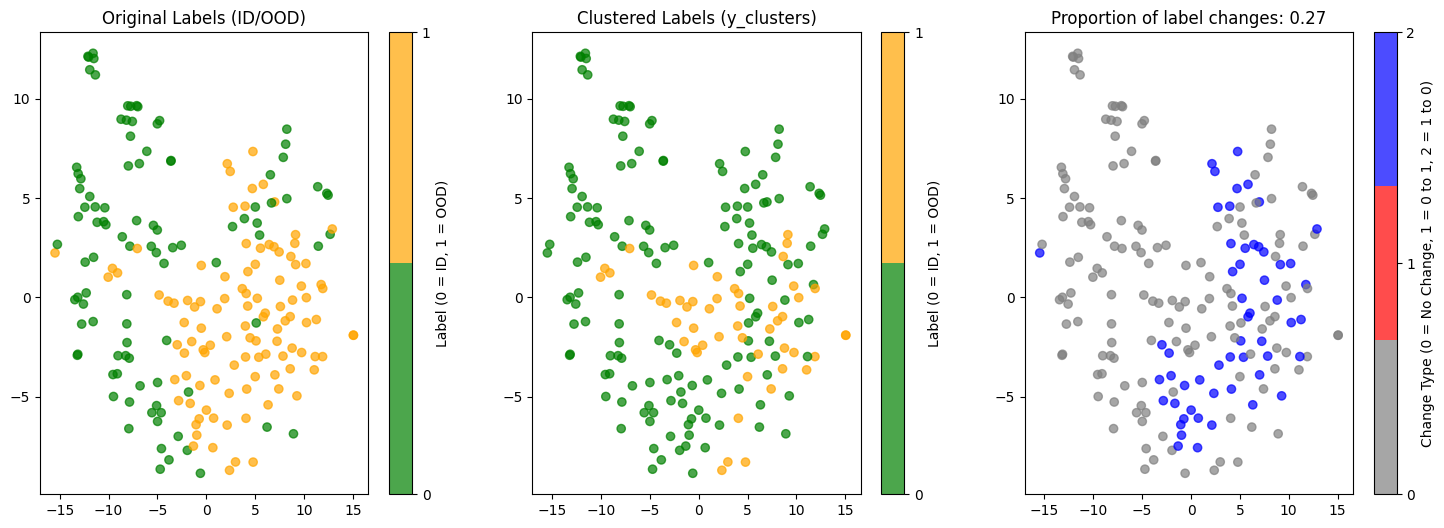

In [160]:
i = 0
_, X_train_cluster, y_train_cluster, y_clusters, *_ = run_g_hat_experiment(
    X, y, test_size, k, M, fixed_seed, fixed_seed, i + 1
)
plot_tsne_with_label_changes(
    X_train_cluster,
    y_train_cluster,
    y_clusters,
    class_name=cfg_dict.data.class_name,
    save_plot=True,
)

# River

### Start

In [161]:
X,y,model,datamodule,train_dataloader,val_dataloader,test_dataloader,cfg_dict = get_X_y_arrays(
        paths["river"]["config"],
        paths["river"]["ckpt"],
        layer,
        downsample_method,
        getitem_keys,
        device,
        n_batches_to_process,
        mode="holdout",
        verbose=False,
    )

Model and Task are loaded.
download True
Loaded statistics for River: MEAN={'B01': 1354.4058837890625, 'B02': 1118.2442626953125, 'B03': 1042.9290771484375, 'B04': 947.6262817382812, 'B05': 1199.4730224609375, 'B06': 1999.7908935546875, 'B07': 2369.2236328125, 'B08': 2296.826416015625, 'B8A': 732.0831909179688, 'B09': 12.113275527954102, 'B10': 1819.0098876953125, 'B11': 1118.9239501953125, 'B12': 2594.142333984375}, STD={'B01': 245.7181396484375, 'B02': 333.00836181640625, 'B03': 395.0932922363281, 'B04': 593.7514038085938, 'B05': 566.4178466796875, 'B06': 861.1854858398438, 'B07': 1086.6336669921875, 'B08': 1117.984130859375, 'B8A': 404.9206237792969, 'B09': 4.775853633880615, 'B10': 1002.5897216796875, 'B11': 761.3046264648438, 'B12': 1231.587890625}
self.split_urls {'train': 'https://huggingface.co/datasets/brkekm/EuroSATHoldOutSplits/resolve/main/train_river.txt', 'val': 'https://huggingface.co/datasets/brkekm/EuroSATHoldOutSplits/resolve/main/val_river.txt', 'test': 'https://hugg

100%|██████████| 2067725275/2067725275 [00:09<00:00, 218389386.36it/s]


100%|██████████| 291220/291220 [00:00<00:00, 9095998.17it/s]


100%|██████████| 194817/194817 [00:00<00:00, 7531492.27it/s]


100%|██████████| 36393/36393 [00:00<00:00, 24892906.96it/s]


classes and class to idx ['SeaLake', 'Residential', 'PermanentCrop', 'Industrial', 'Pasture', 'Forest', 'AnnualCrop', 'HerbaceousVegetation', 'Highway'] {'AnnualCrop': 0, 'Forest': 1, 'HerbaceousVegetation': 2, 'Highway': 3, 'Industrial': 4, 'Pasture': 5, 'PermanentCrop': 6, 'Residential': 7, 'SeaLake': 8}
self.train_dataset.split_urls {'train': 'https://huggingface.co/datasets/brkekm/EuroSATHoldOutSplits/resolve/main/train_river.txt', 'val': 'https://huggingface.co/datasets/brkekm/EuroSATHoldOutSplits/resolve/main/val_river.txt', 'test': 'https://huggingface.co/datasets/brkekm/EuroSATHoldOutSplits/resolve/main/test_river.txt'}
self.split_urls {'train': 'https://huggingface.co/datasets/brkekm/EuroSATHoldOutSplits/resolve/main/train_river.txt', 'val': 'https://huggingface.co/datasets/brkekm/EuroSATHoldOutSplits/resolve/main/val_river.txt', 'test': 'https://huggingface.co/datasets/brkekm/EuroSATHoldOutSplits/resolve/main/test_river.txt'}
self.root /data/dataood/eurosat_holdout_datasets/e

100%|██████████| 2/2 [00:00<00:00,  7.11it/s]


Before downsampling, activations shape for layer conv1 : (128, 64, 32, 32)


100%|██████████| 2/2 [00:00<00:00,  6.86it/s]


Before downsampling, activations shape for layer conv1 : (128, 64, 32, 32)


### Downsample Benchmark

In [162]:
for downsample in downsample_methods:
    print(f"Running experiments for {downsample} downsample method.")
    X, y, test_property_lengths = create_feature_matrix_and_labels(
        model=model,
        dm=datamodule,
        train_dataloader=train_dataloader,
        test_dataloader=test_dataloader,
        layer_names=collect_activations_from_layers,
        device=device,
        getitem_keys=getitem_keys,
        n_batches_to_process=n_batches_to_process,
        downsample_method=downsample,
        verbose=verbose,
    )
    print("Run g experiment for downsample method:", downsample)
    g_benchmark = run_g_experiment(
        X, y, split_seed, test_size, n_estimators, fixed_classifier_seed, clf=None
    )
    dict_key = datamodule.class_name + "_" + downsample
    downsample_benchmark[dict_key] = g_benchmark

Running experiments for avg_pool downsample method.


100%|██████████| 2/2 [00:00<00:00,  6.87it/s]


Before downsampling, activations shape for layer conv1 : (128, 64, 32, 32)


100%|██████████| 2/2 [00:00<00:00,  6.70it/s]


Before downsampling, activations shape for layer conv1 : (128, 64, 32, 32)
Run g experiment for downsample method: avg_pool
Running experiments for mean_std downsample method.


100%|██████████| 2/2 [00:00<00:00,  6.94it/s]


Before downsampling, activations shape for layer conv1 : (128, 64, 32, 32)


100%|██████████| 2/2 [00:00<00:00,  6.97it/s]


Before downsampling, activations shape for layer conv1 : (128, 64, 32, 32)
Run g experiment for downsample method: mean_std
Running experiments for avg_pool downsample method.


100%|██████████| 2/2 [00:00<00:00,  6.90it/s]


Before downsampling, activations shape for layer conv1 : (128, 64, 32, 32)


100%|██████████| 2/2 [00:00<00:00,  6.69it/s]


Before downsampling, activations shape for layer conv1 : (128, 64, 32, 32)
Run g experiment for downsample method: avg_pool
Running experiments for max_pool downsample method.


100%|██████████| 2/2 [00:00<00:00,  6.82it/s]


Before downsampling, activations shape for layer conv1 : (128, 64, 32, 32)


100%|██████████| 2/2 [00:00<00:00,  6.93it/s]


Before downsampling, activations shape for layer conv1 : (128, 64, 32, 32)
Run g experiment for downsample method: max_pool
Running experiments for nodownsample downsample method.


100%|██████████| 2/2 [00:00<00:00,  6.70it/s]


Before downsampling, activations shape for layer conv1 : (128, 64, 32, 32)


100%|██████████| 2/2 [00:00<00:00,  6.42it/s]


Before downsampling, activations shape for layer conv1 : (128, 64, 32, 32)
Run g experiment for downsample method: nodownsample


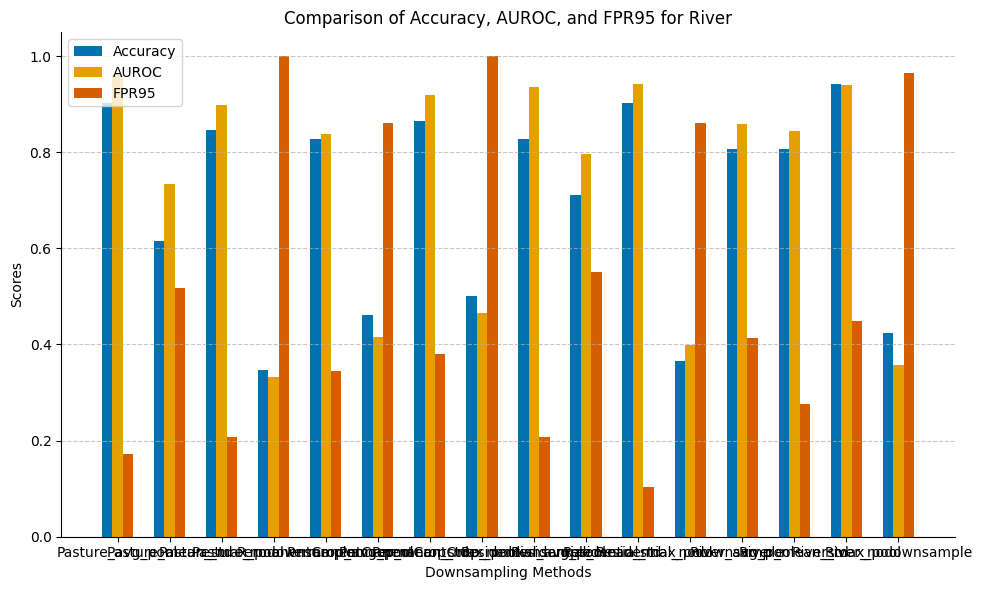

In [163]:
plot_downsample_benchmark(downsample_benchmark, datamodule.class_name)

### Layer Benchmark

In [164]:
for lyr in selected_layers:
    print(f"Running experiments for layer {lyr}")
    X, y, test_property_lengths = create_feature_matrix_and_labels(
        model=model,
        dm=datamodule,
        train_dataloader=train_dataloader,
        test_dataloader=test_dataloader,
        layer_names=lyr,
        device=device,
        getitem_keys=getitem_keys,
        n_batches_to_process=n_batches_to_process,
        downsample_method=downsample_method,
        verbose=verbose,
    )

    g_benchmark = run_g_experiment(
        X, y, split_seed, test_size, n_estimators, fixed_classifier_seed, clf=None
    )
    dict_key = datamodule.class_name + "_" + str(lyr)

    layer_benchmark[dict_key] = g_benchmark

Running experiments for layer ['conv1']


100%|██████████| 2/2 [00:00<00:00,  6.89it/s]


Before downsampling, activations shape for layer conv1 : (128, 64, 32, 32)


100%|██████████| 2/2 [00:00<00:00,  6.75it/s]


Before downsampling, activations shape for layer conv1 : (128, 64, 32, 32)
Running experiments for layer ['layer1.0.conv1']


100%|██████████| 2/2 [00:00<00:00,  7.58it/s]


Before downsampling, activations shape for layer layer1.0.conv1 : (128, 64, 16, 16)


100%|██████████| 2/2 [00:00<00:00,  6.99it/s]


Before downsampling, activations shape for layer layer1.0.conv1 : (128, 64, 16, 16)
Running experiments for layer ['layer3.3.conv1']


100%|██████████| 2/2 [00:00<00:00,  7.26it/s]


Before downsampling, activations shape for layer layer3.3.conv1 : (128, 256, 4, 4)


100%|██████████| 2/2 [00:00<00:00,  7.23it/s]


Before downsampling, activations shape for layer layer3.3.conv1 : (128, 256, 4, 4)
Running experiments for layer ['layer1.2.conv2']


100%|██████████| 2/2 [00:00<00:00,  6.50it/s]


Before downsampling, activations shape for layer layer1.2.conv2 : (128, 64, 16, 16)


100%|██████████| 2/2 [00:00<00:00,  7.43it/s]


Before downsampling, activations shape for layer layer1.2.conv2 : (128, 64, 16, 16)
Running experiments for layer ['layer3.1.conv2']


100%|██████████| 2/2 [00:00<00:00,  7.30it/s]


Before downsampling, activations shape for layer layer3.1.conv2 : (128, 256, 4, 4)


100%|██████████| 2/2 [00:00<00:00,  7.23it/s]


Before downsampling, activations shape for layer layer3.1.conv2 : (128, 256, 4, 4)
Running experiments for layer ['layer2.0.conv1']


100%|██████████| 2/2 [00:00<00:00,  6.97it/s]


Before downsampling, activations shape for layer layer2.0.conv1 : (128, 128, 16, 16)


100%|██████████| 2/2 [00:00<00:00,  6.61it/s]


Before downsampling, activations shape for layer layer2.0.conv1 : (128, 128, 16, 16)
Running experiments for layer ['layer1.0.conv3']


100%|██████████| 2/2 [00:00<00:00,  6.56it/s]


Before downsampling, activations shape for layer layer1.0.conv3 : (128, 256, 16, 16)


100%|██████████| 2/2 [00:00<00:00,  6.86it/s]


Before downsampling, activations shape for layer layer1.0.conv3 : (128, 256, 16, 16)
Running experiments for layer ['layer1.2.conv3']


100%|██████████| 2/2 [00:00<00:00,  6.64it/s]


Before downsampling, activations shape for layer layer1.2.conv3 : (128, 256, 16, 16)


100%|██████████| 2/2 [00:00<00:00,  6.96it/s]


Before downsampling, activations shape for layer layer1.2.conv3 : (128, 256, 16, 16)
Running experiments for layer ['layer4.1.conv3']


100%|██████████| 2/2 [00:00<00:00,  7.10it/s]


Before downsampling, activations shape for layer layer4.1.conv3 : (128, 2048, 2, 2)


100%|██████████| 2/2 [00:00<00:00,  7.10it/s]


Before downsampling, activations shape for layer layer4.1.conv3 : (128, 2048, 2, 2)
Running experiments for layer ['layer4.2.conv3']


100%|██████████| 2/2 [00:00<00:00,  7.18it/s]


Before downsampling, activations shape for layer layer4.2.conv3 : (128, 2048, 2, 2)


100%|██████████| 2/2 [00:00<00:00,  7.29it/s]


Before downsampling, activations shape for layer layer4.2.conv3 : (128, 2048, 2, 2)


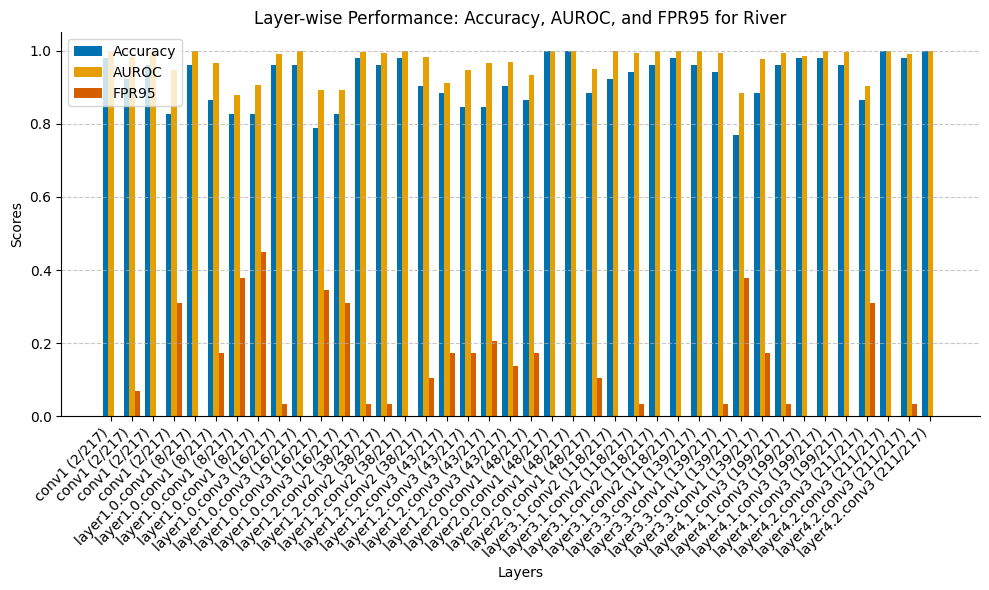

In [165]:
plot_layer_benchmark(layer_benchmark, all_layer_names, datamodule.class_name)

### g confidence interval

In [166]:
g_benchmark = run_multiple_experiments_g(
    X, y, test_size, n_estimators, random_seed=True
)

random_state for split_seed: 3367
random_state for split_seed: 2352
random_state for split_seed: 5934
random_state for split_seed: 6812
random_state for split_seed: 860
random_state for split_seed: 1113
random_state for split_seed: 8561
random_state for split_seed: 87
random_state for split_seed: 5185
random_state for split_seed: 4429


In [167]:
columns_of_interest = ["baseline_accuracy", "baseline_fpr95", "baseline_roc_auc"]
confidence_intervals_g = calculate_confidence_intervals(
    g_benchmark, columns_of_interest
)
confidence_intervals_g

{'baseline_accuracy': (0.9519230769230769, 0.016212619204903276),
 'baseline_fpr95': (0.0699989824989825, 0.05623522341578965),
 'baseline_roc_auc': (0.9875308762640493, 0.007778534149403569)}

### g_hat

In [168]:
results_df_g_hat = run_optuna_study(
    X,
    y,
    n_optuna_trials,
    test_size,
    min_cluster,
    max_cluster_ratio,
    min_fraction,
    max_fraction,
    n_estimators,
    fixed_seed,
)

[I 2024-12-22 18:45:12,742] A new study created in memory with name: no-name-066805fb-07f9-42dd-8e93-730b86c989a5
[I 2024-12-22 18:45:12,803] Trial 0 finished with value: -0.8126063894064016 and parameters: {'k': 19, 'M': 0.19204005763861}. Best is trial 0 with value: -0.8126063894064016.
[I 2024-12-22 18:45:12,993] Trial 1 finished with value: -0.9274221804387206 and parameters: {'k': 48, 'M': 0.19750530058756796}. Best is trial 1 with value: -0.9274221804387206.
[I 2024-12-22 18:45:13,048] Trial 2 finished with value: -0.8506905322633603 and parameters: {'k': 14, 'M': 0.03601423928032735}. Best is trial 1 with value: -0.9274221804387206.
[I 2024-12-22 18:45:13,165] Trial 3 finished with value: -0.9217548532693155 and parameters: {'k': 56, 'M': 0.023041318415652854}. Best is trial 1 with value: -0.9274221804387206.
[I 2024-12-22 18:45:13,201] Trial 4 finished with value: -0.7580610703267185 and parameters: {'k': 6, 'M': 0.11327159100258942}. Best is trial 1 with value: -0.927422180438

In [169]:
N = 10
results_dict = results_df_g_hat.to_dict(orient="records")
k = int(len(X) * 0.3)
M = results_dict[0]["M"]
print("k, M, len(X), k/len(X)", k, M, len(X), k / len(X))

g_hat_benchmark = run_multiple_experiments_g_hat(X, y, test_size, k, M, N, fixed_seed)

k, M, len(X), k/len(X) 76 0.18119467821615412 256 0.296875
random_state for split_seed in iteration 1: 5012
random_state for split_seed in iteration 2: 2101
random_state for split_seed in iteration 3: 9312
random_state for split_seed in iteration 4: 8668
random_state for split_seed in iteration 5: 6952
random_state for split_seed in iteration 6: 5711
random_state for split_seed in iteration 7: 6089
random_state for split_seed in iteration 8: 2457
random_state for split_seed in iteration 9: 4127
random_state for split_seed in iteration 10: 3274


### g g_hat mean std + ttest

In [170]:
t_tests_results = perform_benchmark_analysis(g_benchmark, g_hat_benchmark)
t_tests_results

Baseline Accuracy: Mean = 0.9519230769230769, Std Dev = 0.022663678884184187
Baseline ROC AUC: Mean = 0.9875308762640493, Std Dev = 0.01087364095361142
Baseline FPR95: Mean = 0.0699989824989825, Std Dev = 0.07861142171835866
g_hat Accuracy: Mean = 0.8307692307692308, Std Dev = 0.07241036536637403
g_hat ROC AUC: Mean = 0.9296335998231161, Std Dev = 0.039296112446382515
g_hat FPR95: Mean = 0.27736507936507937, Std Dev = 0.1711413791976707
Accuracy: t = 5.04943442462275, p = 8.34313801022334e-05
ROC AUC: t = 4.490427499635349, p = 0.0002829106751867742
FPR95: t = -3.481869596127167, p = 0.002661729261788438


{'accuracy': (5.04943442462275, 8.34313801022334e-05),
 'roc_auc': (4.490427499635349, 0.0002829106751867742),
 'fpr95': (-3.481869596127167, 0.002661729261788438)}

### Benchmark g

In [171]:
classifier_benchmark_df = benchmark_classifiers(
    X, y, test_size, k, M, classifiers, fixed_seed
)

### Benchmark clustering

In [172]:
# A fixed classifier
classifier = classifiers['RandomForest']

clustering_benchmark_df = benchmark_clustering_methods(
    X, y, test_size, k, M, clustering_methods, classifier
)

clustering_benchmark_df

Clustering  Accuracy   ROC_AUC  FPR95  Clustering Time (s)  \
0          KMeans  0.903846  0.936012  0.125             0.006212   
1  DBSCAN_eps_0.1  0.538462  0.500000  1.000             0.006028   
2  DBSCAN_eps_0.2  0.538462  0.500000  1.000             0.005211   
3  DBSCAN_eps_0.5  0.538462  0.500000  1.000             0.005277   

   Classifier Training Time (s)  Number of Samples  
0                      0.288262                204  
1                      0.090056                204  
2                      0.089362                204  
3                      0.089838                204

### Investigate k wrt g-g_hat

confidence_intervals_g {'baseline_accuracy': (0.9519230769230769, 0.016212619204903276), 'baseline_fpr95': (0.0699989824989825, 0.05623522341578965), 'baseline_roc_auc': (0.9875308762640493, 0.007778534149403569)}
Max i: 7
k: 1
Skipping k=1 on run 1 due to single class in y_clusters.
Skipping k=1 on run 2 due to single class in y_clusters.
Skipping k=1 on run 3 due to single class in y_clusters.
Skipping k=1 on run 4 due to single class in y_clusters.
Skipping k=1 on run 5 due to single class in y_clusters.
Skipping k=1 on run 6 due to single class in y_clusters.
Skipping k=1 on run 7 due to single class in y_clusters.
Skipping k=1 on run 8 due to single class in y_clusters.
Skipping k=1 on run 9 due to single class in y_clusters.
Skipping k=1 on run 10 due to single class in y_clusters.
k: 2
Skipping k=2 on run 2 due to single class in y_clusters.
Skipping k=2 on run 3 due to single class in y_clusters.
Skipping k=2 on run 4 due to single class in y_clusters.
Skipping k=2 on run 7 due

/ws/geospatial-ood-detection/notebooks/../src/tardis/eurosat_xbd_utils.py:989: RuntimeWarning: Mean of empty slice
  mean = np.nanmean(values)
/ws/geospatial-ood-detection/notebooks/../src/tardis/eurosat_xbd_utils.py:990: SmallSampleWarning: One or more sample arguments is too small; all returned values will be NaN. See documentation for sample size requirements.
  sem = stats.sem(values, nan_policy="omit")


k: 8
k: 16
k: 32
k: 64
k: 128
k: 204


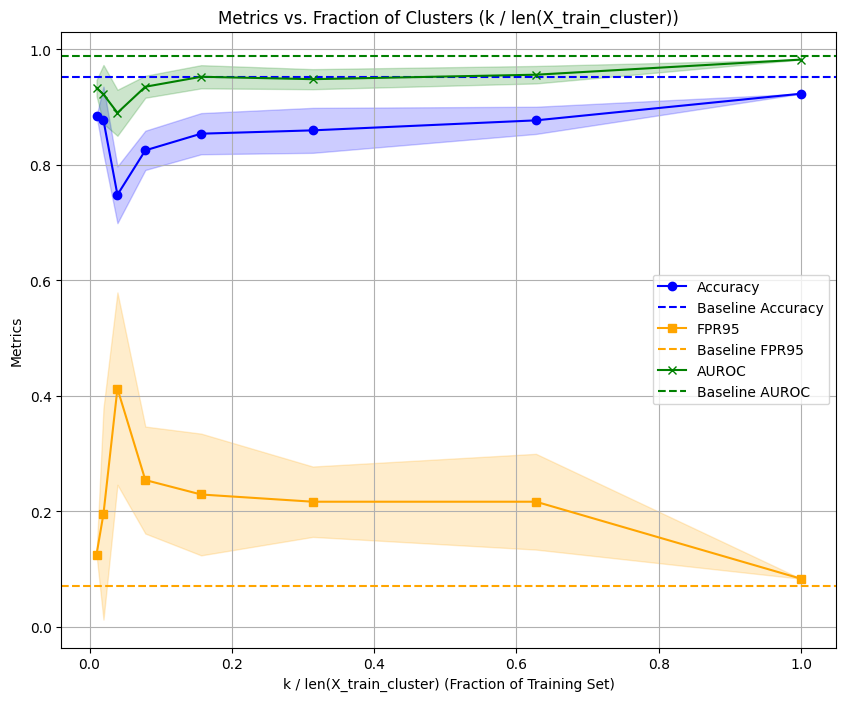

In [174]:
print("confidence_intervals_g", confidence_intervals_g)

df_results = benchmark_kmeans_with_varying_k_condidence_g_hat(
    X,
    y,
    M,
    test_size,
    n_runs=10,
    confidence_level=0.95,
    confidence_intervals_g=confidence_intervals_g,
    clf=None,
    save_plot=True,
    fname=cfg_dict["data"]["class_name"],
)

### Feature Level Visualization: Understand how clustering alters the structure of the feature space

Proportion of label changes: 0.10


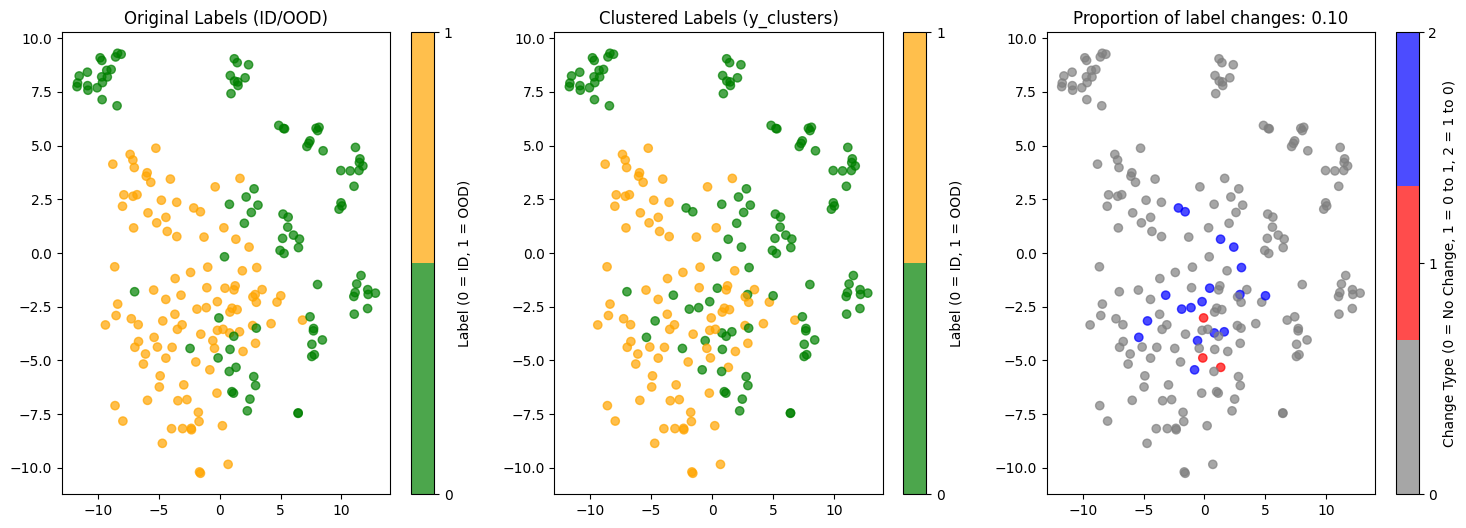

In [175]:
i = 0
_, X_train_cluster, y_train_cluster, y_clusters, *_ = run_g_hat_experiment(
    X, y, test_size, k, M, fixed_seed, fixed_seed, i + 1
)
plot_tsne_with_label_changes(
    X_train_cluster,
    y_train_cluster,
    y_clusters,
    class_name=cfg_dict.data.class_name,
    save_plot=True,
)

# SeaLake

### Start

In [176]:
X,y,model,datamodule,train_dataloader,val_dataloader,test_dataloader,cfg_dict = get_X_y_arrays(
        paths["sealake"]["config"],
        paths["sealake"]["ckpt"],
        layer,
        downsample_method,
        getitem_keys,
        device,
        n_batches_to_process,
        mode="holdout",
        verbose=False,
    )

Model and Task are loaded.
download True
Loaded statistics for SeaLake: MEAN={'B01': 1354.4056396484375, 'B02': 1118.243896484375, 'B03': 1042.9287109375, 'B04': 947.6258544921875, 'B05': 1199.4737548828125, 'B06': 1999.790771484375, 'B07': 2369.22314453125, 'B08': 2296.825439453125, 'B8A': 732.08349609375, 'B09': 12.113273620605469, 'B10': 1819.0096435546875, 'B11': 1118.9234619140625, 'B12': 2594.14111328125}, STD={'B01': 245.71804809570312, 'B02': 333.0084228515625, 'B03': 395.0931701660156, 'B04': 593.751708984375, 'B05': 566.4180908203125, 'B06': 861.1856079101562, 'B07': 1086.6339111328125, 'B08': 1117.9837646484375, 'B8A': 404.92059326171875, 'B09': 4.775854110717773, 'B10': 1002.5894775390625, 'B11': 761.3046264648438, 'B12': 1231.5885009765625}
self.split_urls {'train': 'https://huggingface.co/datasets/brkekm/EuroSATHoldOutSplits/resolve/main/train_sealake.txt', 'val': 'https://huggingface.co/datasets/brkekm/EuroSATHoldOutSplits/resolve/main/val_sealake.txt', 'test': 'https://

100%|██████████| 2067725275/2067725275 [00:09<00:00, 222507820.12it/s]


100%|██████████| 282832/282832 [00:00<00:00, 2854256.88it/s]


100%|██████████| 189705/189705 [00:00<00:00, 7127964.67it/s]


100%|██████████| 49893/49893 [00:00<00:00, 6698668.68it/s]


classes and class to idx ['Residential', 'PermanentCrop', 'Industrial', 'Pasture', 'Forest', 'AnnualCrop', 'HerbaceousVegetation', 'River', 'Highway'] {'AnnualCrop': 0, 'Forest': 1, 'HerbaceousVegetation': 2, 'Highway': 3, 'Industrial': 4, 'Pasture': 5, 'PermanentCrop': 6, 'Residential': 7, 'River': 8}
self.train_dataset.split_urls {'train': 'https://huggingface.co/datasets/brkekm/EuroSATHoldOutSplits/resolve/main/train_sealake.txt', 'val': 'https://huggingface.co/datasets/brkekm/EuroSATHoldOutSplits/resolve/main/val_sealake.txt', 'test': 'https://huggingface.co/datasets/brkekm/EuroSATHoldOutSplits/resolve/main/test_sealake.txt'}
self.split_urls {'train': 'https://huggingface.co/datasets/brkekm/EuroSATHoldOutSplits/resolve/main/train_sealake.txt', 'val': 'https://huggingface.co/datasets/brkekm/EuroSATHoldOutSplits/resolve/main/val_sealake.txt', 'test': 'https://huggingface.co/datasets/brkekm/EuroSATHoldOutSplits/resolve/main/test_sealake.txt'}
self.root /data/dataood/eurosat_holdout_da

100%|██████████| 2/2 [00:00<00:00,  6.94it/s]


Before downsampling, activations shape for layer conv1 : (128, 64, 32, 32)


100%|██████████| 2/2 [00:00<00:00,  7.08it/s]


Before downsampling, activations shape for layer conv1 : (128, 64, 32, 32)


### Downsample Benchmark

In [177]:
for downsample in downsample_methods:
    print(f"Running experiments for {downsample} downsample method.")
    X, y, test_property_lengths = create_feature_matrix_and_labels(
        model=model,
        dm=datamodule,
        train_dataloader=train_dataloader,
        test_dataloader=test_dataloader,
        layer_names=collect_activations_from_layers,
        device=device,
        getitem_keys=getitem_keys,
        n_batches_to_process=n_batches_to_process,
        downsample_method=downsample,
        verbose=verbose,
    )
    print("Run g experiment for downsample method:", downsample)
    g_benchmark = run_g_experiment(
        X, y, split_seed, test_size, n_estimators, fixed_classifier_seed, clf=None
    )
    dict_key = datamodule.class_name + "_" + downsample
    downsample_benchmark[dict_key] = g_benchmark

Running experiments for avg_pool downsample method.


100%|██████████| 2/2 [00:00<00:00,  6.97it/s]


Before downsampling, activations shape for layer conv1 : (128, 64, 32, 32)


100%|██████████| 2/2 [00:00<00:00,  7.28it/s]


Before downsampling, activations shape for layer conv1 : (128, 64, 32, 32)
Run g experiment for downsample method: avg_pool
Running experiments for mean_std downsample method.


100%|██████████| 2/2 [00:00<00:00,  6.70it/s]


Before downsampling, activations shape for layer conv1 : (128, 64, 32, 32)


100%|██████████| 2/2 [00:00<00:00,  6.86it/s]


Before downsampling, activations shape for layer conv1 : (128, 64, 32, 32)
Run g experiment for downsample method: mean_std
Running experiments for avg_pool downsample method.


100%|██████████| 2/2 [00:00<00:00,  6.80it/s]


Before downsampling, activations shape for layer conv1 : (128, 64, 32, 32)


100%|██████████| 2/2 [00:00<00:00,  7.04it/s]


Before downsampling, activations shape for layer conv1 : (128, 64, 32, 32)
Run g experiment for downsample method: avg_pool
Running experiments for max_pool downsample method.


100%|██████████| 2/2 [00:00<00:00,  6.87it/s]


Before downsampling, activations shape for layer conv1 : (128, 64, 32, 32)


100%|██████████| 2/2 [00:00<00:00,  6.85it/s]


Before downsampling, activations shape for layer conv1 : (128, 64, 32, 32)
Run g experiment for downsample method: max_pool
Running experiments for nodownsample downsample method.


100%|██████████| 2/2 [00:00<00:00,  6.85it/s]


Before downsampling, activations shape for layer conv1 : (128, 64, 32, 32)


100%|██████████| 2/2 [00:00<00:00,  6.82it/s]


Before downsampling, activations shape for layer conv1 : (128, 64, 32, 32)
Run g experiment for downsample method: nodownsample


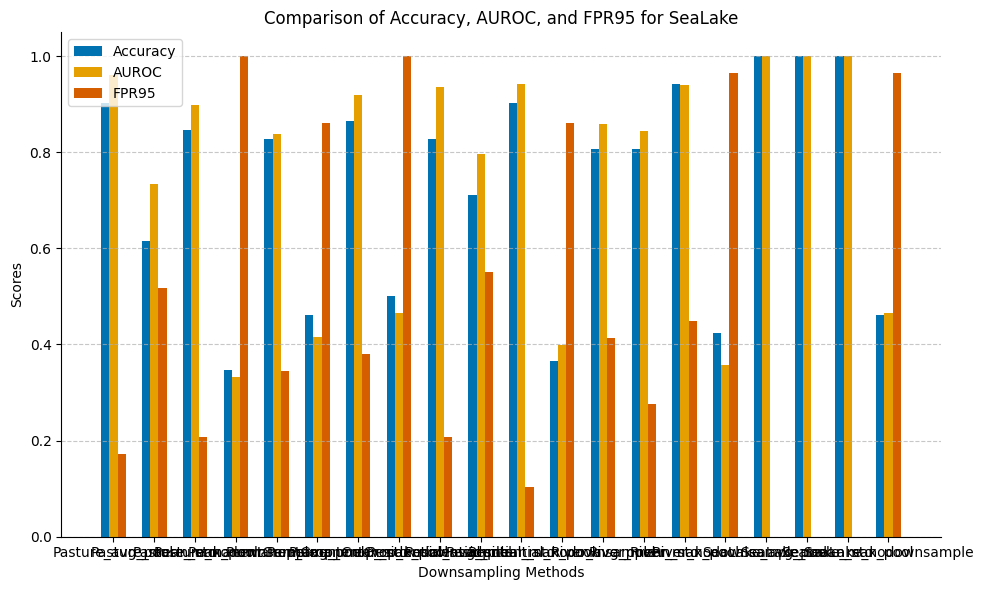

In [178]:
plot_downsample_benchmark(downsample_benchmark, datamodule.class_name)

### Layer Benchmark

In [179]:
for lyr in selected_layers:
    print(f"Running experiments for layer {lyr}")
    X, y, test_property_lengths = create_feature_matrix_and_labels(
        model=model,
        dm=datamodule,
        train_dataloader=train_dataloader,
        test_dataloader=test_dataloader,
        layer_names=lyr,
        device=device,
        getitem_keys=getitem_keys,
        n_batches_to_process=n_batches_to_process,
        downsample_method=downsample_method,
        verbose=verbose,
    )

    g_benchmark = run_g_experiment(
        X, y, split_seed, test_size, n_estimators, fixed_classifier_seed, clf=None
    )
    dict_key = datamodule.class_name + "_" + str(lyr)

    layer_benchmark[dict_key] = g_benchmark

Running experiments for layer ['conv1']


100%|██████████| 2/2 [00:00<00:00,  6.75it/s]


Before downsampling, activations shape for layer conv1 : (128, 64, 32, 32)


100%|██████████| 2/2 [00:00<00:00,  7.04it/s]


Before downsampling, activations shape for layer conv1 : (128, 64, 32, 32)
Running experiments for layer ['layer1.0.conv1']


100%|██████████| 2/2 [00:00<00:00,  6.65it/s]


Before downsampling, activations shape for layer layer1.0.conv1 : (128, 64, 16, 16)


100%|██████████| 2/2 [00:00<00:00,  7.39it/s]


Before downsampling, activations shape for layer layer1.0.conv1 : (128, 64, 16, 16)
Running experiments for layer ['layer3.3.conv1']


100%|██████████| 2/2 [00:00<00:00,  7.37it/s]


Before downsampling, activations shape for layer layer3.3.conv1 : (128, 256, 4, 4)


100%|██████████| 2/2 [00:00<00:00,  7.12it/s]


Before downsampling, activations shape for layer layer3.3.conv1 : (128, 256, 4, 4)
Running experiments for layer ['layer1.2.conv2']


100%|██████████| 2/2 [00:00<00:00,  7.00it/s]


Before downsampling, activations shape for layer layer1.2.conv2 : (128, 64, 16, 16)


100%|██████████| 2/2 [00:00<00:00,  7.28it/s]


Before downsampling, activations shape for layer layer1.2.conv2 : (128, 64, 16, 16)
Running experiments for layer ['layer3.1.conv2']


100%|██████████| 2/2 [00:00<00:00,  7.28it/s]


Before downsampling, activations shape for layer layer3.1.conv2 : (128, 256, 4, 4)


100%|██████████| 2/2 [00:00<00:00,  7.22it/s]


Before downsampling, activations shape for layer layer3.1.conv2 : (128, 256, 4, 4)
Running experiments for layer ['layer2.0.conv1']


100%|██████████| 2/2 [00:00<00:00,  7.02it/s]


Before downsampling, activations shape for layer layer2.0.conv1 : (128, 128, 16, 16)


100%|██████████| 2/2 [00:00<00:00,  7.30it/s]


Before downsampling, activations shape for layer layer2.0.conv1 : (128, 128, 16, 16)
Running experiments for layer ['layer1.0.conv3']


100%|██████████| 2/2 [00:00<00:00,  6.99it/s]


Before downsampling, activations shape for layer layer1.0.conv3 : (128, 256, 16, 16)


100%|██████████| 2/2 [00:00<00:00,  6.95it/s]


Before downsampling, activations shape for layer layer1.0.conv3 : (128, 256, 16, 16)
Running experiments for layer ['layer1.2.conv3']


100%|██████████| 2/2 [00:00<00:00,  6.80it/s]


Before downsampling, activations shape for layer layer1.2.conv3 : (128, 256, 16, 16)


100%|██████████| 2/2 [00:00<00:00,  6.73it/s]


Before downsampling, activations shape for layer layer1.2.conv3 : (128, 256, 16, 16)
Running experiments for layer ['layer4.1.conv3']


100%|██████████| 2/2 [00:00<00:00,  7.53it/s]


Before downsampling, activations shape for layer layer4.1.conv3 : (128, 2048, 2, 2)


100%|██████████| 2/2 [00:00<00:00,  7.20it/s]


Before downsampling, activations shape for layer layer4.1.conv3 : (128, 2048, 2, 2)
Running experiments for layer ['layer4.2.conv3']


100%|██████████| 2/2 [00:00<00:00,  6.97it/s]


Before downsampling, activations shape for layer layer4.2.conv3 : (128, 2048, 2, 2)


100%|██████████| 2/2 [00:00<00:00,  7.32it/s]


Before downsampling, activations shape for layer layer4.2.conv3 : (128, 2048, 2, 2)


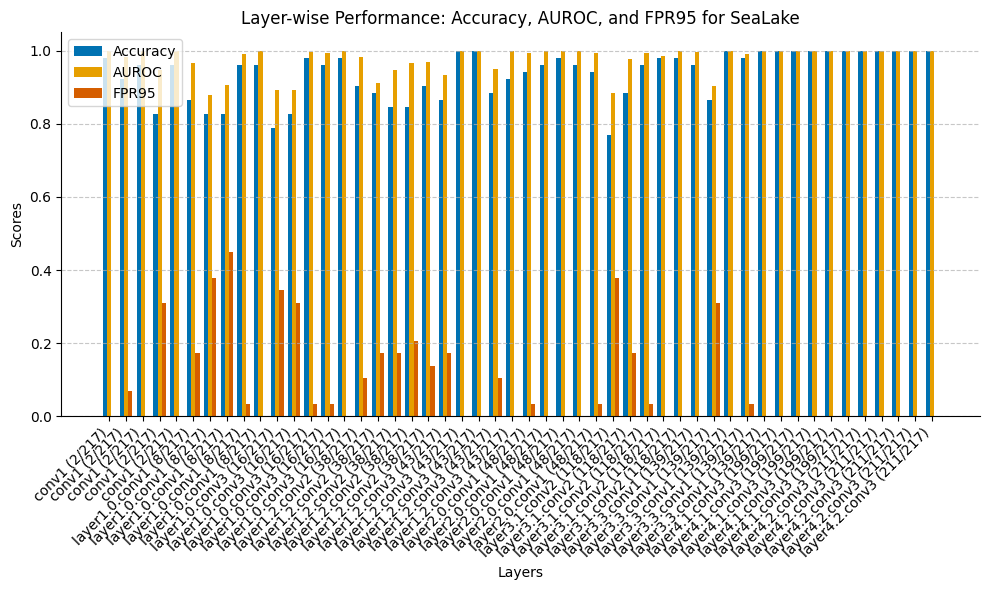

In [180]:
plot_layer_benchmark(layer_benchmark, all_layer_names, datamodule.class_name)

### g confidence interval

In [181]:
g_benchmark = run_multiple_experiments_g(
    X, y, test_size, n_estimators, random_seed=True
)

random_state for split_seed: 4187
random_state for split_seed: 3338
random_state for split_seed: 8985
random_state for split_seed: 9230
random_state for split_seed: 5707
random_state for split_seed: 1890
random_state for split_seed: 8913
random_state for split_seed: 671
random_state for split_seed: 2798
random_state for split_seed: 7539


In [182]:
columns_of_interest = ["baseline_accuracy", "baseline_fpr95", "baseline_roc_auc"]
confidence_intervals_g = calculate_confidence_intervals(
    g_benchmark, columns_of_interest
)
confidence_intervals_g

{'baseline_accuracy': (0.998076923076923, 0.004350302236257893),
 'baseline_fpr95': (0.0, 0.0),
 'baseline_roc_auc': (1.0, 0.0)}

### g_hat

In [183]:
results_df_g_hat = run_optuna_study(
    X,
    y,
    n_optuna_trials,
    test_size,
    min_cluster,
    max_cluster_ratio,
    min_fraction,
    max_fraction,
    n_estimators,
    fixed_seed,
)

[I 2024-12-22 18:47:08,100] A new study created in memory with name: no-name-df6837ed-dd26-4380-859a-43ed124fff41
[I 2024-12-22 18:47:08,154] Trial 0 finished with value: -0.9895518292975857 and parameters: {'k': 19, 'M': 0.19204005763861}. Best is trial 0 with value: -0.9895518292975857.
[I 2024-12-22 18:47:08,342] Trial 1 finished with value: -0.9936534146385575 and parameters: {'k': 48, 'M': 0.19750530058756796}. Best is trial 1 with value: -0.9936534146385575.
[I 2024-12-22 18:47:08,386] Trial 2 finished with value: -0.9662442682083278 and parameters: {'k': 14, 'M': 0.03601423928032735}. Best is trial 1 with value: -0.9936534146385575.
[I 2024-12-22 18:47:08,500] Trial 3 finished with value: -0.9764726348065295 and parameters: {'k': 56, 'M': 0.023041318415652854}. Best is trial 1 with value: -0.9936534146385575.
[I 2024-12-22 18:47:08,530] Trial 4 finished with value: -0.8847880351956063 and parameters: {'k': 6, 'M': 0.11327159100258942}. Best is trial 1 with value: -0.993653414638

In [184]:
N = 10
results_dict = results_df_g_hat.to_dict(orient="records")
k = int(len(X) * 0.3)
M = results_dict[0]["M"]
print("k, M, len(X), k/len(X)", k, M, len(X), k / len(X))

g_hat_benchmark = run_multiple_experiments_g_hat(X, y, test_size, k, M, N, fixed_seed)

k, M, len(X), k/len(X) 76 0.1316948566322165 256 0.296875
random_state for split_seed in iteration 1: 6460
random_state for split_seed in iteration 2: 6620
random_state for split_seed in iteration 3: 9236
random_state for split_seed in iteration 4: 2544
random_state for split_seed in iteration 5: 9259
random_state for split_seed in iteration 6: 9880
random_state for split_seed in iteration 7: 4983
random_state for split_seed in iteration 8: 7434
random_state for split_seed in iteration 9: 173
random_state for split_seed in iteration 10: 2805


### g g_hat mean std + ttest

In [185]:
t_tests_results = perform_benchmark_analysis(g_benchmark, g_hat_benchmark)
t_tests_results

Baseline Accuracy: Mean = 0.998076923076923, Std Dev = 0.006081303192631513
Baseline ROC AUC: Mean = 1.0, Std Dev = 0.0
Baseline FPR95: Mean = 0.0, Std Dev = 0.0
g_hat Accuracy: Mean = 0.9826923076923076, Std Dev = 0.01912363319253372
g_hat ROC AUC: Mean = 0.9983266071666262, Std Dev = 0.0018116833609757848
g_hat FPR95: Mean = 0.016878711167504272, Std Dev = 0.017895499736722362
Accuracy: t = 2.424366106925296, p = 0.02608684328767066
ROC AUC: t = 2.9208927385707892, p = 0.009123934398960554
FPR95: t = -2.9826030031396704, p = 0.007981562982355209


{'accuracy': (2.424366106925296, 0.02608684328767066),
 'roc_auc': (2.9208927385707892, 0.009123934398960554),
 'fpr95': (-2.9826030031396704, 0.007981562982355209)}

### Benchmark g

In [186]:
classifier_benchmark_df = benchmark_classifiers(
    X, y, test_size, k, M, classifiers, fixed_seed
)

classifier_benchmark_df

Classifier  Accuracy   ROC_AUC  FPR95  Number of Train Samples  \
0  RandomForestUnblanaced  0.980769  0.998501    0.0                      204   
1            RandomForest  0.980769  0.998501    0.0                      204   
2                     SVC  1.000000  1.000000    0.0                      204   
3              KNeighbors  1.000000  1.000000    0.0                      204   
4      LogisticRegression  0.980769  1.000000    0.0                      204   
5            DecisionTree  1.000000  1.000000    0.0                      204   
6        GradientBoosting  1.000000  1.000000    0.0                      204   
7                AdaBoost  0.980769  1.000000    0.0                      204   
8              ExtraTrees  0.980769  1.000000    0.0                      204   
9              GaussianNB  1.000000  1.000000    0.0                      204   

   Number of Val Samples  Cluster Fit Time (s)  Classifier Fit Time (s)  \
0                     52              0.099237                 0.247630   
1                     52              0.099237                 0.239851   
2                     52              0.099237                 0.051935   
3                     52              0.099237                 0.002665   
4                     52              0.099237                 0.009373   
5                     52              0.099237                 0.078193   
6                     52              0.099237                 6.355390   
7                     52              0.099237                 1.985003   
8                     52              0.099237                 0.120766   
9                     52              0.099237                 0.003623   

   Classifier Fit Time (s/sample)  Classifier Pred Time (s)  \
0                        0.001214                  0.004251   
1                        0.001176                  0.003752   
2                        0.000255                  0.004705   
3                        0.000013                  0.002680   
4                        0.000046                  0.000494   
5                        0.000383                  0.000467   
6                        0.031154                  0.000741   
7                        0.009730                  0.007199   
8                        0.000592                  0.003977   
9                        0.000018                  0.000921   

   Classifier Pred Time (s/sample)  
0                         0.000082  
1                         0.000072  
2                         0.000090  
3                         0.000052  
4                         0.000010  
5                         0.000009  
6                         0.000014  
7                         0.000138  
8                         0.000076  
9                         0.000018

### Benchmark clustering

In [187]:
# A fixed classifier
classifier = classifiers['RandomForest']

clustering_benchmark_df = benchmark_clustering_methods(
    X, y, test_size, k, M, clustering_methods, classifier
)

clustering_benchmark_df

Clustering  Accuracy   ROC_AUC  FPR95  Clustering Time (s)  \
0          KMeans  0.923077  0.994048    0.0             0.005657   
1  DBSCAN_eps_0.1  0.538462  0.500000    1.0             0.006033   
2  DBSCAN_eps_0.2  0.538462  0.500000    1.0             0.005481   
3  DBSCAN_eps_0.5  0.538462  0.500000    1.0             0.005440   

   Classifier Training Time (s)  Number of Samples  
0                      0.236029                204  
1                      0.092545                204  
2                      0.093175                204  
3                      0.093205                204

### Investigate k wrt g-g_hat

confidence_intervals_g {'baseline_accuracy': (0.998076923076923, 0.004350302236257893), 'baseline_fpr95': (0.0, 0.0), 'baseline_roc_auc': (1.0, 0.0)}
Max i: 7
k: 1
Skipping k=1 on run 1 due to single class in y_clusters.
Skipping k=1 on run 2 due to single class in y_clusters.
Skipping k=1 on run 3 due to single class in y_clusters.
Skipping k=1 on run 4 due to single class in y_clusters.
Skipping k=1 on run 5 due to single class in y_clusters.
Skipping k=1 on run 6 due to single class in y_clusters.
Skipping k=1 on run 7 due to single class in y_clusters.
Skipping k=1 on run 8 due to single class in y_clusters.
Skipping k=1 on run 9 due to single class in y_clusters.
Skipping k=1 on run 10 due to single class in y_clusters.
k: 2
k: 4


/ws/geospatial-ood-detection/notebooks/../src/tardis/eurosat_xbd_utils.py:989: RuntimeWarning: Mean of empty slice
  mean = np.nanmean(values)
/ws/geospatial-ood-detection/notebooks/../src/tardis/eurosat_xbd_utils.py:990: SmallSampleWarning: One or more sample arguments is too small; all returned values will be NaN. See documentation for sample size requirements.
  sem = stats.sem(values, nan_policy="omit")


k: 8
k: 16
k: 32
k: 64
k: 128
k: 204


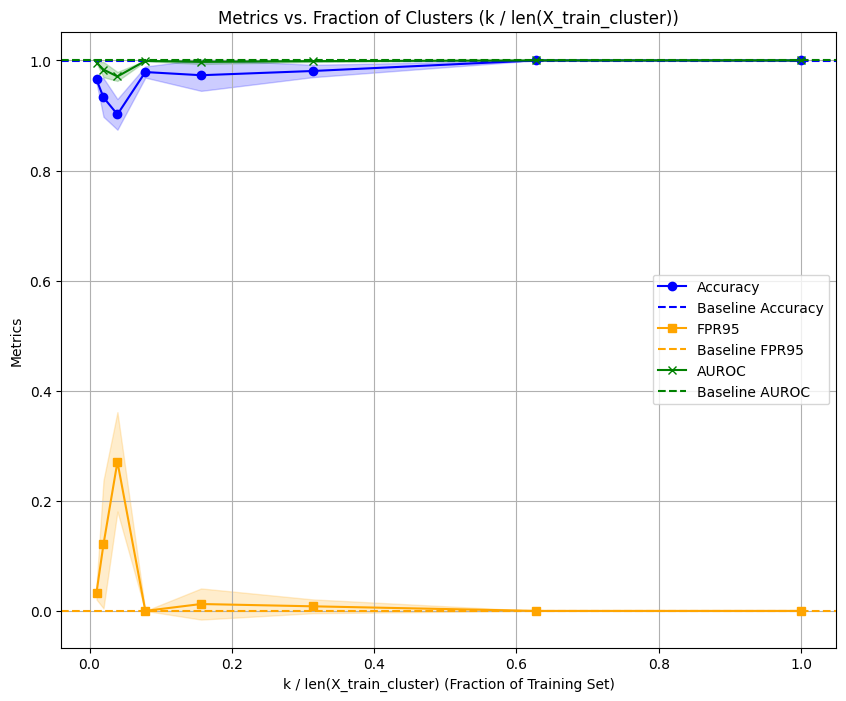

In [189]:
print("confidence_intervals_g", confidence_intervals_g)

df_results = benchmark_kmeans_with_varying_k_condidence_g_hat(
    X,
    y,
    M,
    test_size,
    n_runs=10,
    confidence_level=0.95,
    confidence_intervals_g=confidence_intervals_g,
    clf=None,
)

### Feature Level Visualization: Understand how clustering alters the structure of the feature space

Proportion of label changes: 0.01


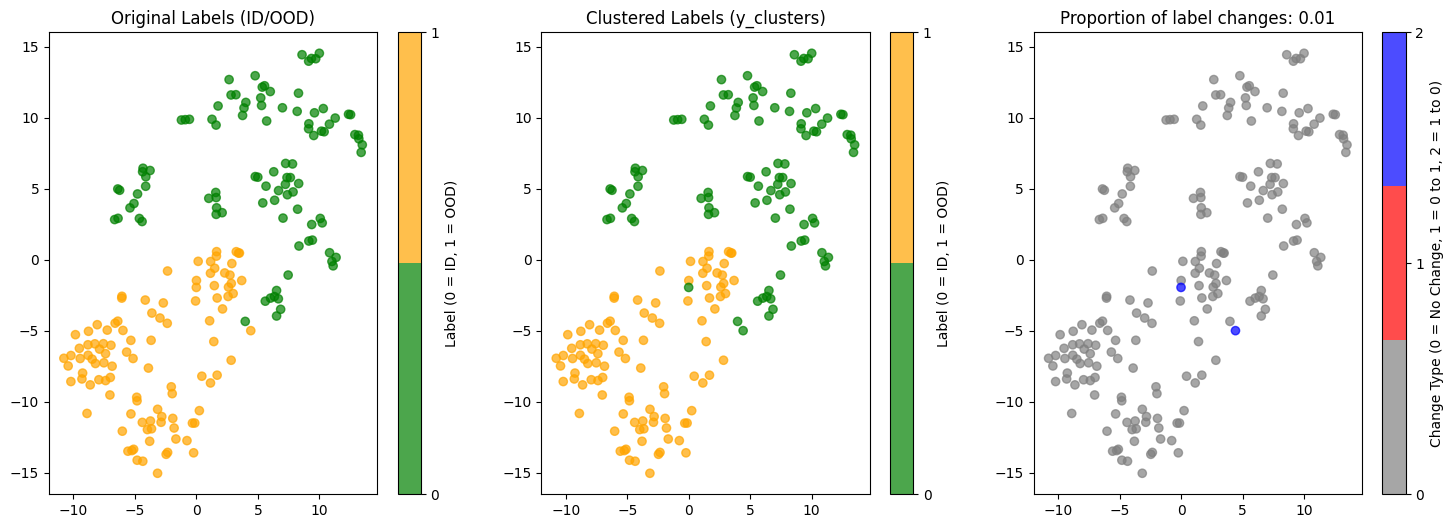

In [190]:
i = 0
_, X_train_cluster, y_train_cluster, y_clusters, *_ = run_g_hat_experiment(
    X, y, test_size, k, M, fixed_seed, fixed_seed, i + 1
)
plot_tsne_with_label_changes(
    X_train_cluster,
    y_train_cluster,
    y_clusters,
    class_name=cfg_dict.data.class_name,
    save_plot=True,
)

# Annual Crop

### Start

In [207]:
X,y,model,datamodule,train_dataloader,val_dataloader,test_dataloader,cfg_dict = get_X_y_arrays(
        paths["annualcrop"]["config"],
        paths["annualcrop"]["ckpt"],
        layer,
        downsample_method,
        getitem_keys,
        device,
        n_batches_to_process,
        mode="holdout",
        verbose=False,
    )

Model and Task are loaded.
download True
Loaded statistics for AnnualCrop: MEAN={'B01': 1354.4053955078125, 'B02': 1118.244384765625, 'B03': 1042.9305419921875, 'B04': 947.6260986328125, 'B05': 1199.472900390625, 'B06': 1999.7916259765625, 'B07': 2369.22314453125, 'B08': 2296.826171875, 'B8A': 732.0834350585938, 'B09': 12.113276481628418, 'B10': 1819.009765625, 'B11': 1118.92333984375, 'B12': 2594.140625}, STD={'B01': 245.71798706054688, 'B02': 333.00848388671875, 'B03': 395.09320068359375, 'B04': 593.7515258789062, 'B05': 566.418212890625, 'B06': 861.185546875, 'B07': 1086.633544921875, 'B08': 1117.98388671875, 'B8A': 404.9206848144531, 'B09': 4.775854587554932, 'B10': 1002.58984375, 'B11': 761.3047485351562, 'B12': 1231.5885009765625}
self.split_urls {'train': 'https://huggingface.co/datasets/brkekm/EuroSATHoldOutSplits/resolve/main/train_annualcrop.txt', 'val': 'https://huggingface.co/datasets/brkekm/EuroSATHoldOutSplits/resolve/main/val_annualcrop.txt', 'test': 'https://huggingface

100%|██████████| 2067725275/2067725275 [00:09<00:00, 224302787.28it/s]


100%|██████████| 278139/278139 [00:00<00:00, 1533516.30it/s]


100%|██████████| 185398/185398 [00:00<00:00, 1826044.50it/s]


100%|██████████| 58893/58893 [00:00<00:00, 6857150.86it/s]


classes and class to idx ['SeaLake', 'Residential', 'PermanentCrop', 'Industrial', 'Pasture', 'Forest', 'HerbaceousVegetation', 'River', 'Highway'] {'Forest': 0, 'HerbaceousVegetation': 1, 'Highway': 2, 'Industrial': 3, 'Pasture': 4, 'PermanentCrop': 5, 'Residential': 6, 'River': 7, 'SeaLake': 8}
self.train_dataset.split_urls {'train': 'https://huggingface.co/datasets/brkekm/EuroSATHoldOutSplits/resolve/main/train_annualcrop.txt', 'val': 'https://huggingface.co/datasets/brkekm/EuroSATHoldOutSplits/resolve/main/val_annualcrop.txt', 'test': 'https://huggingface.co/datasets/brkekm/EuroSATHoldOutSplits/resolve/main/test_annualcrop.txt'}
self.split_urls {'train': 'https://huggingface.co/datasets/brkekm/EuroSATHoldOutSplits/resolve/main/train_annualcrop.txt', 'val': 'https://huggingface.co/datasets/brkekm/EuroSATHoldOutSplits/resolve/main/val_annualcrop.txt', 'test': 'https://huggingface.co/datasets/brkekm/EuroSATHoldOutSplits/resolve/main/test_annualcrop.txt'}
self.root /data/dataood/eurosa

100%|██████████| 2/2 [00:00<00:00,  6.29it/s]


Before downsampling, activations shape for layer conv1 : (128, 64, 32, 32)


100%|██████████| 2/2 [00:00<00:00,  6.80it/s]


Before downsampling, activations shape for layer conv1 : (128, 64, 32, 32)


### Downsample Benchmark

In [208]:
for downsample in downsample_methods:
    print(f"Running experiments for {downsample} downsample method.")
    X, y, test_property_lengths = create_feature_matrix_and_labels(
        model=model,
        dm=datamodule,
        train_dataloader=train_dataloader,
        test_dataloader=test_dataloader,
        layer_names=collect_activations_from_layers,
        device=device,
        getitem_keys=getitem_keys,
        n_batches_to_process=n_batches_to_process,
        downsample_method=downsample,
        verbose=verbose,
    )
    print("Run g experiment for downsample method:", downsample)
    g_benchmark = run_g_experiment(
        X, y, split_seed, test_size, n_estimators, fixed_classifier_seed, clf=None
    )
    dict_key = datamodule.class_name + "_" + downsample
    downsample_benchmark[dict_key] = g_benchmark

Running experiments for avg_pool downsample method.


100%|██████████| 2/2 [00:00<00:00,  7.30it/s]


Before downsampling, activations shape for layer conv1 : (128, 64, 32, 32)


100%|██████████| 2/2 [00:00<00:00,  7.17it/s]


Before downsampling, activations shape for layer conv1 : (128, 64, 32, 32)
Run g experiment for downsample method: avg_pool
Running experiments for mean_std downsample method.


100%|██████████| 2/2 [00:00<00:00,  7.06it/s]


Before downsampling, activations shape for layer conv1 : (128, 64, 32, 32)


100%|██████████| 2/2 [00:00<00:00,  7.24it/s]


Before downsampling, activations shape for layer conv1 : (128, 64, 32, 32)
Run g experiment for downsample method: mean_std
Running experiments for avg_pool downsample method.


100%|██████████| 2/2 [00:00<00:00,  7.14it/s]


Before downsampling, activations shape for layer conv1 : (128, 64, 32, 32)


100%|██████████| 2/2 [00:00<00:00,  6.40it/s]


Before downsampling, activations shape for layer conv1 : (128, 64, 32, 32)
Run g experiment for downsample method: avg_pool
Running experiments for max_pool downsample method.


100%|██████████| 2/2 [00:00<00:00,  7.00it/s]


Before downsampling, activations shape for layer conv1 : (128, 64, 32, 32)


100%|██████████| 2/2 [00:00<00:00,  6.98it/s]


Before downsampling, activations shape for layer conv1 : (128, 64, 32, 32)
Run g experiment for downsample method: max_pool
Running experiments for nodownsample downsample method.


100%|██████████| 2/2 [00:00<00:00,  7.21it/s]


Before downsampling, activations shape for layer conv1 : (128, 64, 32, 32)


100%|██████████| 2/2 [00:00<00:00,  7.17it/s]


Before downsampling, activations shape for layer conv1 : (128, 64, 32, 32)
Run g experiment for downsample method: nodownsample


In [222]:
downsample_benchmark

{'Pasture_avg_pool': {'baseline_accuracy': 0.9038461538461539,
  'baseline_roc_auc': 0.9610194902548725,
  'baseline_fpr95': 0.1724137931034483,
  'actual_ood_samples': 105,
  'actual_id_samples': 99},
 'Pasture_mean_std': {'baseline_accuracy': 0.6153846153846154,
  'baseline_roc_auc': 0.7346326836581709,
  'baseline_fpr95': 0.5172413793103449,
  'actual_ood_samples': 105,
  'actual_id_samples': 99},
 'Pasture_max_pool': {'baseline_accuracy': 0.8461538461538461,
  'baseline_roc_auc': 0.8980509745127436,
  'baseline_fpr95': 0.20689655172413793,
  'actual_ood_samples': 105,
  'actual_id_samples': 99},
 'Pasture_nodownsample': {'baseline_accuracy': 0.34615384615384615,
  'baseline_roc_auc': 0.33133433283358327,
  'baseline_fpr95': 1.0,
  'actual_ood_samples': 105,
  'actual_id_samples': 99},
 'PermanentCrop_avg_pool': {'baseline_accuracy': 0.8269230769230769,
  'baseline_roc_auc': 0.8380809595202399,
  'baseline_fpr95': 0.3448275862068966,
  'actual_ood_samples': 105,
  'actual_id_samples

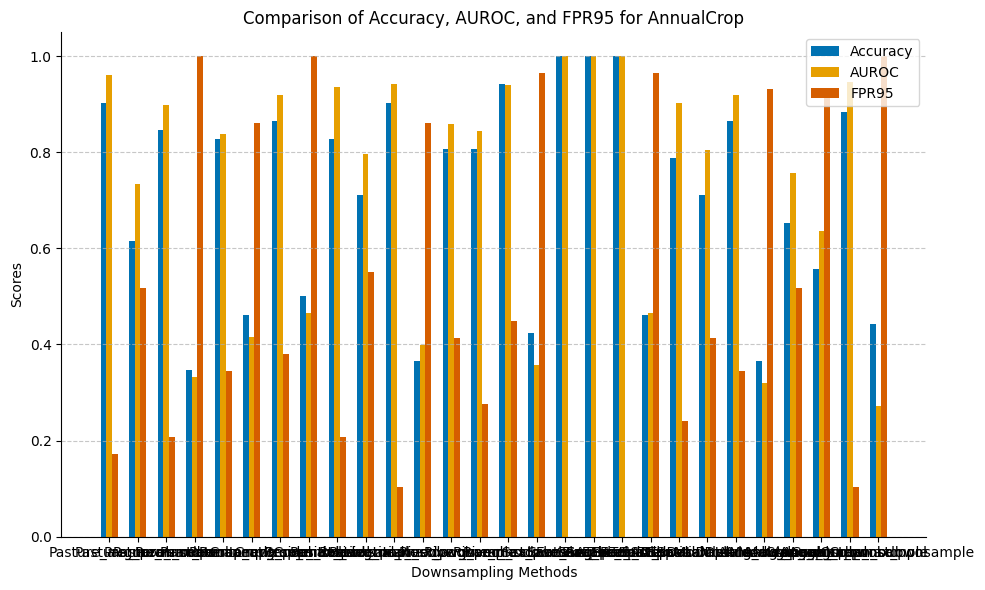

In [209]:
plot_downsample_benchmark(downsample_benchmark, datamodule.class_name)

### Layer Benchmark

In [210]:
for lyr in selected_layers:
    print(f"Running experiments for layer {lyr}")
    X, y, test_property_lengths = create_feature_matrix_and_labels(
        model=model,
        dm=datamodule,
        train_dataloader=train_dataloader,
        test_dataloader=test_dataloader,
        layer_names=lyr,
        device=device,
        getitem_keys=getitem_keys,
        n_batches_to_process=n_batches_to_process,
        downsample_method=downsample_method,
        verbose=verbose,
    )

    g_benchmark = run_g_experiment(
        X, y, split_seed, test_size, n_estimators, fixed_classifier_seed, clf=None
    )
    dict_key = datamodule.class_name + "_" + str(lyr)

    layer_benchmark[dict_key] = g_benchmark

Running experiments for layer ['conv1']


100%|██████████| 2/2 [00:00<00:00,  7.29it/s]


Before downsampling, activations shape for layer conv1 : (128, 64, 32, 32)


100%|██████████| 2/2 [00:00<00:00,  6.13it/s]


Before downsampling, activations shape for layer conv1 : (128, 64, 32, 32)
Running experiments for layer ['layer1.0.conv1']


100%|██████████| 2/2 [00:00<00:00,  7.62it/s]


Before downsampling, activations shape for layer layer1.0.conv1 : (128, 64, 16, 16)


100%|██████████| 2/2 [00:00<00:00,  7.52it/s]


Before downsampling, activations shape for layer layer1.0.conv1 : (128, 64, 16, 16)
Running experiments for layer ['layer3.3.conv1']


100%|██████████| 2/2 [00:00<00:00,  6.30it/s]


Before downsampling, activations shape for layer layer3.3.conv1 : (128, 256, 4, 4)


100%|██████████| 2/2 [00:00<00:00,  6.91it/s]


Before downsampling, activations shape for layer layer3.3.conv1 : (128, 256, 4, 4)
Running experiments for layer ['layer1.2.conv2']


100%|██████████| 2/2 [00:00<00:00,  7.23it/s]


Before downsampling, activations shape for layer layer1.2.conv2 : (128, 64, 16, 16)


100%|██████████| 2/2 [00:00<00:00,  7.26it/s]


Before downsampling, activations shape for layer layer1.2.conv2 : (128, 64, 16, 16)
Running experiments for layer ['layer3.1.conv2']


100%|██████████| 2/2 [00:00<00:00,  7.20it/s]


Before downsampling, activations shape for layer layer3.1.conv2 : (128, 256, 4, 4)


100%|██████████| 2/2 [00:00<00:00,  7.41it/s]


Before downsampling, activations shape for layer layer3.1.conv2 : (128, 256, 4, 4)
Running experiments for layer ['layer2.0.conv1']


100%|██████████| 2/2 [00:00<00:00,  7.18it/s]


Before downsampling, activations shape for layer layer2.0.conv1 : (128, 128, 16, 16)


100%|██████████| 2/2 [00:00<00:00,  7.13it/s]


Before downsampling, activations shape for layer layer2.0.conv1 : (128, 128, 16, 16)
Running experiments for layer ['layer1.0.conv3']


100%|██████████| 2/2 [00:00<00:00,  7.12it/s]


Before downsampling, activations shape for layer layer1.0.conv3 : (128, 256, 16, 16)


100%|██████████| 2/2 [00:00<00:00,  7.00it/s]


Before downsampling, activations shape for layer layer1.0.conv3 : (128, 256, 16, 16)
Running experiments for layer ['layer1.2.conv3']


100%|██████████| 2/2 [00:00<00:00,  7.34it/s]


Before downsampling, activations shape for layer layer1.2.conv3 : (128, 256, 16, 16)


100%|██████████| 2/2 [00:00<00:00,  6.97it/s]


Before downsampling, activations shape for layer layer1.2.conv3 : (128, 256, 16, 16)
Running experiments for layer ['layer4.1.conv3']


100%|██████████| 2/2 [00:00<00:00,  7.33it/s]


Before downsampling, activations shape for layer layer4.1.conv3 : (128, 2048, 2, 2)


100%|██████████| 2/2 [00:00<00:00,  7.22it/s]


Before downsampling, activations shape for layer layer4.1.conv3 : (128, 2048, 2, 2)
Running experiments for layer ['layer4.2.conv3']


100%|██████████| 2/2 [00:00<00:00,  7.50it/s]


Before downsampling, activations shape for layer layer4.2.conv3 : (128, 2048, 2, 2)


100%|██████████| 2/2 [00:00<00:00,  7.07it/s]


Before downsampling, activations shape for layer layer4.2.conv3 : (128, 2048, 2, 2)


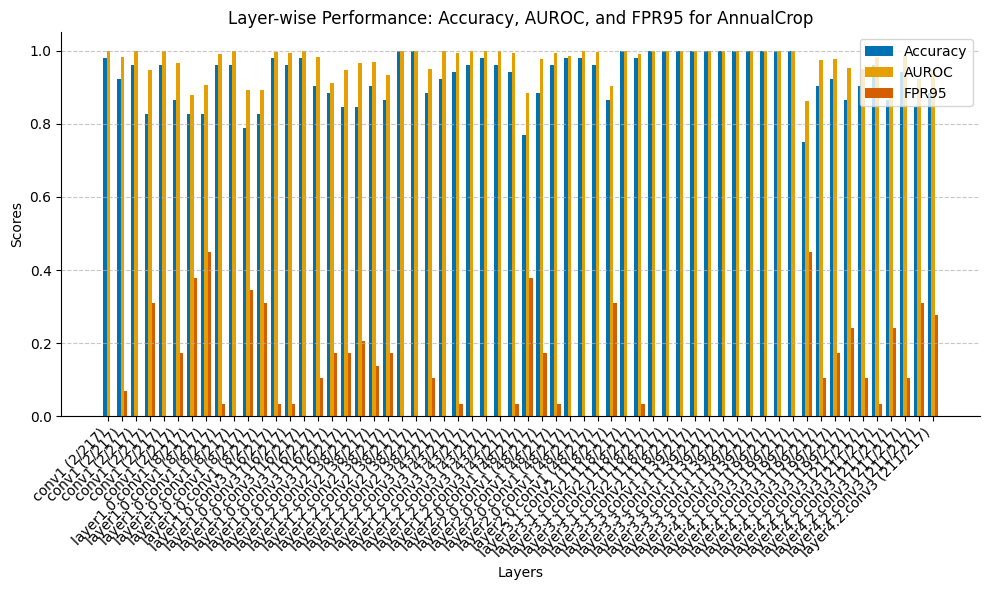

In [211]:
plot_layer_benchmark(layer_benchmark, all_layer_names, datamodule.class_name)

### g confidence interval

In [212]:
g_benchmark = run_multiple_experiments_g(
    X, y, test_size, n_estimators, random_seed=True
)

random_state for split_seed: 1088
random_state for split_seed: 5188
random_state for split_seed: 1407
random_state for split_seed: 8614
random_state for split_seed: 6670
random_state for split_seed: 3726
random_state for split_seed: 990
random_state for split_seed: 3922
random_state for split_seed: 2296
random_state for split_seed: 4545


In [213]:
columns_of_interest = ["baseline_accuracy", "baseline_fpr95", "baseline_roc_auc"]
confidence_intervals_g = calculate_confidence_intervals(
    g_benchmark, columns_of_interest
)
confidence_intervals_g

{'baseline_accuracy': (0.9057692307692309, 0.01885130969045083),
 'baseline_fpr95': (0.18985049959954442, 0.1220979244178982),
 'baseline_roc_auc': (0.971691186775453, 0.010161615588536036)}

### g_hat

In [214]:
results_df_g_hat = run_optuna_study(
    X,
    y,
    n_optuna_trials,
    test_size,
    min_cluster,
    max_cluster_ratio,
    min_fraction,
    max_fraction,
    n_estimators,
    fixed_seed,
)

[I 2024-12-22 18:53:07,932] A new study created in memory with name: no-name-c0705e9b-7d38-4663-8a4c-b8d84af31ee3
[I 2024-12-22 18:53:08,002] Trial 0 finished with value: -0.835167713613843 and parameters: {'k': 19, 'M': 0.19204005763861}. Best is trial 0 with value: -0.835167713613843.
[I 2024-12-22 18:53:08,185] Trial 1 finished with value: -0.8459689802282537 and parameters: {'k': 48, 'M': 0.19750530058756796}. Best is trial 1 with value: -0.8459689802282537.
[I 2024-12-22 18:53:08,242] Trial 2 finished with value: -0.7950227424876617 and parameters: {'k': 14, 'M': 0.03601423928032735}. Best is trial 1 with value: -0.8459689802282537.
[I 2024-12-22 18:53:08,363] Trial 3 finished with value: -0.9196337108186965 and parameters: {'k': 56, 'M': 0.023041318415652854}. Best is trial 3 with value: -0.9196337108186965.
[I 2024-12-22 18:53:08,398] Trial 4 finished with value: -0.6322069817227216 and parameters: {'k': 6, 'M': 0.11327159100258942}. Best is trial 3 with value: -0.91963371081869

In [215]:
N = 10
results_dict = results_df_g_hat.to_dict(orient="records")
k = int(len(X) * 0.3)
M = results_dict[0]["M"]
print("k, M, len(X), k/len(X)", k, M, len(X), k / len(X))

g_hat_benchmark = run_multiple_experiments_g_hat(X, y, test_size, k, M, N, fixed_seed)

k, M, len(X), k/len(X) 76 0.023041318415652854 256 0.296875
random_state for split_seed in iteration 1: 4666
random_state for split_seed in iteration 2: 6735
random_state for split_seed in iteration 3: 1419
random_state for split_seed in iteration 4: 870
random_state for split_seed in iteration 5: 2711
random_state for split_seed in iteration 6: 8376
random_state for split_seed in iteration 7: 2921
random_state for split_seed in iteration 8: 1523
random_state for split_seed in iteration 9: 5535
random_state for split_seed in iteration 10: 7957


### g g_hat mean std + ttest

In [216]:
t_tests_results = perform_benchmark_analysis(g_benchmark, g_hat_benchmark)
t_tests_results

Baseline Accuracy: Mean = 0.9057692307692309, Std Dev = 0.026352313834736497
Baseline ROC AUC: Mean = 0.971691186775453, Std Dev = 0.014204959095902912
Baseline FPR95: Mean = 0.18985049959954442, Std Dev = 0.17068112909206798
g_hat Accuracy: Mean = 0.7865384615384616, Std Dev = 0.10153732840600573
g_hat ROC AUC: Mean = 0.9112917336083486, Std Dev = 0.05143427073401551
g_hat FPR95: Mean = 0.36353187049820984, Std Dev = 0.20384657395904318
Accuracy: t = 3.5942448396206483, p = 0.0020735752794676762
ROC AUC: t = 3.5794727179974295, p = 0.002142831346416262
FPR95: t = -2.0657994264916186, p = 0.053550445838140025


{'accuracy': (3.5942448396206483, 0.0020735752794676762),
 'roc_auc': (3.5794727179974295, 0.002142831346416262),
 'fpr95': (-2.0657994264916186, 0.053550445838140025)}

### Benchmark g

In [217]:
classifier_benchmark_df = benchmark_classifiers(
    X, y, test_size, k, M, classifiers, fixed_seed
)

classifier_benchmark_df

Classifier  Accuracy   ROC_AUC     FPR95  \
0  RandomForestUnblanaced  0.769231  0.924288  0.413793   
1            RandomForest  0.711538  0.940780  0.379310   
2                     SVC  0.826923  0.941529  0.275862   
3              KNeighbors  0.788462  0.919790  1.000000   
4      LogisticRegression  0.788462  0.940030  0.275862   
5            DecisionTree  0.807692  0.791604  1.000000   
6        GradientBoosting  0.750000  0.911544  0.344828   
7                AdaBoost  0.769231  0.956522  0.172414   
8              ExtraTrees  0.730769  0.961769  0.068966   
9              GaussianNB  0.903846  0.974513  0.068966   

   Number of Train Samples  Number of Val Samples  Cluster Fit Time (s)  \
0                      204                     52              0.098585   
1                      204                     52              0.098585   
2                      204                     52              0.098585   
3                      204                     52              0.098585   
4                      204                     52              0.098585   
5                      204                     52              0.098585   
6                      204                     52              0.098585   
7                      204                     52              0.098585   
8                      204                     52              0.098585   
9                      204                     52              0.098585   

   Classifier Fit Time (s)  Classifier Fit Time (s/sample)  \
0                 0.335087                        0.001643   
1                 0.309761                        0.001518   
2                 0.069158                        0.000339   
3                 0.002629                        0.000013   
4                 0.024409                        0.000120   
5                 0.154241                        0.000756   
6                 8.885956                        0.043559   
7                 1.989955                        0.009755   
8                 0.148508                        0.000728   
9                 0.004192                        0.000021   

   Classifier Pred Time (s)  Classifier Pred Time (s/sample)  
0                  0.003954                         0.000076  
1                  0.003968                         0.000076  
2                  0.006927                         0.000133  
3                  0.002645                         0.000051  
4                  0.000487                         0.000009  
5                  0.000468                         0.000009  
6                  0.000829                         0.000016  
7                  0.007194                         0.000138  
8                  0.004066                         0.000078  
9                  0.000978                         0.000019

### Benchmark clustering

In [218]:
# A fixed classifier
classifier = classifiers['RandomForest']

clustering_benchmark_df = benchmark_clustering_methods(
    X, y, test_size, k, M, clustering_methods, classifier
)

clustering_benchmark_df

Clustering  Accuracy  ROC_AUC  FPR95  Clustering Time (s)  \
0          KMeans  0.461538      0.5    1.0             0.006435   
1  DBSCAN_eps_0.1  0.538462      0.5    1.0             0.005822   
2  DBSCAN_eps_0.2  0.538462      0.5    1.0             0.005408   
3  DBSCAN_eps_0.5  0.538462      0.5    1.0             0.005180   

   Classifier Training Time (s)  Number of Samples  
0                      0.095595                204  
1                      0.093078                204  
2                      0.092322                204  
3                      0.090346                204

### Investigate k wrt g-g_hat

confidence_intervals_g {'baseline_accuracy': (0.9057692307692309, 0.01885130969045083), 'baseline_fpr95': (0.18985049959954442, 0.1220979244178982), 'baseline_roc_auc': (0.971691186775453, 0.010161615588536036)}
Max i: 7
k: 1
Skipping k=1 on run 1 due to single class in y_clusters.
Skipping k=1 on run 2 due to single class in y_clusters.
Skipping k=1 on run 3 due to single class in y_clusters.
Skipping k=1 on run 4 due to single class in y_clusters.
Skipping k=1 on run 5 due to single class in y_clusters.
Skipping k=1 on run 6 due to single class in y_clusters.
Skipping k=1 on run 7 due to single class in y_clusters.
Skipping k=1 on run 8 due to single class in y_clusters.
Skipping k=1 on run 9 due to single class in y_clusters.
Skipping k=1 on run 10 due to single class in y_clusters.
k: 2
Skipping k=2 on run 1 due to single class in y_clusters.
Skipping k=2 on run 2 due to single class in y_clusters.
Skipping k=2 on run 3 due to single class in y_clusters.
Skipping k=2 on run 4 due t

/ws/geospatial-ood-detection/notebooks/../src/tardis/eurosat_xbd_utils.py:989: RuntimeWarning: Mean of empty slice
  mean = np.nanmean(values)
/ws/geospatial-ood-detection/notebooks/../src/tardis/eurosat_xbd_utils.py:990: SmallSampleWarning: One or more sample arguments is too small; all returned values will be NaN. See documentation for sample size requirements.
  sem = stats.sem(values, nan_policy="omit")
/ws/geospatial-ood-detection/notebooks/../src/tardis/eurosat_xbd_utils.py:989: RuntimeWarning: Mean of empty slice
  mean = np.nanmean(values)
/ws/geospatial-ood-detection/notebooks/../src/tardis/eurosat_xbd_utils.py:990: SmallSampleWarning: One or more sample arguments is too small; all returned values will be NaN. See documentation for sample size requirements.
  sem = stats.sem(values, nan_policy="omit")
/ws/geospatial-ood-detection/notebooks/../src/tardis/eurosat_xbd_utils.py:989: RuntimeWarning: Mean of empty slice
  mean = np.nanmean(values)
/ws/geospatial-ood-detection/notebo

Skipping k=8 on run 2 due to single class in y_clusters.
Skipping k=8 on run 3 due to single class in y_clusters.
Skipping k=8 on run 5 due to single class in y_clusters.
Skipping k=8 on run 8 due to single class in y_clusters.
Skipping k=8 on run 9 due to single class in y_clusters.
k: 16
Skipping k=16 on run 3 due to single class in y_clusters.
k: 32
k: 64
k: 128
k: 204


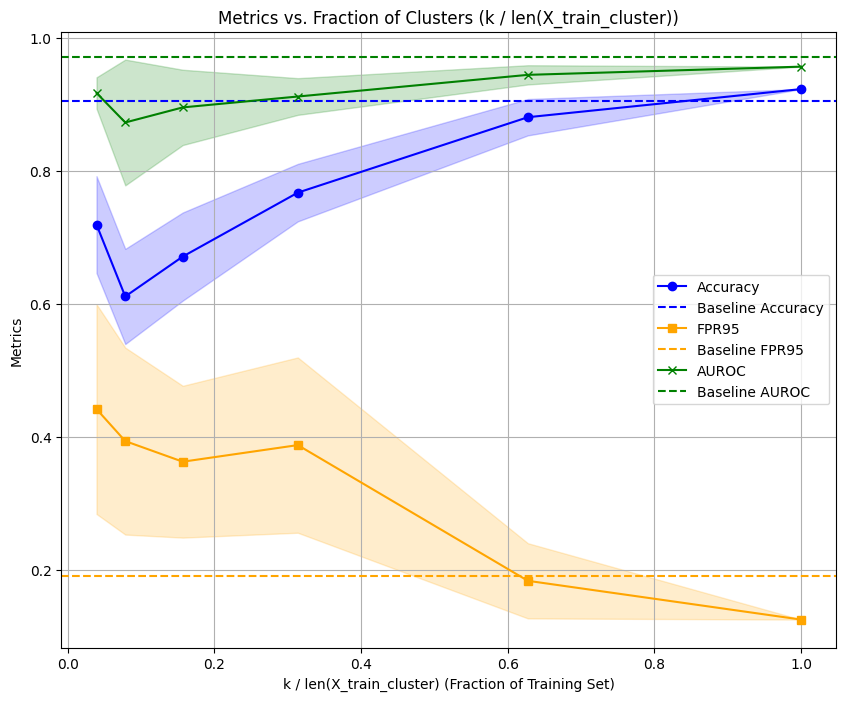

In [219]:
print("confidence_intervals_g", confidence_intervals_g)

df_results = benchmark_kmeans_with_varying_k_condidence_g_hat(
    X,
    y,
    M,
    test_size,
    n_runs=10,
    confidence_level=0.95,
    confidence_intervals_g=confidence_intervals_g,
    clf=None,
)

### Feature Level Visualization: Understand how clustering alters the structure of the feature space

Proportion of label changes: 0.17


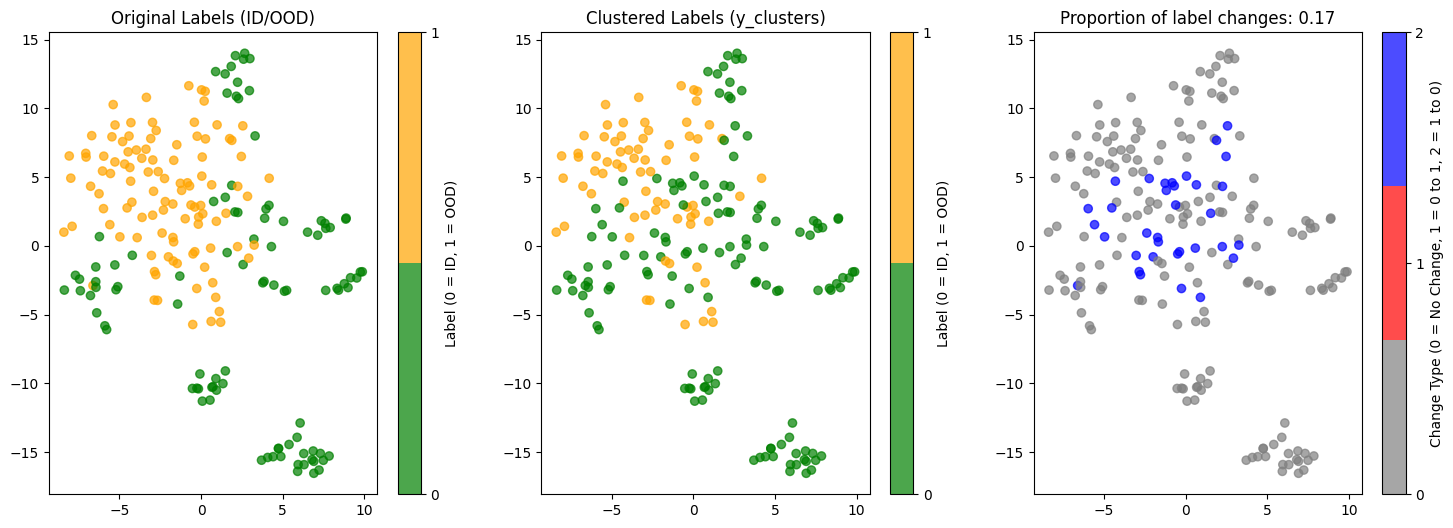

In [220]:
i = 0
_, X_train_cluster, y_train_cluster, y_clusters, *_ = run_g_hat_experiment(
    X, y, test_size, k, M, fixed_seed, fixed_seed, i + 1
)
plot_tsne_with_label_changes(
    X_train_cluster,
    y_train_cluster,
    y_clusters,
    class_name=cfg_dict.data.class_name,
    save_plot=True,
)

# Spatial Split

### Start

In [221]:
X,y,model,datamodule,train_dataloader,val_dataloader,test_dataloader,cfg_dict = get_X_y_arrays(
        paths["spatial_split"]["config"],
        paths["spatial_split"]["ckpt"],
        layer,
        downsample_method,
        getitem_keys,
        device,
        n_batches_to_process,
        mode="spatialsplit",
        verbose=False,
    )

/opt/conda/envs/ood/lib/python3.11/site-packages/lightning/pytorch/utilities/migration/utils.py:56: The loaded checkpoint was produced with Lightning v2.4.0, which is newer than your current Lightning version: v2.2.5


Model and Task are loaded.
('B01', 'B02', 'B03', 'B04', 'B05', 'B06', 'B07', 'B08', 'B8A', 'B09', 'B10', 'B11', 'B12')
DataModule setup complete.
Model -- Task -- Dataloaders are loaded.
len(train_dataloader), len(val_dataloader), len(test_dataloader):  254 85 85


100%|██████████| 2/2 [00:00<00:00,  7.23it/s]


Before downsampling, activations shape for layer conv1 : (128, 64, 32, 32)


100%|██████████| 2/2 [00:00<00:00,  7.30it/s]


Before downsampling, activations shape for layer conv1 : (128, 64, 32, 32)


### Downsample Benchmark

In [196]:
for downsample in downsample_methods:
    print(f"Running experiments for {downsample} downsample method.")
    X, y, test_property_lengths = create_feature_matrix_and_labels(
        model=model,
        dm=datamodule,
        train_dataloader=train_dataloader,
        test_dataloader=test_dataloader,
        layer_names=collect_activations_from_layers,
        device=device,
        getitem_keys=getitem_keys,
        n_batches_to_process=n_batches_to_process,
        downsample_method=downsample,
        verbose=verbose,
    )

    print("Run g experiment for downsample method:", downsample)
    g_benchmark = run_g_experiment(
        X, y, split_seed, test_size, n_estimators, fixed_classifier_seed, clf=None
    )
    dict_key = datamodule.__class__.__name__ + "_" + downsample
    downsample_benchmark[dict_key] = g_benchmark

Running experiments for avg_pool downsample method.


100%|██████████| 2/2 [00:00<00:00,  7.17it/s]


Before downsampling, activations shape for layer conv1 : (128, 64, 32, 32)


100%|██████████| 2/2 [00:00<00:00,  7.39it/s]


Before downsampling, activations shape for layer conv1 : (128, 64, 32, 32)
Run g experiment for downsample method: avg_pool
Running experiments for mean_std downsample method.


100%|██████████| 2/2 [00:00<00:00,  6.66it/s]


Before downsampling, activations shape for layer conv1 : (128, 64, 32, 32)


100%|██████████| 2/2 [00:00<00:00,  7.47it/s]


Before downsampling, activations shape for layer conv1 : (128, 64, 32, 32)
Run g experiment for downsample method: mean_std
Running experiments for avg_pool downsample method.


100%|██████████| 2/2 [00:00<00:00,  7.42it/s]


Before downsampling, activations shape for layer conv1 : (128, 64, 32, 32)


100%|██████████| 2/2 [00:00<00:00,  7.28it/s]


Before downsampling, activations shape for layer conv1 : (128, 64, 32, 32)
Run g experiment for downsample method: avg_pool
Running experiments for max_pool downsample method.


100%|██████████| 2/2 [00:00<00:00,  7.33it/s]


Before downsampling, activations shape for layer conv1 : (128, 64, 32, 32)


100%|██████████| 2/2 [00:00<00:00,  7.21it/s]


Before downsampling, activations shape for layer conv1 : (128, 64, 32, 32)
Run g experiment for downsample method: max_pool
Running experiments for nodownsample downsample method.


100%|██████████| 2/2 [00:00<00:00,  7.32it/s]


Before downsampling, activations shape for layer conv1 : (128, 64, 32, 32)


100%|██████████| 2/2 [00:00<00:00,  7.34it/s]


Before downsampling, activations shape for layer conv1 : (128, 64, 32, 32)
Run g experiment for downsample method: nodownsample


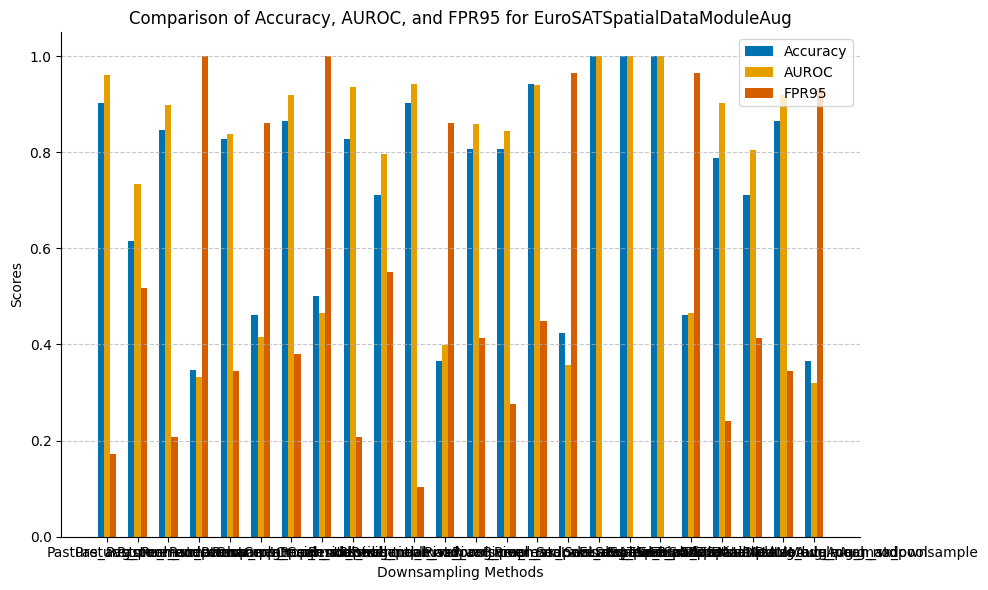

In [206]:
plot_downsample_benchmark(downsample_benchmark, datamodule.__class__.__name__)

### Layer Benchmark

In [223]:
for lyr in selected_layers:
    print(f"Running experiments for layer {lyr}")
    X, y, test_property_lengths = create_feature_matrix_and_labels(
        model=model,
        dm=datamodule,
        train_dataloader=train_dataloader,
        test_dataloader=test_dataloader,
        layer_names=lyr,
        device=device,
        getitem_keys=getitem_keys,
        n_batches_to_process=n_batches_to_process,
        downsample_method=downsample_method,
        verbose=verbose,
    )

    g_benchmark = run_g_experiment(
        X, y, split_seed, test_size, n_estimators, fixed_classifier_seed, clf=None
    )
    dict_key = datamodule.__class__.__name__ + "_" + str(lyr)

    layer_benchmark[dict_key] = g_benchmark

Running experiments for layer ['conv1']


100%|██████████| 2/2 [00:00<00:00,  7.23it/s]


Before downsampling, activations shape for layer conv1 : (128, 64, 32, 32)


100%|██████████| 2/2 [00:00<00:00,  7.18it/s]


Before downsampling, activations shape for layer conv1 : (128, 64, 32, 32)
Running experiments for layer ['layer1.0.conv1']


100%|██████████| 2/2 [00:00<00:00,  7.38it/s]


Before downsampling, activations shape for layer layer1.0.conv1 : (128, 64, 16, 16)


100%|██████████| 2/2 [00:00<00:00,  7.63it/s]


Before downsampling, activations shape for layer layer1.0.conv1 : (128, 64, 16, 16)
Running experiments for layer ['layer3.3.conv1']


100%|██████████| 2/2 [00:00<00:00,  7.63it/s]


Before downsampling, activations shape for layer layer3.3.conv1 : (128, 256, 4, 4)


100%|██████████| 2/2 [00:00<00:00,  6.99it/s]


Before downsampling, activations shape for layer layer3.3.conv1 : (128, 256, 4, 4)
Running experiments for layer ['layer1.2.conv2']


100%|██████████| 2/2 [00:00<00:00,  7.24it/s]


Before downsampling, activations shape for layer layer1.2.conv2 : (128, 64, 16, 16)


100%|██████████| 2/2 [00:00<00:00,  7.58it/s]


Before downsampling, activations shape for layer layer1.2.conv2 : (128, 64, 16, 16)
Running experiments for layer ['layer3.1.conv2']


100%|██████████| 2/2 [00:00<00:00,  7.40it/s]


Before downsampling, activations shape for layer layer3.1.conv2 : (128, 256, 4, 4)


100%|██████████| 2/2 [00:00<00:00,  7.63it/s]


Before downsampling, activations shape for layer layer3.1.conv2 : (128, 256, 4, 4)
Running experiments for layer ['layer2.0.conv1']


100%|██████████| 2/2 [00:00<00:00,  7.46it/s]


Before downsampling, activations shape for layer layer2.0.conv1 : (128, 128, 16, 16)


100%|██████████| 2/2 [00:00<00:00,  7.41it/s]


Before downsampling, activations shape for layer layer2.0.conv1 : (128, 128, 16, 16)
Running experiments for layer ['layer1.0.conv3']


100%|██████████| 2/2 [00:00<00:00,  7.25it/s]


Before downsampling, activations shape for layer layer1.0.conv3 : (128, 256, 16, 16)


100%|██████████| 2/2 [00:00<00:00,  7.44it/s]


Before downsampling, activations shape for layer layer1.0.conv3 : (128, 256, 16, 16)
Running experiments for layer ['layer1.2.conv3']


100%|██████████| 2/2 [00:00<00:00,  7.10it/s]


Before downsampling, activations shape for layer layer1.2.conv3 : (128, 256, 16, 16)


100%|██████████| 2/2 [00:00<00:00,  7.16it/s]


Before downsampling, activations shape for layer layer1.2.conv3 : (128, 256, 16, 16)
Running experiments for layer ['layer4.1.conv3']


100%|██████████| 2/2 [00:00<00:00,  7.24it/s]


Before downsampling, activations shape for layer layer4.1.conv3 : (128, 2048, 2, 2)


100%|██████████| 2/2 [00:00<00:00,  7.55it/s]


Before downsampling, activations shape for layer layer4.1.conv3 : (128, 2048, 2, 2)
Running experiments for layer ['layer4.2.conv3']


100%|██████████| 2/2 [00:00<00:00,  7.66it/s]


Before downsampling, activations shape for layer layer4.2.conv3 : (128, 2048, 2, 2)


100%|██████████| 2/2 [00:00<00:00,  7.38it/s]


Before downsampling, activations shape for layer layer4.2.conv3 : (128, 2048, 2, 2)


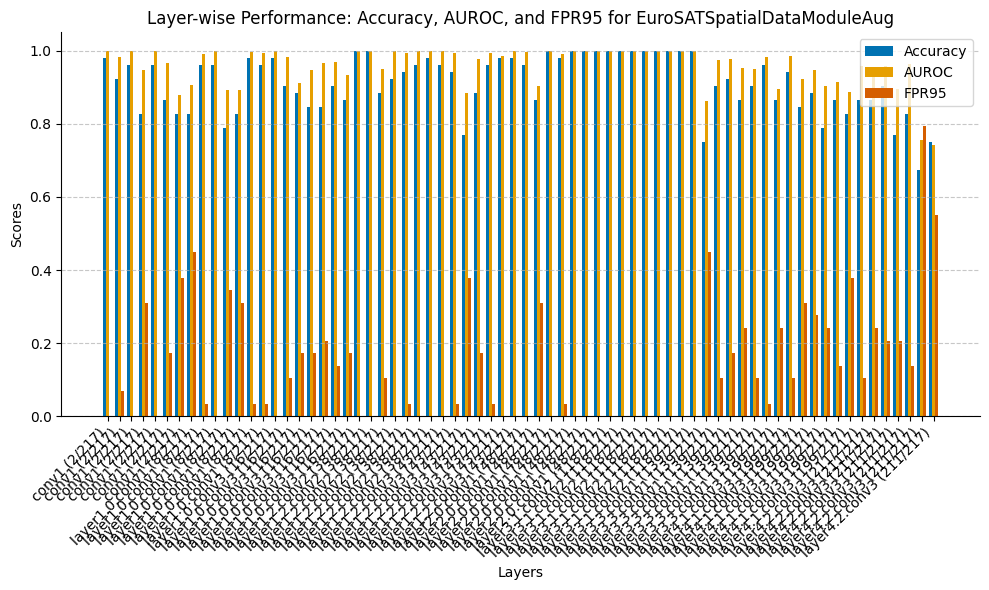

In [225]:
plot_layer_benchmark(layer_benchmark, all_layer_names, datamodule.__class__.__name__)

### g confidence interval

In [226]:
g_benchmark = run_multiple_experiments_g(
    X, y, test_size, n_estimators, random_seed=True
)

random_state for split_seed: 1712
random_state for split_seed: 3936
random_state for split_seed: 1619
random_state for split_seed: 1850
random_state for split_seed: 8567
random_state for split_seed: 1625
random_state for split_seed: 2939
random_state for split_seed: 1449
random_state for split_seed: 8358
random_state for split_seed: 7462


In [227]:
columns_of_interest = ["baseline_accuracy", "baseline_fpr95", "baseline_roc_auc"]
confidence_intervals_g = calculate_confidence_intervals(
    g_benchmark, columns_of_interest
)
confidence_intervals_g

{'baseline_accuracy': (0.6653846153846154, 0.06619832993488503),
 'baseline_fpr95': (0.7452827810758845, 0.10520494633430004),
 'baseline_roc_auc': (0.7106376652824131, 0.05687474081184133)}

### g_hat

In [228]:
results_df_g_hat = run_optuna_study(
    X,
    y,
    n_optuna_trials,
    test_size,
    min_cluster,
    max_cluster_ratio,
    min_fraction,
    max_fraction,
    n_estimators,
    fixed_seed,
)

[I 2024-12-22 18:55:28,192] A new study created in memory with name: no-name-84951d3c-3a61-46e7-9ca2-a8f6722284a2
[I 2024-12-22 18:55:28,263] Trial 0 finished with value: inf and parameters: {'k': 19, 'M': 0.19204005763861}. Best is trial 0 with value: inf.
[I 2024-12-22 18:55:28,468] Trial 1 finished with value: -0.7000345659579987 and parameters: {'k': 48, 'M': 0.19750530058756796}. Best is trial 1 with value: -0.7000345659579987.
[I 2024-12-22 18:55:28,491] Trial 2 finished with value: inf and parameters: {'k': 14, 'M': 0.03601423928032735}. Best is trial 1 with value: -0.7000345659579987.
[I 2024-12-22 18:55:28,632] Trial 3 finished with value: -0.7403008155275921 and parameters: {'k': 56, 'M': 0.023041318415652854}. Best is trial 3 with value: -0.7403008155275921.
[I 2024-12-22 18:55:28,648] Trial 4 finished with value: inf and parameters: {'k': 6, 'M': 0.11327159100258942}. Best is trial 3 with value: -0.7403008155275921.
[I 2024-12-22 18:55:28,665] Trial 5 finished with value: i

In [229]:
results_dict = results_df_g_hat.to_dict(orient="records")
k = int(len(X) * 0.3)
M = results_dict[0]["M"]
print("k, M, len(X), k/len(X)", k, M, len(X), k / len(X))

g_hat_benchmark = run_multiple_experiments_g_hat(X, y, test_size, k, M, N, fixed_seed)

k, M, len(X), k/len(X) 76 0.14224922508301596 256 0.296875
random_state for split_seed in iteration 1: 939
random_state for split_seed in iteration 2: 6476
random_state for split_seed in iteration 3: 5216
random_state for split_seed in iteration 4: 7307
random_state for split_seed in iteration 5: 2981
random_state for split_seed in iteration 6: 5175
random_state for split_seed in iteration 7: 4926
random_state for split_seed in iteration 8: 4510
random_state for split_seed in iteration 9: 4207
random_state for split_seed in iteration 10: 6384


### g g_hat mean std + ttest

In [230]:
t_tests_results = perform_benchmark_analysis(g_benchmark, g_hat_benchmark)
t_tests_results

Baseline Accuracy: Mean = 0.6653846153846154, Std Dev = 0.0925388842698389
Baseline ROC AUC: Mean = 0.7106376652824131, Std Dev = 0.07950540539377747
Baseline FPR95: Mean = 0.7452827810758845, Std Dev = 0.14706637407651563
g_hat Accuracy: Mean = 0.5269230769230769, Std Dev = 0.07861389598336353
g_hat ROC AUC: Mean = 0.6351468390065496, Std Dev = 0.08753732571270416
g_hat FPR95: Mean = 0.8225909282663846, Std Dev = 0.11162999872506216
Accuracy: t = 3.6060150417885595, p = 0.0020199879306768563
ROC AUC: t = 2.0187388207341255, p = 0.05866519339057018
FPR95: t = -1.3240768651907742, p = 0.20204649712321013


{'accuracy': (3.6060150417885595, 0.0020199879306768563),
 'roc_auc': (2.0187388207341255, 0.05866519339057018),
 'fpr95': (-1.3240768651907742, 0.20204649712321013)}

### Benchmark g

In [231]:
classifier_benchmark_df = benchmark_classifiers(
    X, y, test_size, k, M, classifiers, fixed_seed
)

classifier_benchmark_df

Classifier  Accuracy   ROC_AUC     FPR95  \
0  RandomForestUnblanaced  0.557692  0.435532  1.000000   
1            RandomForest  0.557692  0.494753  0.896552   
2                     SVC  0.615385  0.553223  0.793103   
3              KNeighbors  0.576923  0.525487  1.000000   
4      LogisticRegression  0.615385  0.788606  0.517241   
5            DecisionTree  0.557692  0.517991  1.000000   
6        GradientBoosting  0.596154  0.528486  1.000000   
7                AdaBoost  0.596154  0.547226  0.965517   
8              ExtraTrees  0.557692  0.470765  0.896552   
9              GaussianNB  0.538462  0.593703  0.724138   

   Number of Train Samples  Number of Val Samples  Cluster Fit Time (s)  \
0                      204                     52              0.108006   
1                      204                     52              0.108006   
2                      204                     52              0.108006   
3                      204                     52              0.108006   
4                      204                     52              0.108006   
5                      204                     52              0.108006   
6                      204                     52              0.108006   
7                      204                     52              0.108006   
8                      204                     52              0.108006   
9                      204                     52              0.108006   

   Classifier Fit Time (s)  Classifier Fit Time (s/sample)  \
0                 0.394907                        0.001936   
1                 0.254340                        0.001247   
2                 0.062595                        0.000307   
3                 0.002742                        0.000013   
4                 0.034890                        0.000171   
5                 0.122901                        0.000602   
6                 9.296462                        0.045571   
7                 1.981343                        0.009712   
8                 0.132674                        0.000650   
9                 0.004145                        0.000020   

   Classifier Pred Time (s)  Classifier Pred Time (s/sample)  
0                  0.003935                         0.000076  
1                  0.003829                         0.000074  
2                  0.006345                         0.000122  
3                  0.002755                         0.000053  
4                  0.000487                         0.000009  
5                  0.000472                         0.000009  
6                  0.000806                         0.000015  
7                  0.007220                         0.000139  
8                  0.004109                         0.000079  
9                  0.000960                         0.000018

### Benchmark clustering

In [232]:
# A fixed classifier
classifier = classifiers['RandomForest']

clustering_benchmark_df = benchmark_clustering_methods(
    X, y, test_size, k, M, clustering_methods, classifier
)

clustering_benchmark_df

Clustering  Accuracy  ROC_AUC  FPR95  Clustering Time (s)  \
0          KMeans  0.461538      0.5    1.0             0.007226   
1  DBSCAN_eps_0.1  0.538462      0.5    1.0             0.005765   
2  DBSCAN_eps_0.2  0.538462      0.5    1.0             0.005242   
3  DBSCAN_eps_0.5  0.538462      0.5    1.0             0.005183   

   Classifier Training Time (s)  Number of Samples  
0                      0.094443                204  
1                      0.092843                204  
2                      0.091281                204  
3                      0.090367                204

### Investigate k wrt g-g_hat

In [234]:
cfg_dict

{'defaults': ['_self_'], 'exp_name': 'eurosat_spatial_0776', 'model': {'name': 'resnet50', 'weights': True, 'in_channels': 13, 'num_classes': 10, 'lr': 0.0001, 'patience': 7}, 'trainer': {'devices': 1, 'fast_dev_run': False, 'min_epochs': 1, 'max_epochs': 50}, 'data': {'root': '/data/dataood/eurosat_holdout_datasets/data_spatial_eurosat', 'batch_size': 64, 'num_workers': 8, 'download': True, 'checksum': False, 'drop_last': False}, 'logging': {'path': './geospatial-ood-detection/experiments'}, 'training': {'patience': 5}}

confidence_intervals_g {'baseline_accuracy': (0.6653846153846154, 0.06619832993488503), 'baseline_fpr95': (0.7452827810758845, 0.10520494633430004), 'baseline_roc_auc': (0.7106376652824131, 0.05687474081184133)}
Max i: 7
k: 1
Skipping k=1 on run 1 due to single class in y_clusters.
Skipping k=1 on run 2 due to single class in y_clusters.
Skipping k=1 on run 3 due to single class in y_clusters.
Skipping k=1 on run 4 due to single class in y_clusters.
Skipping k=1 on run 5 due to single class in y_clusters.
Skipping k=1 on run 6 due to single class in y_clusters.
Skipping k=1 on run 7 due to single class in y_clusters.
Skipping k=1 on run 8 due to single class in y_clusters.
Skipping k=1 on run 9 due to single class in y_clusters.
Skipping k=1 on run 10 due to single class in y_clusters.
k: 2
Skipping k=2 on run 1 due to single class in y_clusters.
Skipping k=2 on run 2 due to single class in y_clusters.
Skipping k=2 on run 3 due to single class in y_clusters.
Skipping k=2 on run 4 due t

/ws/geospatial-ood-detection/notebooks/../src/tardis/eurosat_xbd_utils.py:989: RuntimeWarning: Mean of empty slice
  mean = np.nanmean(values)
/ws/geospatial-ood-detection/notebooks/../src/tardis/eurosat_xbd_utils.py:990: SmallSampleWarning: One or more sample arguments is too small; all returned values will be NaN. See documentation for sample size requirements.
  sem = stats.sem(values, nan_policy="omit")
/ws/geospatial-ood-detection/notebooks/../src/tardis/eurosat_xbd_utils.py:989: RuntimeWarning: Mean of empty slice
  mean = np.nanmean(values)
/ws/geospatial-ood-detection/notebooks/../src/tardis/eurosat_xbd_utils.py:990: SmallSampleWarning: One or more sample arguments is too small; all returned values will be NaN. See documentation for sample size requirements.
  sem = stats.sem(values, nan_policy="omit")
/ws/geospatial-ood-detection/notebooks/../src/tardis/eurosat_xbd_utils.py:989: RuntimeWarning: Mean of empty slice
  mean = np.nanmean(values)
/ws/geospatial-ood-detection/notebo

Skipping k=8 on run 3 due to single class in y_clusters.
Skipping k=8 on run 4 due to single class in y_clusters.
Skipping k=8 on run 5 due to single class in y_clusters.
Skipping k=8 on run 6 due to single class in y_clusters.
Skipping k=8 on run 7 due to single class in y_clusters.
Skipping k=8 on run 8 due to single class in y_clusters.
Skipping k=8 on run 9 due to single class in y_clusters.
Skipping k=8 on run 10 due to single class in y_clusters.
k: 16
Skipping k=16 on run 1 due to single class in y_clusters.
Skipping k=16 on run 2 due to single class in y_clusters.
Skipping k=16 on run 3 due to single class in y_clusters.
Skipping k=16 on run 4 due to single class in y_clusters.


/ws/geospatial-ood-detection/notebooks/../src/tardis/eurosat_xbd_utils.py:989: RuntimeWarning: Mean of empty slice
  mean = np.nanmean(values)
/ws/geospatial-ood-detection/notebooks/../src/tardis/eurosat_xbd_utils.py:990: SmallSampleWarning: One or more sample arguments is too small; all returned values will be NaN. See documentation for sample size requirements.
  sem = stats.sem(values, nan_policy="omit")


Skipping k=16 on run 5 due to single class in y_clusters.
Skipping k=16 on run 7 due to single class in y_clusters.
Skipping k=16 on run 8 due to single class in y_clusters.
Skipping k=16 on run 9 due to single class in y_clusters.
k: 32
Skipping k=32 on run 6 due to single class in y_clusters.
k: 64
k: 128
k: 204


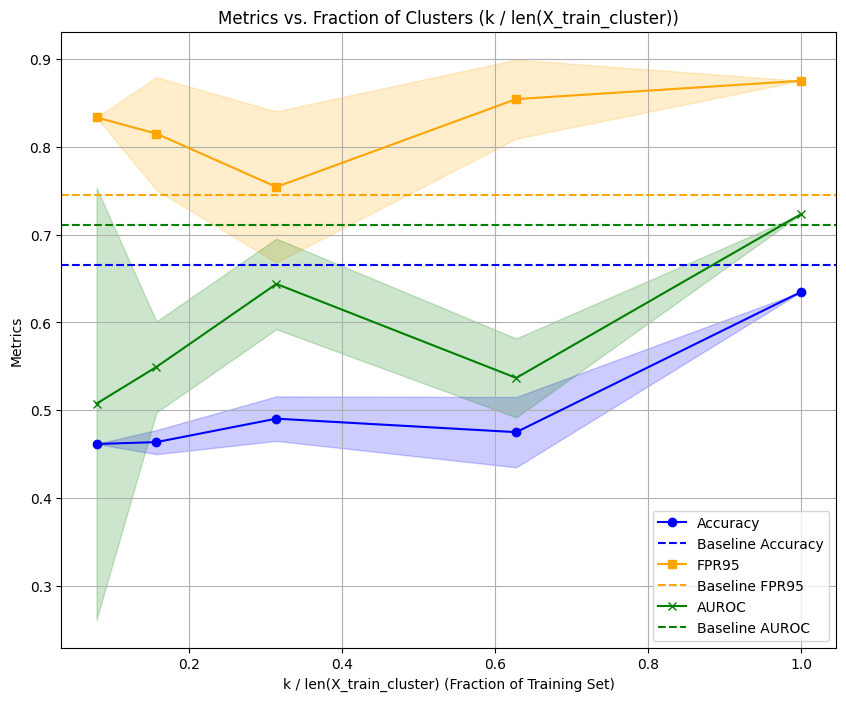

In [235]:
print("confidence_intervals_g", confidence_intervals_g)

df_results = benchmark_kmeans_with_varying_k_condidence_g_hat(
    X,
    y,
    M,
    test_size,
    n_runs=10,
    confidence_level=0.95,
    confidence_intervals_g=confidence_intervals_g,
    clf=None,
    save_plot=True,
    fname=cfg_dict["exp_name"],
)

### Feature Level Visualization: Understand how clustering alters the structure of the feature space

Proportion of label changes: 0.39


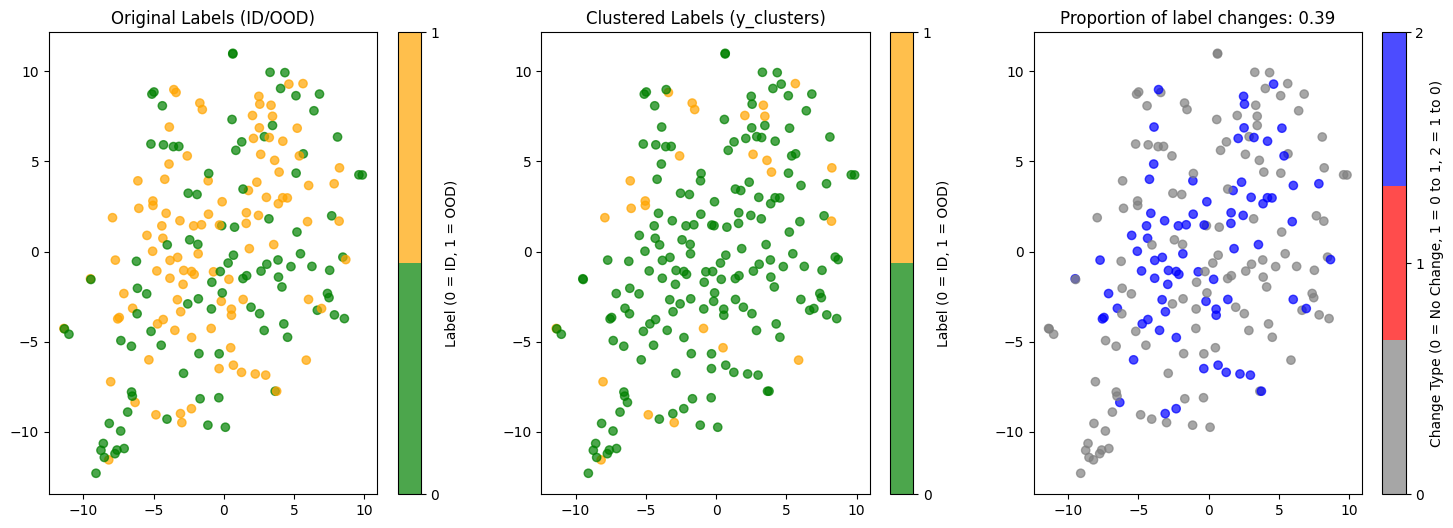

In [237]:
i = 0
_, X_train_cluster, y_train_cluster, y_clusters, *_ = run_g_hat_experiment(
    X, y, test_size, k, M, fixed_seed, fixed_seed, i + 1
)
plot_tsne_with_label_changes(
    X_train_cluster,
    y_train_cluster,
    y_clusters,
    class_name=cfg_dict["exp_name"],
    save_plot=True,
)